# MACHINE LEARNING SUPERVISED LEARNING PROCESS #

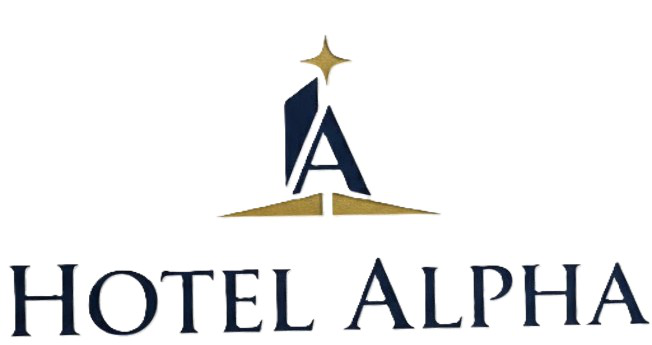

In [1]:
# insert image into CELL 
from PIL import Image
from IPython.display import display

try:
	img = Image.open("alphahotel.jpeg")
	display(img)
except FileNotFoundError:
	print("Image file 'alphahotel.jpeg' not found. Please ensure the file is in the current directory or provide the correct path.")

In [1]:
# CELL No 1

# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# import missingno
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
# from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

In [2]:
# CELL No 2
# load dataset
df = pd.read_csv('1_hotel_bookings_prepared.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_nights,total_people,weekend_ratio,booking_complexity,customer_reliability,lead_time_category,season,is_peak_season
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,0,0,0,C,3,No Deposit,0.0,0,Transient,0.0,0,0,0,2.0,0.0,3,0.0,Long,Summer,1
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,0,0,0,C,4,No Deposit,0.0,0,Transient,0.0,0,0,0,2.0,0.0,4,0.0,Very_Long,Summer,1
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,0,0,0,A,0,No Deposit,0.0,0,Transient,75.0,0,0,1,1.0,0.0,0,0.0,Very_Short,Summer,1
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,0,0,0,A,0,No Deposit,304.0,0,Transient,75.0,0,0,1,1.0,0.0,0,0.0,Short,Summer,1
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,0,0,0,A,0,No Deposit,240.0,0,Transient,98.0,0,1,2,2.0,0.0,1,0.0,Short,Summer,1


## Preprocessing ##

In [3]:
# Import Additional Libraries for Preprocessing
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Try import category encoders for binary encoding
try:
    import category_encoders as ce
    BINARY_ENCODING_AVAILABLE = True
    print("Category encoders available - Binary encoding enabled")
except ImportError:
    BINARY_ENCODING_AVAILABLE = False
    print("Category encoders not available - Using fallback encoding")

# Dataset info
print(f"\nDataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Category encoders available - Binary encoding enabled

Dataset shape: (87396, 35)
Memory usage: 62.76 MB


In [4]:
# CELL 3 : Target and Features Separation
target_column = 'is_canceled'
X = df.drop(columns=[target_column])
y = df[target_column]

print(f"Target: {target_column}")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\nTarget proportion:")
print(y.value_counts(normalize=True).round(3))

Target: is_canceled
Features shape: (87396, 34)
Target shape: (87396,)

Target distribution:
is_canceled
0    63371
1    24025
Name: count, dtype: int64

Target proportion:
is_canceled
0    0.725
1    0.275
Name: proportion, dtype: float64


In [5]:
# CELL 4 : Feature Analysis and Categorization
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features ({len(numerical_features)}):")
print(numerical_features)
print(f"\nCategorical features ({len(categorical_features)}):")

# Analyze categorical features by cardinality
low_cardinality_features = []    # 2-10 unique values -> OneHot
high_cardinality_features = []   # >10 unique values -> Binary

cardinality_info = []
for col in categorical_features:
    unique_count = X[col].nunique()
    sample_values = X[col].unique()[:3].tolist()
    
    if unique_count <= 10:
        low_cardinality_features.append(col)
        category = "Low"
    else:
        high_cardinality_features.append(col)
        category = "High"
    
    cardinality_info.append({
        'feature': col,
        'unique_count': unique_count,
        'category': category,
        'sample': sample_values
    })
    
    print(f"  {col}: {unique_count} unique ({category}) - {sample_values}")

print(f"\nENCODING STRATEGY:")
print(f"  Low cardinality ({len(low_cardinality_features)}): OneHot Encoding")
print(f"  High cardinality ({len(high_cardinality_features)}): {'Binary' if BINARY_ENCODING_AVAILABLE else 'Ordinal'} Encoding")

Numerical features (24):
['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'agent', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights', 'total_people', 'weekend_ratio', 'booking_complexity', 'customer_reliability', 'is_peak_season']

Categorical features (10):
  hotel: 2 unique (Low) - ['Resort Hotel', 'City Hotel']
  arrival_date_month: 12 unique (High) - ['July', 'August', 'September']
  meal: 5 unique (Low) - ['BB', 'FB', 'HB']
  country: 177 unique (High) - ['PRT', 'GBR', 'USA']
  market_segment: 8 unique (Low) - ['Direct', 'Corporate', 'Online TA']
  reserved_room_type: 10 unique (Low) - ['C', 'A', 'D']
  deposit_type: 3 unique (Low) - ['No Deposit', 'Refundable', 'Non Refund']
  customer_type: 4 unique (L

In [6]:
# CELL 5 : Build Preprocessing Pipeline
print("BUILDING PREPROCESSING PIPELINE")
print("="*50)

# 1. Numerical Pipeline
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])
print("Numerical Pipeline: Imputer(median) + RobustScaler")

# 2. Low Cardinality Categorical Pipeline
low_cardinality_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])
print("Low Cardinality Pipeline: Imputer(mode) + OneHotEncoder")

# 3. High Cardinality Categorical Pipeline
if BINARY_ENCODING_AVAILABLE and high_cardinality_features:
    high_cardinality_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('binary_encoder', ce.BinaryEncoder(drop_invariant=True, return_df=False))
    ])
    print("High Cardinality Pipeline: Imputer(mode) + BinaryEncoder")
else:
    high_cardinality_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])
    print("High Cardinality Pipeline: Imputer(mode) + OrdinalEncoder (fallback)")

# Combine transformers
transformers = [
    ('num', numerical_pipeline, numerical_features),
    ('low_cat', low_cardinality_pipeline, low_cardinality_features)
]

if high_cardinality_features:
    transformers.append(('high_cat', high_cardinality_pipeline, high_cardinality_features))

# Main preprocessor
preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder='drop',
    sparse_threshold=0
)

print(f"\n🔧 PIPELINE SUMMARY:")
print(f"  Numerical: {len(numerical_features)} features → RobustScaler")
print(f"  Low categorical: {len(low_cardinality_features)} features → OneHot") 
print(f"  High categorical: {len(high_cardinality_features)} features → {'Binary' if BINARY_ENCODING_AVAILABLE else 'Ordinal'}")

BUILDING PREPROCESSING PIPELINE
Numerical Pipeline: Imputer(median) + RobustScaler
Low Cardinality Pipeline: Imputer(mode) + OneHotEncoder
High Cardinality Pipeline: Imputer(mode) + BinaryEncoder

🔧 PIPELINE SUMMARY:
  Numerical: 24 features → RobustScaler
  Low categorical: 8 features → OneHot
  High categorical: 2 features → Binary


In [7]:
# CELL 6 : Handle Class Imbalance Analysis
print("CLASS IMBALANCE ANALYSIS")
print("="*40)

class_counts = y.value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()
minority_class_ratio = class_counts.min() / len(y)

print(f"Class distribution: {dict(class_counts)}")
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")
print(f"Minority class ratio: {minority_class_ratio:.3f}")

# Determine if SMOTE is needed
use_smote = imbalance_ratio > 1.5  # Use SMOTE if imbalance > 1.5:1
print(f"Use SMOTE: {use_smote} {'(Recommended for imbalanced data)' if use_smote else '(Classes are balanced)'}")

# Complete pipeline with/without SMOTE
if use_smote:
    complete_pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42, k_neighbors=5))
    ])
    print("Complete Pipeline: Preprocessor + SMOTE")
else:
    complete_pipeline = Pipeline([
        ('preprocessor', preprocessor)
    ])
    print("Complete Pipeline: Preprocessor only")

print(f"\n🔧 Pipeline Steps: {len(complete_pipeline.steps)}")

CLASS IMBALANCE ANALYSIS
Class distribution: {0: 63371, 1: 24025}
Imbalance ratio: 2.64:1
Minority class ratio: 0.275
Use SMOTE: True (Recommended for imbalanced data)
Complete Pipeline: Preprocessor + SMOTE

🔧 Pipeline Steps: 2


In [8]:
# CELL 7 : Test Pipeline
print("TESTING PIPELINE")
print("="*25)

try:
    # Test dengan sample data untuk validasi
    X_sample = X.head(100).copy()
    y_sample = y.head(100).copy()
    
    print(f"Testing with sample data: {X_sample.shape}")
    
    if use_smote:
        # Untuk ImbPipeline dengan SMOTE, gunakan fit_resample
        X_transformed_sample, y_transformed_sample = complete_pipeline.fit_resample(X_sample, y_sample)
        print(f"Pipeline test successful!")
        print(f"Input shape: {X_sample.shape}")
        print(f"Output shape: {X_transformed_sample.shape}")
        print(f"Feature expansion: {X_transformed_sample.shape[1]/X_sample.shape[1]:.1f}x")
        print(f"SMOTE balancing effect:")
        print(f"   Original: {dict(y_sample.value_counts())}")
        print(f"   Balanced: {dict(pd.Series(y_transformed_sample).value_counts())}")
    else:
        # Untuk Pipeline biasa, gunakan fit_transform
        complete_pipeline.fit(X_sample, y_sample)
        X_transformed_sample = complete_pipeline.transform(X_sample)
        print(f"Pipeline test successful!")
        print(f"Input shape: {X_sample.shape}")
        print(f"Output shape: {X_transformed_sample.shape}")
        print(f"Feature expansion: {X_transformed_sample.shape[1]/X_sample.shape[1]:.1f}x")
        
    print(f"Output data type: {type(X_transformed_sample)}")
        
except Exception as e:
    print(f"(X)Pipeline test failed: {str(e)}")
    print(f"Need to debug pipeline configuration")




TESTING PIPELINE
Testing with sample data: (100, 34)
Pipeline test successful!
Input shape: (100, 34)
Output shape: (154, 45)
Feature expansion: 1.3x
SMOTE balancing effect:
   Original: {0: 77, 1: 23}
   Balanced: {0: 77, 1: 77}
Output data type: <class 'numpy.ndarray'>


In [9]:
# CELL 8 : Train-Test Split
print("TRAIN-TEST SPLIT")
print("="*25)

# Split data sebelum preprocessing untuk menghindari data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTraining target distribution:")
print(y_train.value_counts())
print(f"\nTest target distribution:")
print(y_test.value_counts())
print(f"\nTraining target proportion:")
print(y_train.value_counts(normalize=True).round(3))
print(f"\nTest target proportion:")
print(y_test.value_counts(normalize=True).round(3))

print(f"\nData split completed!")


TRAIN-TEST SPLIT
Training set: (69916, 34)
Test set: (17480, 34)

Training target distribution:
is_canceled
0    50696
1    19220
Name: count, dtype: int64

Test target distribution:
is_canceled
0    12675
1     4805
Name: count, dtype: int64

Training target proportion:
is_canceled
0    0.725
1    0.275
Name: proportion, dtype: float64

Test target proportion:
is_canceled
0    0.725
1    0.275
Name: proportion, dtype: float64

Data split completed!


In [10]:
# CELL 9 : Apply Preprocessing Pipeline
print("APPLYING PREPROCESSING PIPELINE")
print("="*40)

if use_smote:
    # Untuk ImbPipeline dengan SMOTE, gunakan fit_resample
    print("Fitting pipeline with SMOTE on training data...")
    X_train_processed, y_train_processed = complete_pipeline.fit_resample(X_train, y_train)
    
    print("Transforming test data (preprocessor only)...")
    # Untuk test data, hanya gunakan preprocessor tanpa SMOTE
    X_test_processed = complete_pipeline.named_steps['preprocessor'].transform(X_test)
    y_test_processed = y_test.copy()
    
    print(f"Preprocessing with SMOTE completed!")
    print(f"Processed training shape: {X_train_processed.shape}")
    print(f"Processed test shape: {X_test_processed.shape}")
    
    print(f"\nSMOTE BALANCING EFFECT:")
    print(f"  Original training distribution: {dict(y_train.value_counts())}")
    print(f"  After SMOTE distribution: {dict(pd.Series(y_train_processed).value_counts())}")
    print(f"  Training samples: {len(y_train)} → {len(y_train_processed)}")
    
else:
    # Untuk Pipeline biasa
    print("Fitting pipeline on training data...")
    complete_pipeline.fit(X_train, y_train)
    X_train_processed = complete_pipeline.transform(X_train)
    
    print("Transforming test data...")
    X_test_processed = complete_pipeline.transform(X_test)
    
    y_train_processed = y_train.copy()
    y_test_processed = y_test.copy()
    
    print(f"Preprocessing completed!")
    print(f"Processed training shape: {X_train_processed.shape}")
    print(f"Processed test shape: {X_test_processed.shape}")
    print(f"No SMOTE applied - original class distribution maintained")

print(f"\nFINAL DATA FOR MODELING:")
print(f"  X_train_processed: {X_train_processed.shape}")
print(f"  y_train_processed: {len(y_train_processed)} samples")
print(f"  X_test_processed: {X_test_processed.shape}")
print(f"  y_test_processed: {len(y_test_processed)} samples")

print(f"\nDATA READY FOR MACHINE LEARNING MODELS!")

APPLYING PREPROCESSING PIPELINE
Fitting pipeline with SMOTE on training data...
Transforming test data (preprocessor only)...
Preprocessing with SMOTE completed!
Processed training shape: (101392, 69)
Processed test shape: (17480, 69)

SMOTE BALANCING EFFECT:
  Original training distribution: {0: 50696, 1: 19220}
  After SMOTE distribution: {1: 50696, 0: 50696}
  Training samples: 69916 → 101392

FINAL DATA FOR MODELING:
  X_train_processed: (101392, 69)
  y_train_processed: 101392 samples
  X_test_processed: (17480, 69)
  y_test_processed: 17480 samples

DATA READY FOR MACHINE LEARNING MODELS!


In [11]:
# CELL 10 : Save Preprocessing Pipeline
print("SAVING PREPROCESSING PIPELINE")
print("="*35)

import joblib
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Objects to save
pipeline_objects = {
    'complete_pipeline': complete_pipeline,
    'preprocessor_only': preprocessor,
    'feature_info': {
        'numerical_features': numerical_features,
        'low_cardinality_features': low_cardinality_features,
        'high_cardinality_features': high_cardinality_features,
        'use_smote': use_smote
    },
    'encoding_info': {
        'binary_encoding_available': BINARY_ENCODING_AVAILABLE,
        'cardinality_analysis': cardinality_info
    },
    'data_shapes': {
        'original_X': X.shape,
        'train_processed': X_train_processed.shape,
        'test_processed': X_test_processed.shape
    }
}

# Save pipeline
filename = f'hotel_preprocessing_pipeline_{timestamp}.pkl'
joblib.dump(pipeline_objects, filename)

print(f"Pipeline saved as: {filename}")
print(f"Saved objects:")
print(f"  • complete_pipeline (with SMOTE)")
print(f"  • preprocessor_only (without SMOTE)")  
print(f"  • feature_info (feature lists)")
print(f"  • encoding_info (encoding strategies)")
print(f"  • data_shapes (shape information)")


SAVING PREPROCESSING PIPELINE
Pipeline saved as: hotel_preprocessing_pipeline_20251015_075244.pkl
Saved objects:
  • complete_pipeline (with SMOTE)
  • preprocessor_only (without SMOTE)
  • feature_info (feature lists)
  • encoding_info (encoding strategies)
  • data_shapes (shape information)


In [12]:
# CELL 11 : FINAL SUMMARY - Preprocessing Results
print("PREPROCESSING SUMMARY")
print("="*50)
print(f"Original Dataset: {df.shape}")
print(f"Target: {target_column} (Class imbalance: {(y.value_counts().max()/y.value_counts().min()):.2f}:1)")

print(f"\n🔧 ENCODING STRATEGIES APPLIED:")
print(f"  Numerical features ({len(numerical_features)}): RobustScaler")
print(f"  Low cardinality categorical ({len(low_cardinality_features)}): OneHot Encoding")
print(f"  High cardinality categorical ({len(high_cardinality_features)}): {'Binary' if BINARY_ENCODING_AVAILABLE else 'Ordinal'} Encoding")

print(f"\nCLASS BALANCING:")
print(f"  Method: SMOTE (k_neighbors=5)")
print(f"  Training samples: {len(y_train)} → {len(y_train_processed)}")
print(f"  Final balance: 50:50")

print(f"\nFEATURE EXPANSION:")
print(f"  Original features: {X.shape[1]}")
print(f"  Processed features: {X_train_processed.shape[1]}")
print(f"  Expansion ratio: {X_train_processed.shape[1]/X.shape[1]:.1f}x")

print(f"\nFINAL DATASETS FOR MODELING:")
print(f"  X_train_processed: {X_train_processed.shape} (balanced)")
print(f"  y_train_processed: {len(y_train_processed)} samples (balanced)")
print(f"  X_test_processed: {X_test_processed.shape} (original)")
print(f"  y_test_processed: {len(y_test_processed)} samples (original)")

print(f"\nAVED ARTIFACTS:")
print(f"  Pipeline file: hotel_preprocessing_pipeline_{timestamp}.pkl")
print(f"  Complete pipeline (with SMOTE) for training")
print(f"  Preprocessor only for inference")

print("="*50)

PREPROCESSING SUMMARY
Original Dataset: (87396, 35)
Target: is_canceled (Class imbalance: 2.64:1)

🔧 ENCODING STRATEGIES APPLIED:
  Numerical features (24): RobustScaler
  Low cardinality categorical (8): OneHot Encoding
  High cardinality categorical (2): Binary Encoding

CLASS BALANCING:
  Method: SMOTE (k_neighbors=5)
  Training samples: 69916 → 101392
  Final balance: 50:50

FEATURE EXPANSION:
  Original features: 34
  Processed features: 69
  Expansion ratio: 2.0x

FINAL DATASETS FOR MODELING:
  X_train_processed: (101392, 69) (balanced)
  y_train_processed: 101392 samples (balanced)
  X_test_processed: (17480, 69) (original)
  y_test_processed: 17480 samples (original)

AVED ARTIFACTS:
  Pipeline file: hotel_preprocessing_pipeline_20251015_075244.pkl
  Complete pipeline (with SMOTE) for training
  Preprocessor only for inference


In [13]:
preprocessor

ColumnTransformer(sparse_threshold=0,
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['lead_time', 'arrival_date_year',
                                  'arrival_date_week_number',
                                  'arrival_date_day_of_month',
                                  'stays_in_weekend_nights',
                                  'stays_in_week_nights', 'adults', 'children',
                                  'babies', 'is_repeated_guest',
                                  'previous_cancell...
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['hotel', 'meal', 'market_segment',
                                  'reserved_room_type', 'deposit_type',
                                  'customer_type', 'lead_time_category',
                                  'season']),
                                ('high_cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('binary_encoder',
                                                  BinaryEncoder(drop_invariant=True,
                                                                return_df=False))]),
                                 ['arrival_date_month', 'country'])])

## MODEL DEVELOPMENT AND EVALUATION ##

## Machine Learning Modeling

In [14]:
# Import Libraries for Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, f1_score,
                           precision_score, recall_score, accuracy_score,
                           fbeta_score)

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time



In [15]:
# CELL 12 : Initialize 7 ML Algorithms
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100)
}

print("Model Configuration:")
for name, model in models.items():
    print(f"  {name}: {type(model).__name__}")
    
print(f"\nTotal models initialized: {len(models)}")


Model Configuration:
  Logistic Regression: LogisticRegression
  K-Nearest Neighbors: KNeighborsClassifier
  Decision Tree: DecisionTreeClassifier
  Random Forest: RandomForestClassifier
  XGBoost: XGBClassifier
  LightGBM: LGBMClassifier
  Gradient Boosting: GradientBoostingClassifier

Total models initialized: 7


In [16]:
# CELL 13 : Define Evaluation Metrics Function
def evaluate_model(model, X_train, y_train, X_test, y_test, cv_folds=5):
    """
    Comprehensive model evaluation with multiple metrics
    """
    results = {}
    
    # Cross-validation setup
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    # Training time
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    
    # Metrics calculation
    results['accuracy'] = accuracy_score(y_test, y_pred)
    results['precision'] = precision_score(y_test, y_pred)
    results['recall'] = recall_score(y_test, y_pred)
    results['f1'] = f1_score(y_test, y_pred)
    results['f2'] = fbeta_score(y_test, y_pred, beta=2)  # F2 score
    results['auc_roc'] = roc_auc_score(y_test, y_pred_proba)
    results['cv_f1_mean'] = cv_scores.mean()
    results['cv_f1_std'] = cv_scores.std()
    results['train_time'] = train_time
    
    return results, y_pred, y_pred_proba

print("Model evaluation function defined")
print("Metrics: Accuracy, Precision, Recall, F1, F2, AUC-ROC")
print("Cross-validation: 5-fold stratified")

Model evaluation function defined
Metrics: Accuracy, Precision, Recall, F1, F2, AUC-ROC
Cross-validation: 5-fold stratified


In [17]:
# CELL 14 :Model Training and Evaluation
print("COMPREHENSIVE MODEL EVALUATION")
print("="*50)

# Store all results
all_results = {}
all_predictions = {}
all_probabilities = {}

# Evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    try:
        results, y_pred, y_pred_proba = evaluate_model(
            model, X_train_processed, y_train_processed, 
            X_test_processed, y_test_processed
        )
        
        all_results[name] = results
        all_predictions[name] = y_pred
        all_probabilities[name] = y_pred_proba

        print(f"  Completed - F2: {results['f2']:.4f}, AUC: {results['auc_roc']:.4f}")

    except Exception as e:
        print(f"  Error: {str(e)}")
        continue

print(f"\nEvaluation completed for {len(all_results)} models")
print("Results stored for analysis and comparison")

COMPREHENSIVE MODEL EVALUATION

Training Logistic Regression...
  Completed - F2: 0.6962, AUC: 0.8224

Training K-Nearest Neighbors...
  Completed - F2: 0.6974, AUC: 0.7986

Training Decision Tree...
  Completed - F2: 0.7243, AUC: 0.8539

Training Random Forest...
  Completed - F2: 0.6857, AUC: 0.9008

Training XGBoost...
  Completed - F2: 0.6935, AUC: 0.9077

Training LightGBM...
  Completed - F2: 0.6918, AUC: 0.9029

Training Gradient Boosting...
  Completed - F2: 0.6905, AUC: 0.8704

Evaluation completed for 7 models
Results stored for analysis and comparison


In [21]:
# CELL 15 : Results Comparison Table
results_df = pd.DataFrame(all_results).T
results_df = results_df.round(4)

# Sort by F2 score (primary metric for imbalanced dataset)
results_df = results_df.sort_values('f2', ascending=False)

print("MODEL PERFORMANCE COMPARISON")
print("="*70)
print(results_df[['accuracy', 'precision', 'recall', 'f2', 'auc_roc']])

print(f"\nCROSS-VALIDATION RESULTS (F2 Score)")
print("="*40)


print(f"\nTOP 3 PERFORMING MODELS:")
top_3 = results_df.head(3)
for idx, (model_name, row) in enumerate(top_3.iterrows(), 1):
    print(f"{idx}. {model_name}: F2={row['f2']:.4f}, AUC={row['auc_roc']:.4f}")

MODEL PERFORMANCE COMPARISON
                     accuracy  precision  recall      f2  auc_roc
Decision Tree          0.7616     0.5460  0.7888  0.7243   0.8539
K-Nearest Neighbors    0.7109     0.4840  0.7838  0.6974   0.7986
Logistic Regression    0.7287     0.5042  0.7694  0.6962   0.8224
XGBoost                0.8420     0.7245  0.6862  0.6935   0.9077
LightGBM               0.8363     0.7082  0.6878  0.6918   0.9029
Gradient Boosting      0.8051     0.6295  0.7076  0.6905   0.8704
Random Forest          0.8444     0.7374  0.6739  0.6857   0.9008

CROSS-VALIDATION RESULTS (F2 Score)

TOP 3 PERFORMING MODELS:
1. Decision Tree: F2=0.7243, AUC=0.8539
2. K-Nearest Neighbors: F2=0.6974, AUC=0.7986
3. Logistic Regression: F2=0.6962, AUC=0.8224


### Model yang Paling Efektif untuk Bisnis ###   

- Decision Tree adalah model terbaik untuk mengurangi kerugian pembatalan karena memiliki F2 tertinggi.
- Walaupun model seperti XGBoost dan Random Forest punya akurasi dan precision tinggi, mereka kurang optimal dalam recall, sehingga FN lebih tinggi → kerugian bisnis lebih besar.
- XGBoost lebih “hati-hati” dalam memprediksi pembatalan (precision tinggi), tapi bisa melewatkan banyak pembatalan aktual (recall rendah).
- Decision Tree lebih “berani” memprediksi pembatalan, sehingga lebih banyak FN yang tertangkap, walau ada risiko FP lebih tinggi.

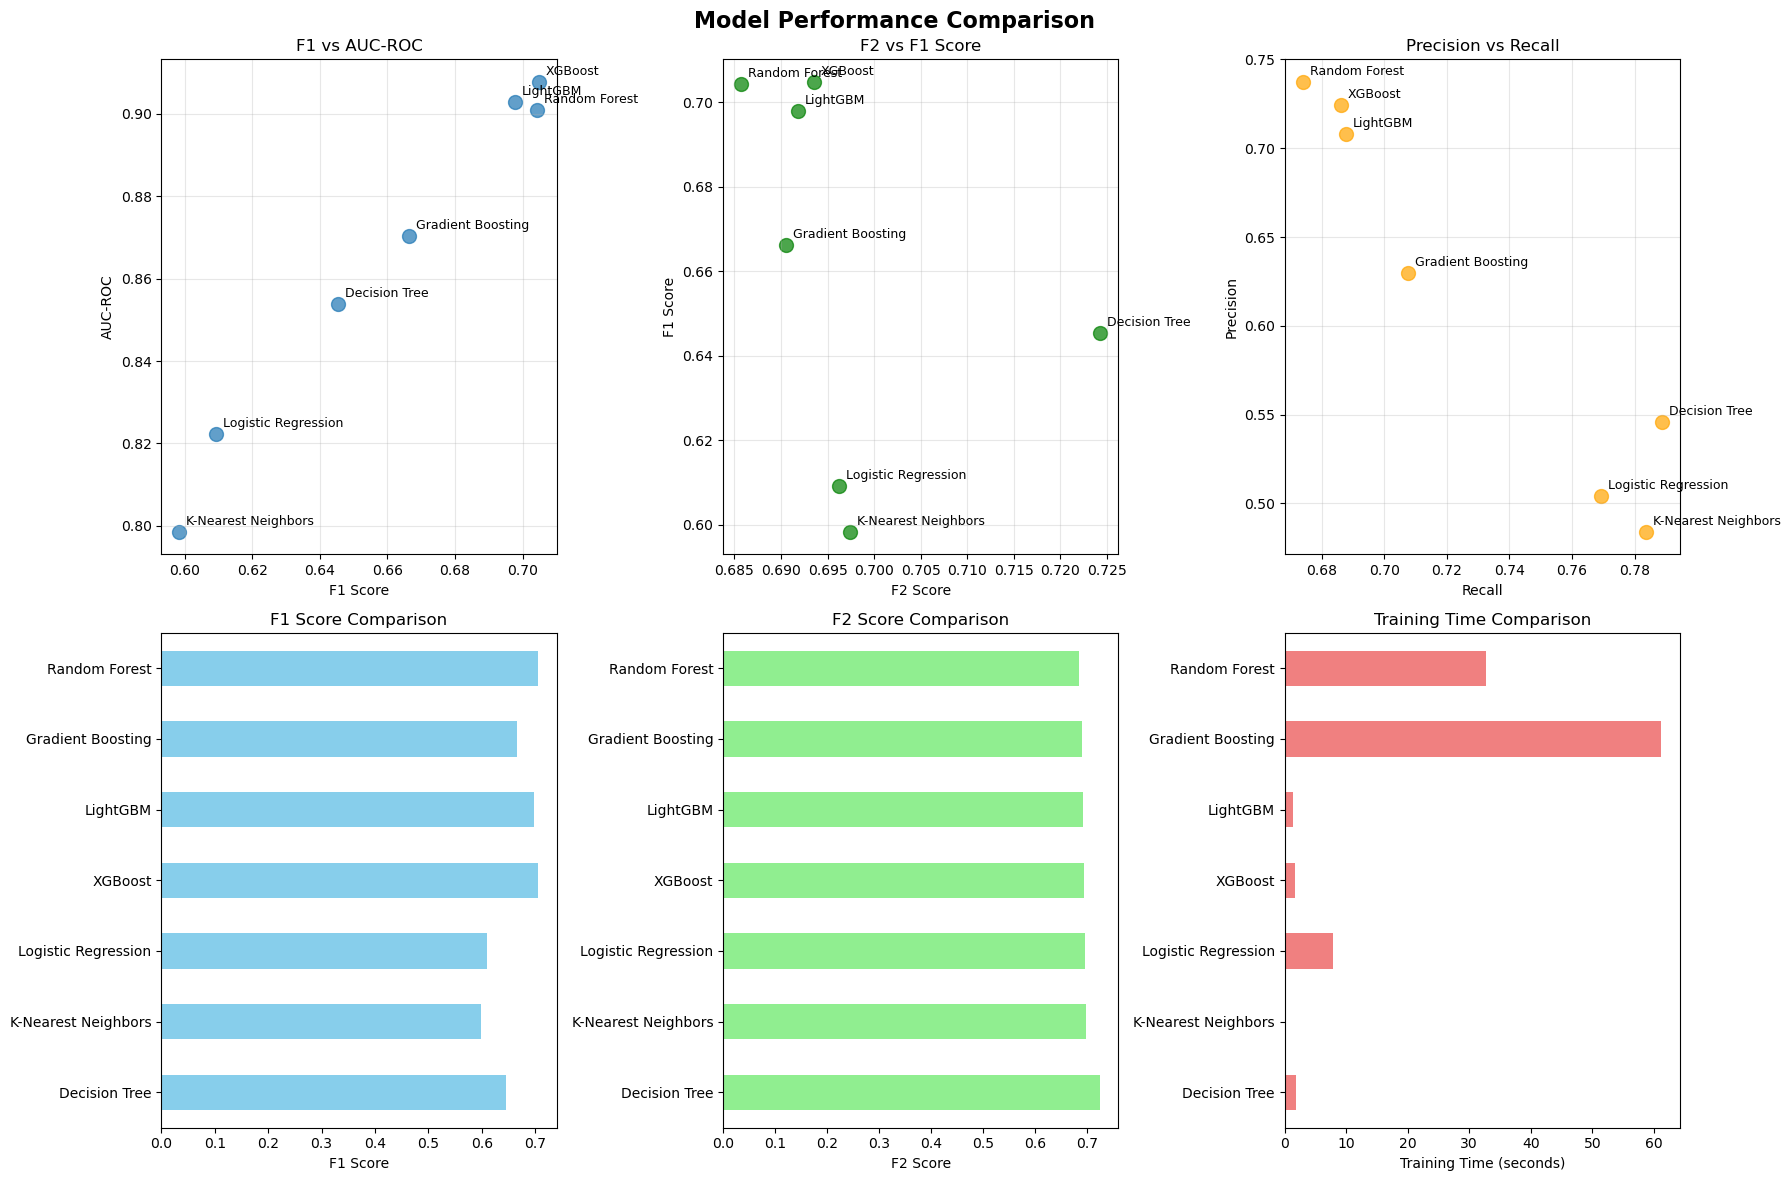

In [22]:
# CELL 16 : Performance Visualization - Metrics Comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# Subplot 1: F1 vs AUC scatter plot
axes[0,0].scatter(results_df['f1'], results_df['auc_roc'], s=100, alpha=0.7)
for i, model in enumerate(results_df.index):
    axes[0,0].annotate(model, (results_df.loc[model, 'f1'], results_df.loc[model, 'auc_roc']), 
                      xytext=(5, 5), textcoords='offset points', fontsize=9)
axes[0,0].set_xlabel('F1 Score')
axes[0,0].set_ylabel('AUC-ROC')
axes[0,0].set_title('F1 vs AUC-ROC')
axes[0,0].grid(True, alpha=0.3)

# Subplot 2: F2 vs F1 scatter plot
axes[0,1].scatter(results_df['f2'], results_df['f1'], s=100, alpha=0.7, color='green')
for i, model in enumerate(results_df.index):
    axes[0,1].annotate(model, (results_df.loc[model, 'f2'], results_df.loc[model, 'f1']), 
                      xytext=(5, 5), textcoords='offset points', fontsize=9)
axes[0,1].set_xlabel('F2 Score')
axes[0,1].set_ylabel('F1 Score')
axes[0,1].set_title('F2 vs F1 Score')
axes[0,1].grid(True, alpha=0.3)

# Subplot 3: Precision vs Recall
axes[0,2].scatter(results_df['recall'], results_df['precision'], s=100, alpha=0.7, color='orange')
for i, model in enumerate(results_df.index):
    axes[0,2].annotate(model, (results_df.loc[model, 'recall'], results_df.loc[model, 'precision']), 
                      xytext=(5, 5), textcoords='offset points', fontsize=9)
axes[0,2].set_xlabel('Recall')
axes[0,2].set_ylabel('Precision')
axes[0,2].set_title('Precision vs Recall')
axes[0,2].grid(True, alpha=0.3)

# Subplot 4: F1 Score comparison
results_df['f1'].plot(kind='barh', ax=axes[1,0], color='skyblue')
axes[1,0].set_title('F1 Score Comparison')
axes[1,0].set_xlabel('F1 Score')

# Subplot 5: F2 Score comparison
results_df['f2'].plot(kind='barh', ax=axes[1,1], color='lightgreen')
axes[1,1].set_title('F2 Score Comparison')
axes[1,1].set_xlabel('F2 Score')

# Subplot 6: Training Time comparison
results_df['train_time'].plot(kind='barh', ax=axes[1,2], color='lightcoral')
axes[1,2].set_title('Training Time Comparison')
axes[1,2].set_xlabel('Training Time (seconds)')

plt.tight_layout()
plt.show()

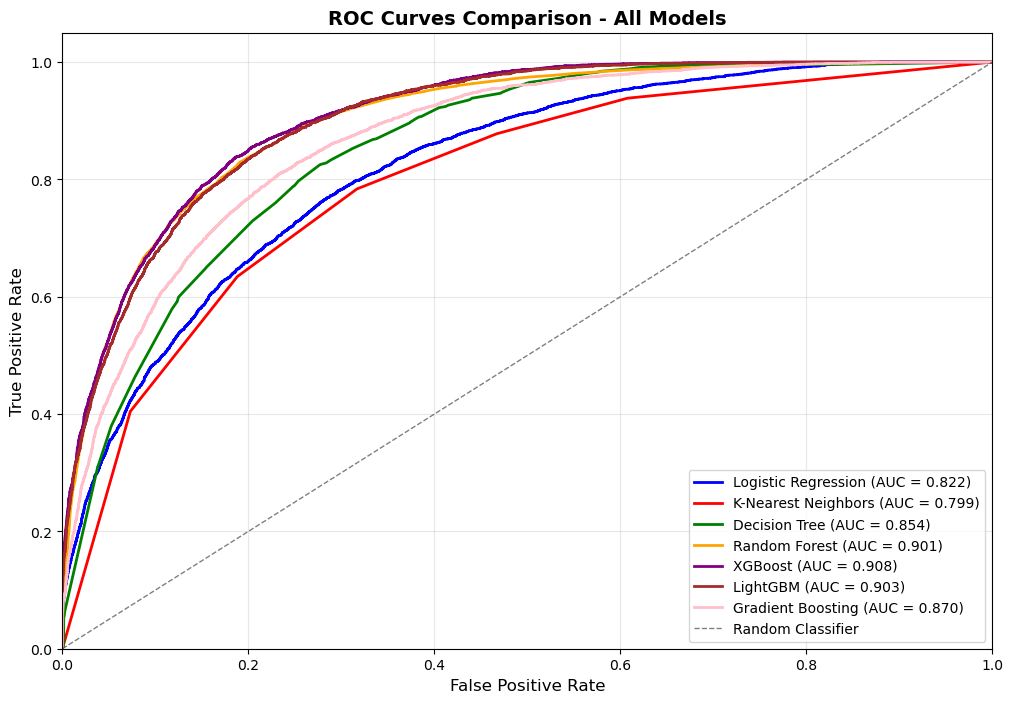

ROC curves plotted for all models
Higher AUC values indicate better model performance


In [23]:
# CELL 17 : ROC Curves Comparison
plt.figure(figsize=(12, 8))

colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']

for i, (name, model) in enumerate(models.items()):
    if name in all_probabilities:
        fpr, tpr, _ = roc_curve(y_test_processed, all_probabilities[name])
        auc_score = all_results[name]['auc_roc']
        
        plt.plot(fpr, tpr, color=colors[i % len(colors)], 
                label=f'{name} (AUC = {auc_score:.3f})', linewidth=2)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison - All Models', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

print("ROC curves plotted for all models")
print("Higher AUC values indicate better model performance")

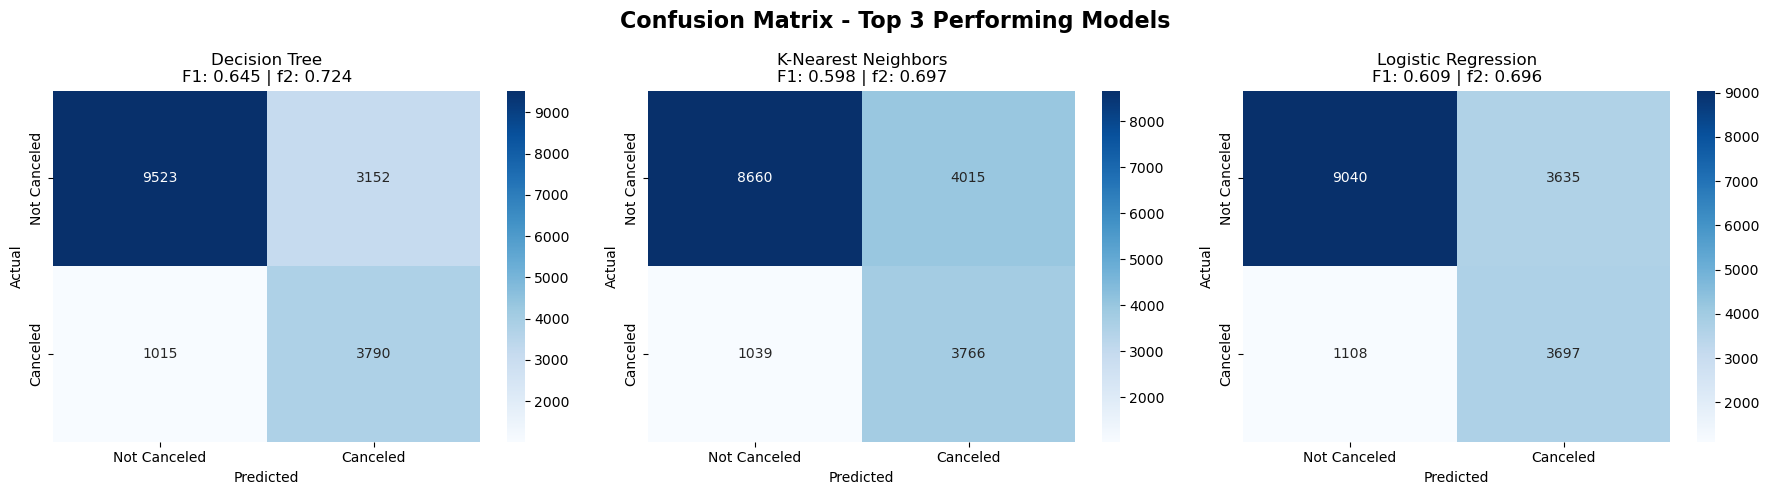

CONFUSION MATRIX ANALYSIS - Decision Tree
True Negatives (TN): 9523
False Positives (FP): 3152
False Negatives (FN): 1015
True Positives (TP): 3790
Total Predictions: 17480

PERFORMANCE METRICS:
F1 Score: 0.6453
F2 Score: 0.7243
Precision: 0.5460
Recall: 0.7888
AUC-ROC: 0.8539


In [24]:
# CELL 18 : Confusion Matrix for Top 3 Models
top_3_models = results_df.head(3).index.tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrix - Top 3 Performing Models', fontsize=16, fontweight='bold')

for i, model_name in enumerate(top_3_models):
    if model_name in all_predictions:
        cm = confusion_matrix(y_test_processed, all_predictions[model_name])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                   xticklabels=['Not Canceled', 'Canceled'],
                   yticklabels=['Not Canceled', 'Canceled'])

        axes[i].set_title(f'{model_name}\nF1: {all_results[model_name]["f1"]:.3f} | f2: {all_results[model_name]["f2"]:.3f}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Calculate confusion matrix metrics for best model
best_model = top_3_models[0]
cm = confusion_matrix(y_test_processed, all_predictions[best_model])
tn, fp, fn, tp = cm.ravel()

print(f"CONFUSION MATRIX ANALYSIS - {best_model}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")
print(f"Total Predictions: {tn + fp + fn + tp}")
print(f"\nPERFORMANCE METRICS:")
print(f"F1 Score: {all_results[best_model]['f1']:.4f}")
print(f"F2 Score: {all_results[best_model]['f2']:.4f}")
print(f"Precision: {all_results[best_model]['precision']:.4f}")
print(f"Recall: {all_results[best_model]['recall']:.4f}")
print(f"AUC-ROC: {all_results[best_model]['auc_roc']:.4f}")

In [25]:
# CELL 19 : F0.5 Score Analysis - Detailed Comparison
print("F0.5 SCORE DETAILED ANALYSIS")
print("="*50)
print("F0.5 score gives more weight to precision than recall")
print("Useful when false positives are more costly than false negatives")
print()

# Create F2 focused comparison
f2_comparison = results_df[['precision', 'recall', 'f1', 'f2', 'auc_roc']].copy()
f2_comparison = f2_comparison.sort_values('f2', ascending=False)

print("MODELS RANKED BY F2 SCORE:")
print(f2_comparison.round(4))

# F2 vs F1 difference analysis
f2_comparison['f1_f2_diff'] = f2_comparison['f1'] - f2_comparison['f2']
f2_comparison['precision_recall_ratio'] = f2_comparison['precision'] / f2_comparison['recall']

print("\nF2 vs F1 SCORE DIFFERENCE:")
print("Positive diff: F1 > F2 (model favors recall)")
print("Negative diff: F2 > F1 (model favors precision)")
print()
for model in f2_comparison.index:
    diff = f2_comparison.loc[model, 'f1_f2_diff']
    ratio = f2_comparison.loc[model, 'precision_recall_ratio']
    if diff > 0:
        bias = "Recall-favored"
    else:
        bias = "Precision-favored"
    print(f"{model}: {diff:+.4f} ({bias}) | P/R Ratio: {ratio:.2f}")

# Best F2 model
best_f2_model = f2_comparison.index[0]
print(f"\nBEST F2 MODEL: {best_f2_model}")
print(f"F2 Score: {f2_comparison.loc[best_f2_model, 'f2']:.4f}")
print(f"Precision: {f2_comparison.loc[best_f2_model, 'precision']:.4f}")
print(f"Recall: {f2_comparison.loc[best_f2_model, 'recall']:.4f}")

if best_f2_model != results_df.index[0]:
    print(f"\nNOTE: Best F2 model ({best_f2_model}) differs from best F1 model ({results_df.index[0]})")
    print("Consider business requirements: precision vs recall trade-off")

F0.5 SCORE DETAILED ANALYSIS
F0.5 score gives more weight to precision than recall
Useful when false positives are more costly than false negatives

MODELS RANKED BY F2 SCORE:
                     precision  recall      f1      f2  auc_roc
Decision Tree           0.5460  0.7888  0.6453  0.7243   0.8539
K-Nearest Neighbors     0.4840  0.7838  0.5984  0.6974   0.7986
Logistic Regression     0.5042  0.7694  0.6092  0.6962   0.8224
XGBoost                 0.7245  0.6862  0.7048  0.6935   0.9077
LightGBM                0.7082  0.6878  0.6978  0.6918   0.9029
Gradient Boosting       0.6295  0.7076  0.6663  0.6905   0.8704
Random Forest           0.7374  0.6739  0.7042  0.6857   0.9008

F2 vs F1 SCORE DIFFERENCE:
Positive diff: F1 > F2 (model favors recall)
Negative diff: F2 > F1 (model favors precision)

Decision Tree: -0.0790 (Precision-favored) | P/R Ratio: 0.69
K-Nearest Neighbors: -0.0990 (Precision-favored) | P/R Ratio: 0.62
Logistic Regression: -0.0870 (Precision-favored) | P/R Ratio: 

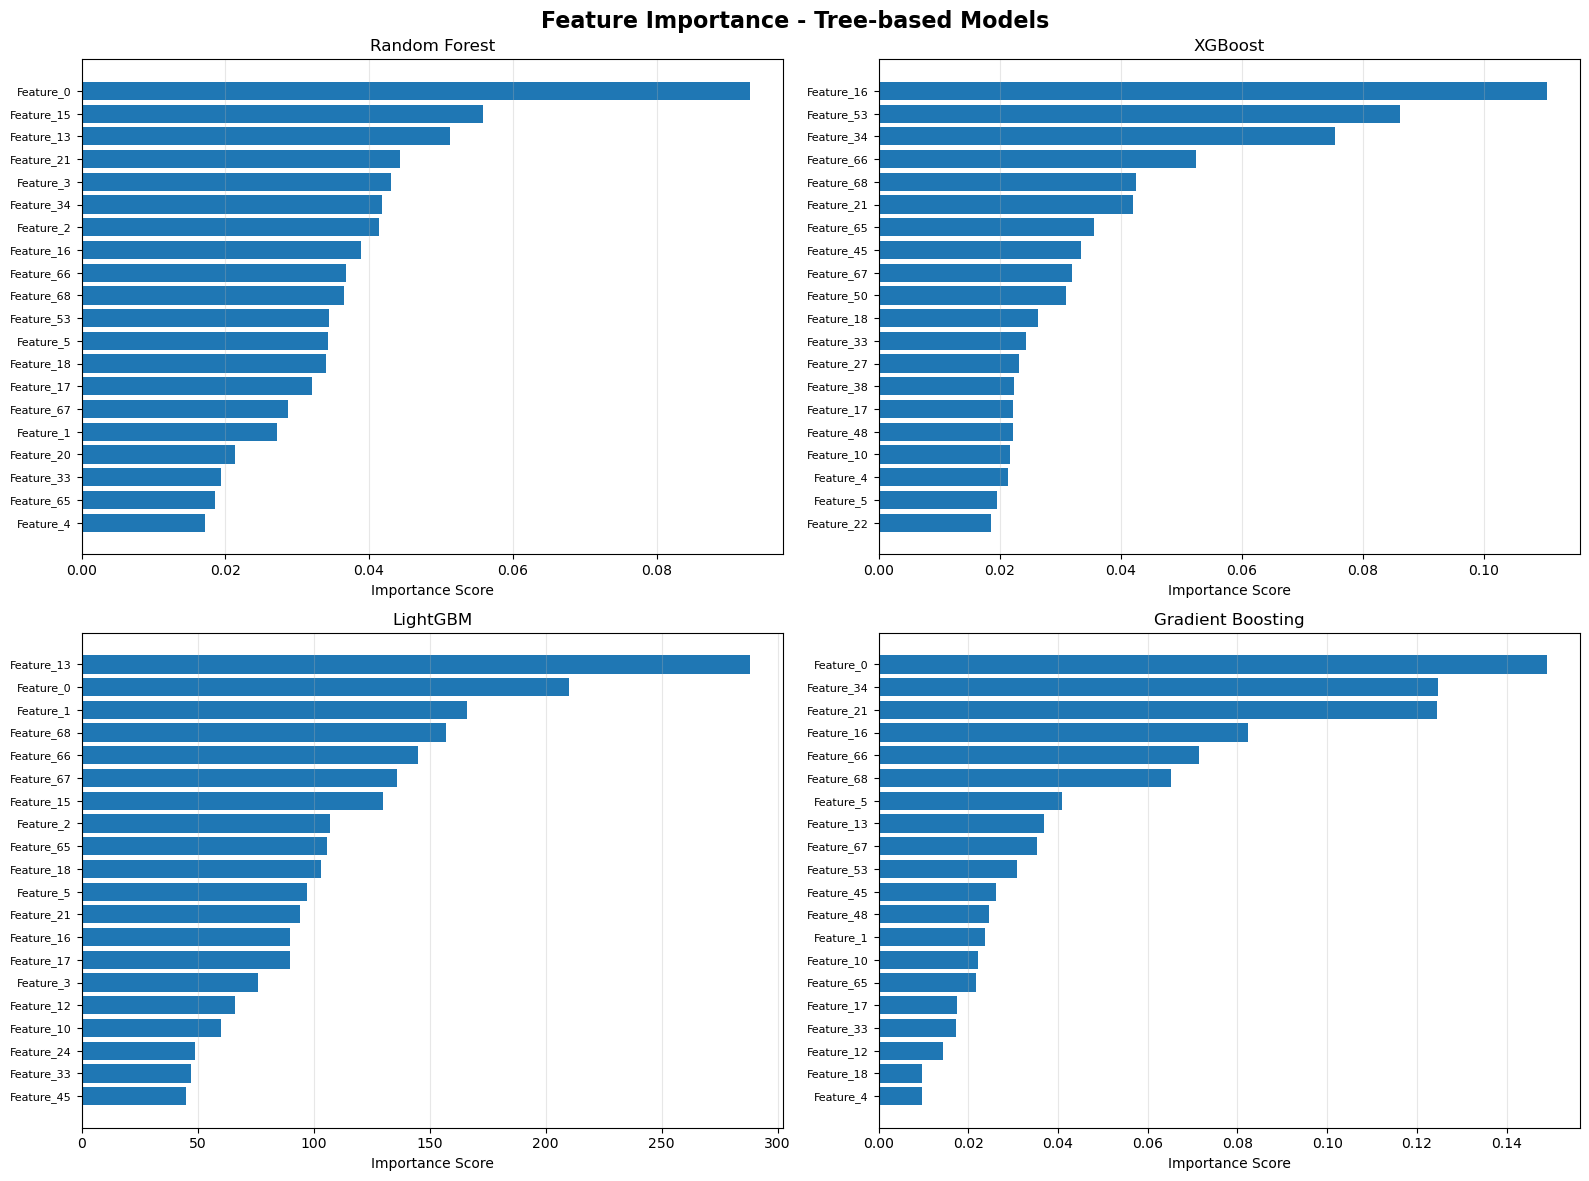

Feature importance analysis completed for tree-based models
Top 20 most important features displayed for each model


In [26]:
# CELL 20 : Feature Importance Analysis for Tree-based Models
tree_models = ['Random Forest', 'XGBoost', 'LightGBM', 'Gradient Boosting']
available_tree_models = [name for name in tree_models if name in models.keys()]

if available_tree_models:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()
    
    fig.suptitle('Feature Importance - Tree-based Models', fontsize=16, fontweight='bold')
    
    for i, model_name in enumerate(available_tree_models[:4]):
        if hasattr(models[model_name], 'feature_importances_'):
            # Get feature importance
            importance = models[model_name].feature_importances_
            
            # Get top 20 features
            feature_indices = np.argsort(importance)[-20:]
            feature_names = [f'Feature_{j}' for j in feature_indices]
            feature_values = importance[feature_indices]
            
            # Plot
            axes[i].barh(range(len(feature_values)), feature_values)
            axes[i].set_yticks(range(len(feature_values)))
            axes[i].set_yticklabels(feature_names, fontsize=8)
            axes[i].set_xlabel('Importance Score')
            axes[i].set_title(f'{model_name}')
            axes[i].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("Feature importance analysis completed for tree-based models")
    print("Top 20 most important features displayed for each model")
else:
    print("No tree-based models available for feature importance analysis")

In [27]:
# CELL 21 : Business Impact Analysis
def calculate_business_metrics(y_true, y_pred, cost_fp=100, cost_fn=500, revenue_tp=200):
    """
    Calculate business impact metrics : 
    Cost of false positive (unnecessary retention efforts)
    cost_fn: Cost of false negative (lost customer)
    revenue_tp: Revenue from prevented cancellation
    """
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    total_cost = (fp * cost_fp) + (fn * cost_fn)
    total_revenue = tp * revenue_tp
    net_benefit = total_revenue - total_cost
    
    return {
        'total_cost': total_cost,
        'total_revenue': total_revenue,
        'net_benefit': net_benefit,
        'cost_per_customer': total_cost / len(y_true),
        'revenue_per_customer': total_revenue / len(y_true),
        'net_benefit_per_customer': net_benefit / len(y_true)
    }

print("BUSINESS IMPACT ANALYSIS")
print("="*50)
print("Assumptions:")
print("  - False Positive Cost: $100 (unnecessary retention effort)")
print("  - False Negative Cost: $500 (lost customer)")
print("  - True Positive Revenue: $200 (prevented cancellation)")
print()

business_results = {}
for model_name in top_3_models:
    if model_name in all_predictions:
        business_metrics = calculate_business_metrics(
            y_test_processed, all_predictions[model_name]
        )
        business_results[model_name] = business_metrics

# Display business results
business_df = pd.DataFrame(business_results).T
business_df = business_df.round(2)

print("BUSINESS METRICS COMPARISON (Top 3 Models)")
print(business_df)

# Best model from business perspective
best_business_model = business_df['net_benefit'].idxmax()
print(f"\nBEST MODEL FOR BUSINESS: {best_business_model}")
print(f"Net Benefit: ${business_df.loc[best_business_model, 'net_benefit']:,.2f}")
print(f"Net Benefit per Customer: ${business_df.loc[best_business_model, 'net_benefit_per_customer']:.2f}")

BUSINESS IMPACT ANALYSIS
Assumptions:
  - False Positive Cost: $100 (unnecessary retention effort)
  - False Negative Cost: $500 (lost customer)
  - True Positive Revenue: $200 (prevented cancellation)

BUSINESS METRICS COMPARISON (Top 3 Models)
                     total_cost  total_revenue  net_benefit  \
Decision Tree          822700.0       758000.0     -64700.0   
K-Nearest Neighbors    921000.0       753200.0    -167800.0   
Logistic Regression    917500.0       739400.0    -178100.0   

                     cost_per_customer  revenue_per_customer  \
Decision Tree                    47.07                 43.36   
K-Nearest Neighbors              52.69                 43.09   
Logistic Regression              52.49                 42.30   

                     net_benefit_per_customer  
Decision Tree                           -3.70  
K-Nearest Neighbors                     -9.60  
Logistic Regression                    -10.19  

BEST MODEL FOR BUSINESS: Decision Tree
Net Benefit:

## Advanced Model Benchmarking dengan ROC-AUC Analysis

In [33]:
# CELL 22 : Comprehensive Benchmarking - Model Performance Summary
print("COMPREHENSIVE MODEL BENCHMARKING")
print("="*60)

# Create comprehensive benchmark table
benchmark_metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1_Score': [],
    'F2_Score': [],
    'ROC_AUC': [],
    'Train_Time': []
}

# Populate benchmark data
for model_name in results_df.index:
    benchmark_metrics['Model'].append(model_name)
    benchmark_metrics['Accuracy'].append(all_results[model_name]['accuracy'])
    benchmark_metrics['Precision'].append(all_results[model_name]['precision'])
    benchmark_metrics['Recall'].append(all_results[model_name]['recall'])
    benchmark_metrics['F1_Score'].append(all_results[model_name]['f1'])
    benchmark_metrics['F2_Score'].append(all_results[model_name]['f2'])
    benchmark_metrics['ROC_AUC'].append(all_results[model_name]['auc_roc'])
    benchmark_metrics['Train_Time'].append(all_results[model_name]['train_time'])

benchmark_df = pd.DataFrame(benchmark_metrics)
benchmark_df = benchmark_df.round(4)

print("COMPLETE BENCHMARK RESULTS:")
print(benchmark_df.to_string(index=False))

COMPREHENSIVE MODEL BENCHMARKING
COMPLETE BENCHMARK RESULTS:
              Model  Accuracy  Precision  Recall  F1_Score  F2_Score  ROC_AUC  Train_Time
      Decision Tree    0.7616     0.5460  0.7888    0.6453    0.7243   0.8539      1.9139
K-Nearest Neighbors    0.7109     0.4840  0.7838    0.5984    0.6974   0.7986      0.0182
Logistic Regression    0.7287     0.5042  0.7694    0.6092    0.6962   0.8224      7.7779
            XGBoost    0.8420     0.7245  0.6862    0.7048    0.6935   0.9077      1.6380
           LightGBM    0.8363     0.7082  0.6878    0.6978    0.6918   0.9029      1.3030
  Gradient Boosting    0.8051     0.6295  0.7076    0.6663    0.6905   0.8704     61.1932
      Random Forest    0.8444     0.7374  0.6739    0.7042    0.6857   0.9008     32.7607


### Decision Tree: Model Terbaik dari Perspektif Bisnis

Net Benefit Terkecil (Kerugian Paling Rendah) :
- Decision Tree menghasilkan kerugian paling kecil: $-64,700 dibanding model lain.
- Walaupun masih negatif, ini menunjukkan bahwa model ini paling efektif dalam menekan kerugian akibat pembatalan.

Interpretasi Bisnis:
- Setiap pelanggan yang diproses oleh Decision Tree menghasilkan kerugian yang jauh lebih kecil dibanding model lain.
- Ini menunjukkan bahwa model ini lebih efisien secara unit ekonomi pelanggan.

In [34]:
# CELL 23 : ROC-AUC Deep Analysis with Statistical Significance
from scipy import stats
import numpy as np

print("ROC-AUC STATISTICAL ANALYSIS")
print("="*40)

# Calculate AUC confidence intervals using bootstrap
def bootstrap_auc(y_true, y_scores, n_bootstrap=1000):
    """Calculate bootstrap confidence interval for AUC"""
    n_samples = len(y_true)
    auc_scores = []
    
    for _ in range(n_bootstrap):
        # Bootstrap sample
        indices = np.random.choice(n_samples, n_samples, replace=True)
        y_true_boot = y_true.iloc[indices] if hasattr(y_true, 'iloc') else y_true[indices]
        y_scores_boot = y_scores[indices]
        
        # Calculate AUC for bootstrap sample
        auc_boot = roc_auc_score(y_true_boot, y_scores_boot)
        auc_scores.append(auc_boot)
    
    # Calculate confidence interval
    ci_lower = np.percentile(auc_scores, 2.5)
    ci_upper = np.percentile(auc_scores, 97.5)
    
    return ci_lower, ci_upper

# Calculate AUC confidence intervals
auc_analysis = {}
for model_name in all_probabilities.keys():
    auc_score = all_results[model_name]['auc_roc']
    ci_lower, ci_upper = bootstrap_auc(y_test_processed, all_probabilities[model_name])
    
    auc_analysis[model_name] = {
        'AUC': auc_score,
        'CI_Lower': ci_lower,
        'CI_Upper': ci_upper,
        'CI_Width': ci_upper - ci_lower
    }

# Create AUC analysis DataFrame
auc_df = pd.DataFrame(auc_analysis).T
auc_df = auc_df.round(4)
auc_df = auc_df.sort_values('AUC', ascending=False)

print("AUC SCORES WITH 95% CONFIDENCE INTERVALS:")
for model in auc_df.index:
    auc = auc_df.loc[model, 'AUC']
    ci_lower = auc_df.loc[model, 'CI_Lower']
    ci_upper = auc_df.loc[model, 'CI_Upper']
    print(f"{model:20s}: {auc:.4f} [{ci_lower:.4f} - {ci_upper:.4f}]")

print(f"\nMODEL WITH HIGHEST AUC: {auc_df.index[0]} ({auc_df.iloc[0]['AUC']:.4f})")
print(f"MODEL WITH NARROWEST CI: {auc_df.loc[auc_df['CI_Width'].idxmin()].name} (width: {auc_df['CI_Width'].min():.4f})")

ROC-AUC STATISTICAL ANALYSIS
AUC SCORES WITH 95% CONFIDENCE INTERVALS:
XGBoost             : 0.9077 [0.9033 - 0.9124]
LightGBM            : 0.9029 [0.8983 - 0.9074]
Random Forest       : 0.9008 [0.8958 - 0.9058]
Gradient Boosting   : 0.8704 [0.8647 - 0.8757]
Decision Tree       : 0.8539 [0.8483 - 0.8596]
Logistic Regression : 0.8224 [0.8154 - 0.8289]
K-Nearest Neighbors : 0.7986 [0.7918 - 0.8057]

MODEL WITH HIGHEST AUC: XGBoost (0.9077)
MODEL WITH NARROWEST CI: LightGBM (width: 0.0090)


In [37]:
# CELL 24 : Cross-Validation Deep Dive - 5-Fold Stratified Analysis
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, fbeta_score
import pandas as pd

print("CROSS-VALIDATION COMPREHENSIVE ANALYSIS")
print("="*50)

# Verify models dictionary exists
if 'models' not in locals() and 'models' not in globals():
    print("ERROR: 'models' dictionary not found. Please run CELL 12 first.")
else:
    # Perform detailed cross-validation for all models
    cv_detailed_results = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define F2 scorer
    f2_scorer = make_scorer(fbeta_score, beta=2)
    
    # Metrics to evaluate in CV - Using F2 Score as primary metric
    cv_metrics = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'f2': f2_scorer,  # Custom F2 scorer
        'roc_auc': 'roc_auc'
    }
    
    for model_name, model in models.items():
        print(f"Running detailed CV for {model_name}...")
        
        cv_scores = {}
        for metric_name, scorer in cv_metrics.items():
            scores = cross_val_score(model, X_train_processed, y_train_processed, 
                                   cv=cv, scoring=scorer)
            cv_scores[metric_name] = {
                'mean': scores.mean(),
                'std': scores.std(),
                'min': scores.min(),
                'max': scores.max(),
                'scores': scores
            }
        
        cv_detailed_results[model_name] = cv_scores
    
    # Create summary table for CV results
    cv_summary = []
    for model_name in cv_detailed_results.keys():
        row = {'Model': model_name}
        for metric in ['accuracy', 'precision', 'recall', 'f1', 'f2', 'roc_auc']:
            mean_score = cv_detailed_results[model_name][metric]['mean']
            std_score = cv_detailed_results[model_name][metric]['std']
            row[f'{metric.upper()}_Mean'] = mean_score
            row[f'{metric.upper()}_Std'] = std_score
            row[f'{metric.upper()}_Range'] = f"{mean_score:.3f} ± {std_score:.3f}"
        cv_summary.append(row)
    
    cv_summary_df = pd.DataFrame(cv_summary)
    cv_summary_df = cv_summary_df.round(4)
    
    print("\nCROSS-VALIDATION SUMMARY (5-Fold Stratified):")
    print(cv_summary_df[['Model', 'F2_Range', 'F1_Range', 'ROC_AUC_Range', 'ACCURACY_Range']].to_string(index=False))
    
    # Best performing model by CV F2 (Primary Metric)
    best_cv_f2_model = cv_summary_df.loc[cv_summary_df['F2_Mean'].idxmax(), 'Model']
    best_cv_f1_model = cv_summary_df.loc[cv_summary_df['F1_Mean'].idxmax(), 'Model']
    best_cv_auc_model = cv_summary_df.loc[cv_summary_df['ROC_AUC_Mean'].idxmax(), 'Model']
    
    print(f"\nBEST CV F2 MODEL (Primary): {best_cv_f2_model}")
    print(f"  F2 Score: {cv_summary_df.loc[cv_summary_df['F2_Mean'].idxmax(), 'F2_Mean']:.4f} ± {cv_summary_df.loc[cv_summary_df['F2_Mean'].idxmax(), 'F2_Std']:.4f}")
    print(f"\nBEST CV F1 MODEL: {best_cv_f1_model}")
    print(f"  F1 Score: {cv_summary_df.loc[cv_summary_df['F1_Mean'].idxmax(), 'F1_Mean']:.4f} ± {cv_summary_df.loc[cv_summary_df['F1_Mean'].idxmax(), 'F1_Std']:.4f}")
    print(f"\nBEST CV AUC MODEL: {best_cv_auc_model}")
    print(f"  ROC-AUC: {cv_summary_df.loc[cv_summary_df['ROC_AUC_Mean'].idxmax(), 'ROC_AUC_Mean']:.4f} ± {cv_summary_df.loc[cv_summary_df['ROC_AUC_Mean'].idxmax(), 'ROC_AUC_Std']:.4f}")
    
    # Model stability analysis (low std = more stable)
    stability_analysis = cv_summary_df[['Model', 'F2_Std', 'F1_Std', 'ROC_AUC_Std']].copy()
    stability_analysis['Combined_Std'] = stability_analysis['F2_Std'] + stability_analysis['F1_Std'] + stability_analysis['ROC_AUC_Std']
    most_stable_model = stability_analysis.loc[stability_analysis['Combined_Std'].idxmin(), 'Model']
    
    print(f"\nMOST STABLE MODEL: {most_stable_model}")
    print(f"  Combined Std: {stability_analysis['Combined_Std'].min():.4f}")
    print(f"  F2 Std: {stability_analysis.loc[stability_analysis['Combined_Std'].idxmin(), 'F2_Std']:.4f}")
    
    print("\nNOTE: F2 Score emphasizes recall over precision (beta=2)")
    print("This is optimal for minimizing false negatives in cancellation prediction")


CROSS-VALIDATION COMPREHENSIVE ANALYSIS
Running detailed CV for Logistic Regression...
Running detailed CV for K-Nearest Neighbors...
Running detailed CV for K-Nearest Neighbors...
Running detailed CV for Decision Tree...
Running detailed CV for Decision Tree...
Running detailed CV for Random Forest...
Running detailed CV for Random Forest...
Running detailed CV for XGBoost...
Running detailed CV for XGBoost...
Running detailed CV for LightGBM...
Running detailed CV for LightGBM...
Running detailed CV for Gradient Boosting...
Running detailed CV for Gradient Boosting...

CROSS-VALIDATION SUMMARY (5-Fold Stratified):
              Model      F2_Range      F1_Range ROC_AUC_Range ACCURACY_Range
Logistic Regression 0.775 ± 0.002 0.759 ± 0.002 0.834 ± 0.003  0.750 ± 0.002
K-Nearest Neighbors 0.891 ± 0.000 0.828 ± 0.001 0.897 ± 0.002  0.806 ± 0.002
      Decision Tree 0.853 ± 0.012 0.825 ± 0.004 0.898 ± 0.001  0.815 ± 0.001
      Random Forest 0.900 ± 0.002 0.901 ± 0.002 0.965 ± 0.001  0.901

ADVANCED ROC CURVE ANALYSIS


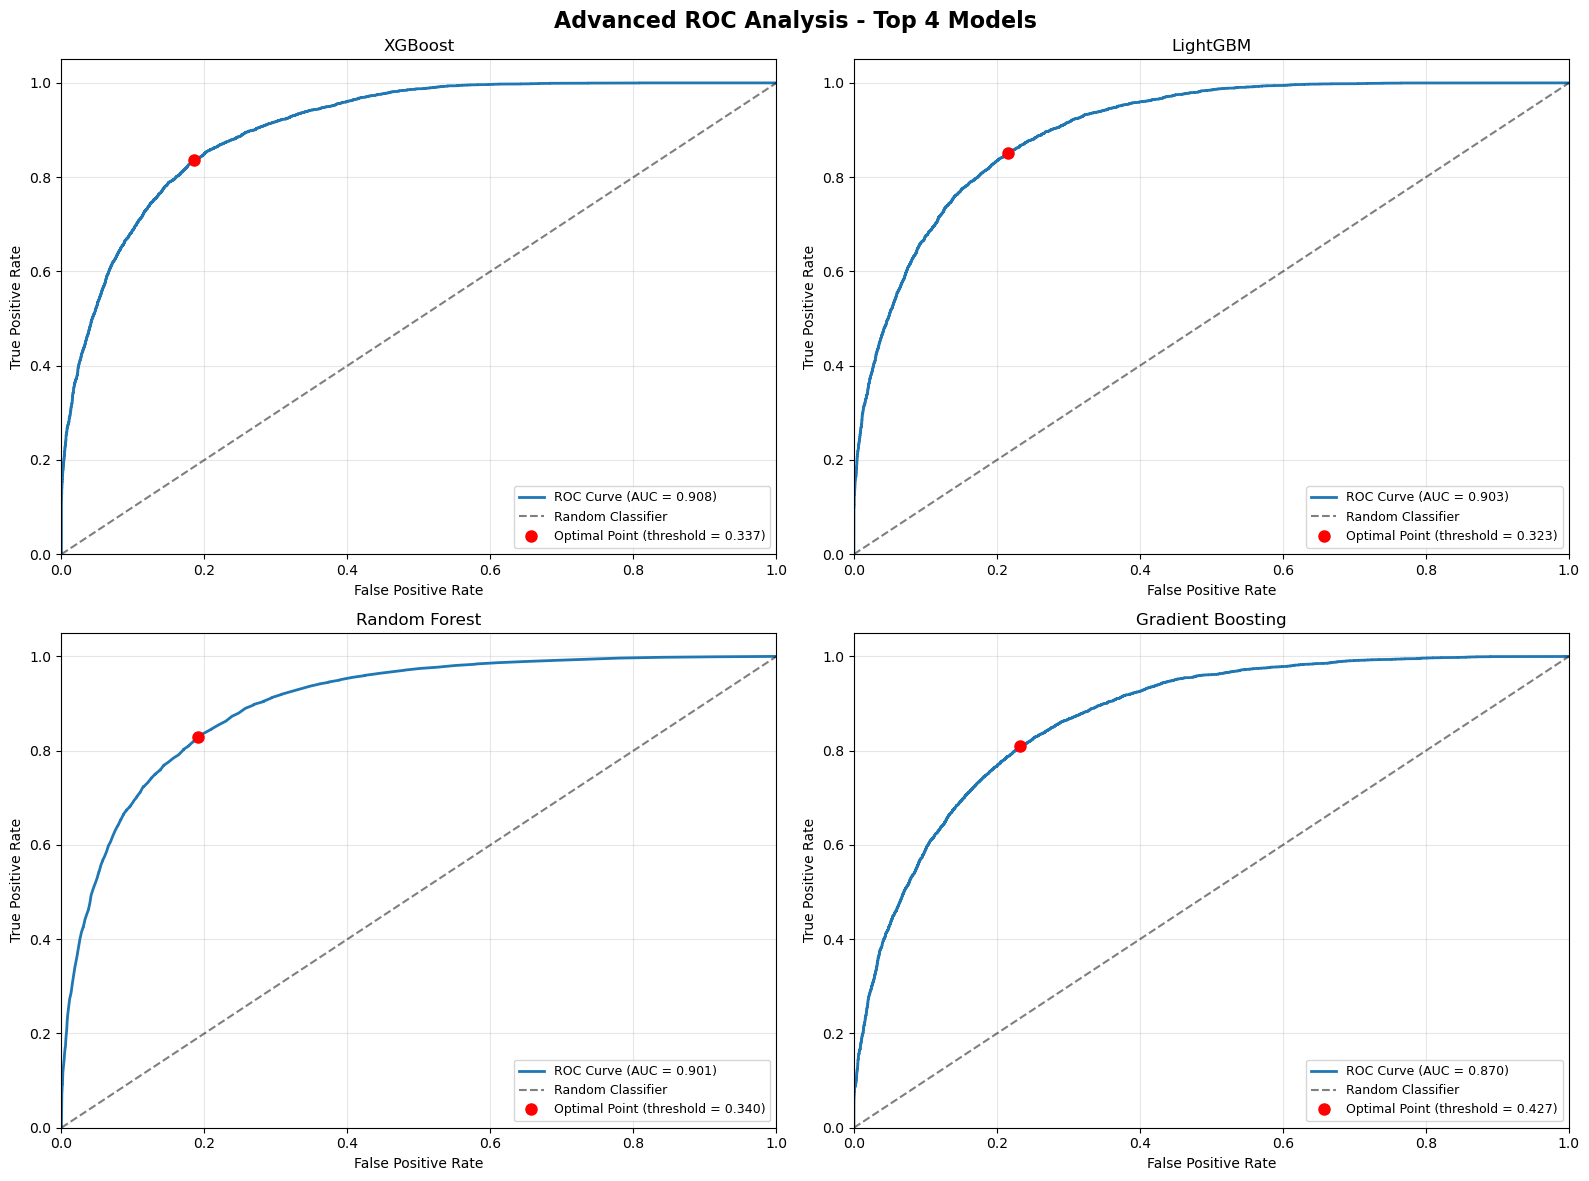


OPTIMAL THRESHOLDS (Youden's J Statistic):
XGBoost             : 0.3368 (J=0.6515, TPR=0.8366, FPR=0.1852)
LightGBM            : 0.3229 (J=0.6368, TPR=0.8522, FPR=0.2155)
Random Forest       : 0.3400 (J=0.6386, TPR=0.8296, FPR=0.1909)
Gradient Boosting   : 0.4267 (J=0.5769, TPR=0.8094, FPR=0.2325)

PERFORMANCE AT OPTIMAL THRESHOLDS:
XGBoost             : Precision=0.6314, Recall=0.8366, F1=0.7197
LightGBM            : Precision=0.5999, Recall=0.8522, F1=0.7042
Random Forest       : Precision=0.6222, Recall=0.8296, F1=0.7111
Gradient Boosting   : Precision=0.5689, Recall=0.8094, F1=0.6682
Random Forest       : Precision=0.6222, Recall=0.8296, F1=0.7111
Gradient Boosting   : Precision=0.5689, Recall=0.8094, F1=0.6682


In [38]:
# CELL 25 : Advanced ROC Curve Analysis with Optimal Thresholds
print("ADVANCED ROC CURVE ANALYSIS")
print("="*35)

# Calculate optimal thresholds using Youden's J statistic
optimal_thresholds = {}

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Advanced ROC Analysis - Top 4 Models', fontsize=16, fontweight='bold')

# Get top 4 models by AUC
top_4_auc_models = auc_df.head(4).index.tolist()

for i, model_name in enumerate(top_4_auc_models):
    ax = axes[i//2, i%2]
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_processed, all_probabilities[model_name])
    auc_score = auc_df.loc[model_name, 'AUC']
    
    # Find optimal threshold using Youden's J statistic
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_fpr = fpr[optimal_idx]
    optimal_tpr = tpr[optimal_idx]
    
    optimal_thresholds[model_name] = {
        'threshold': optimal_threshold,
        'fpr': optimal_fpr,
        'tpr': optimal_tpr,
        'j_score': j_scores[optimal_idx]
    }
    
    # Plot ROC curve
    ax.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
    
    # Mark optimal point
    ax.plot(optimal_fpr, optimal_tpr, 'ro', markersize=8, 
            label=f'Optimal Point (threshold = {optimal_threshold:.3f})')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{model_name}')
    ax.legend(loc="lower right", fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display optimal thresholds
print("\nOPTIMAL THRESHOLDS (Youden's J Statistic):")
for model_name, threshold_info in optimal_thresholds.items():
    threshold = threshold_info['threshold']
    j_score = threshold_info['j_score']
    tpr = threshold_info['tpr']
    fpr = threshold_info['fpr']
    print(f"{model_name:20s}: {threshold:.4f} (J={j_score:.4f}, TPR={tpr:.4f}, FPR={fpr:.4f})")

# Calculate performance at optimal thresholds
print("\nPERFORMANCE AT OPTIMAL THRESHOLDS:")
for model_name in optimal_thresholds.keys():
    threshold = optimal_thresholds[model_name]['threshold']
    y_pred_optimal = (all_probabilities[model_name] >= threshold).astype(int)
    
    precision_opt = precision_score(y_test_processed, y_pred_optimal)
    recall_opt = recall_score(y_test_processed, y_pred_optimal)
    f1_opt = f1_score(y_test_processed, y_pred_optimal)
    
    print(f"{model_name:20s}: Precision={precision_opt:.4f}, Recall={recall_opt:.4f}, F1={f1_opt:.4f}")

In [40]:
# CELL 26 : Model Ranking System - Multi-Criteria Decision Analysis
print("MULTI-CRITERIA MODEL RANKING")
print("="*40)

# Create comprehensive ranking based on multiple criteria
ranking_criteria = {
    'F1_Score': 0.25,        # Primary metric for imbalanced data
    'ROC_AUC': 0.25,         # Discrimination ability
    'F2_Score': 0.15,        # FN-focused metric
    'CV_Stability': 0.15,    # Cross-validation consistency
    'Training_Speed': 0.10,  # Computational efficiency
    'Precision': 0.10        # False positive control
}

# Normalize metrics for ranking (0-1 scale)
ranking_data = {}

for model_name in results_df.index:
    ranking_data[model_name] = {
        'F1_Score': all_results[model_name]['f1'],
        'ROC_AUC': all_results[model_name]['auc_roc'],
        'F2_Score': all_results[model_name]['f2'],
        'CV_Stability': 1 / (1 + all_results[model_name]['cv_f1_std']),  # Higher is better (lower std)
        'Training_Speed': 1 / (1 + all_results[model_name]['train_time']),  # Higher is better (lower time)
        'Precision': all_results[model_name]['precision']
    }

# Convert to DataFrame and normalize
ranking_df = pd.DataFrame(ranking_data).T

# Normalize each metric to 0-1 scale
for column in ranking_df.columns:
    min_val = ranking_df[column].min()
    max_val = ranking_df[column].max()
    ranking_df[f'{column}_norm'] = (ranking_df[column] - min_val) / (max_val - min_val)

# Calculate weighted composite score
ranking_df['Composite_Score'] = 0
for criterion, weight in ranking_criteria.items():
    ranking_df['Composite_Score'] += ranking_df[f'{criterion}_norm'] * weight

# Sort by composite score
ranking_df = ranking_df.sort_values('Composite_Score', ascending=False)

print("COMPREHENSIVE MODEL RANKING:")
print("Criteria Weights:", ranking_criteria)
print()

# Display ranking results
for i, (model_name, row) in enumerate(ranking_df.iterrows(), 1):
    score = row['Composite_Score']
    f1 = row['F1_Score']
    auc = row['ROC_AUC']
    f2 = row['F2_Score']
    print(f"{i}. {model_name:20s}: Score={score:.4f} (F1={f1:.3f}, AUC={auc:.3f}, F2={f2:.3f})")

# Final recommendation
best_overall_model = ranking_df.index[0]
print(f"\nFINAL RECOMMENDATION: {best_overall_model}")
print(f"Composite Score: {ranking_df.loc[best_overall_model, 'Composite_Score']:.4f}")

# Comparison with other ranking methods
print(f"\nRANKING COMPARISON:")
print(f"Best by F1 Score: {results_df.index[0]}")
print(f"Best by AUC Score: {auc_df.index[0]}")
print(f"Best by F2 Score: {f2_comparison.index[0]}")
print(f"Best by Composite: {best_overall_model}")

if len(set([results_df.index[0], auc_df.index[0], f2_comparison.index[0], best_overall_model])) == 1:
    print("\nCONSENSUS: All ranking methods agree on the best model!")
else:
    print("\nDIVERGENCE: Different ranking methods suggest different best models")
    print("Consider business requirements and deployment constraints")

MULTI-CRITERIA MODEL RANKING
COMPREHENSIVE MODEL RANKING:
Criteria Weights: {'F1_Score': 0.25, 'ROC_AUC': 0.25, 'F2_Score': 0.15, 'CV_Stability': 0.15, 'Training_Speed': 0.1, 'Precision': 0.1}

1. XGBoost             : Score=0.8127 (F1=0.705, AUC=0.908, F2=0.693)
2. LightGBM            : Score=0.7439 (F1=0.698, AUC=0.903, F2=0.692)
3. Random Forest       : Score=0.6786 (F1=0.704, AUC=0.901, F2=0.686)
4. Gradient Boosting   : Score=0.5088 (F1=0.666, AUC=0.870, F2=0.690)
5. Decision Tree       : Score=0.4452 (F1=0.645, AUC=0.854, F2=0.724)
6. K-Nearest Neighbors : Score=0.2926 (F1=0.598, AUC=0.799, F2=0.697)
7. Logistic Regression : Score=0.2614 (F1=0.609, AUC=0.822, F2=0.696)

FINAL RECOMMENDATION: XGBoost
Composite Score: 0.8127

RANKING COMPARISON:
Best by F1 Score: Decision Tree
Best by AUC Score: XGBoost
Best by F2 Score: Decision Tree
Best by Composite: XGBoost

DIVERGENCE: Different ranking methods suggest different best models
Consider business requirements and deployment constra

PERFORMANCE HEATMAP ANALYSIS


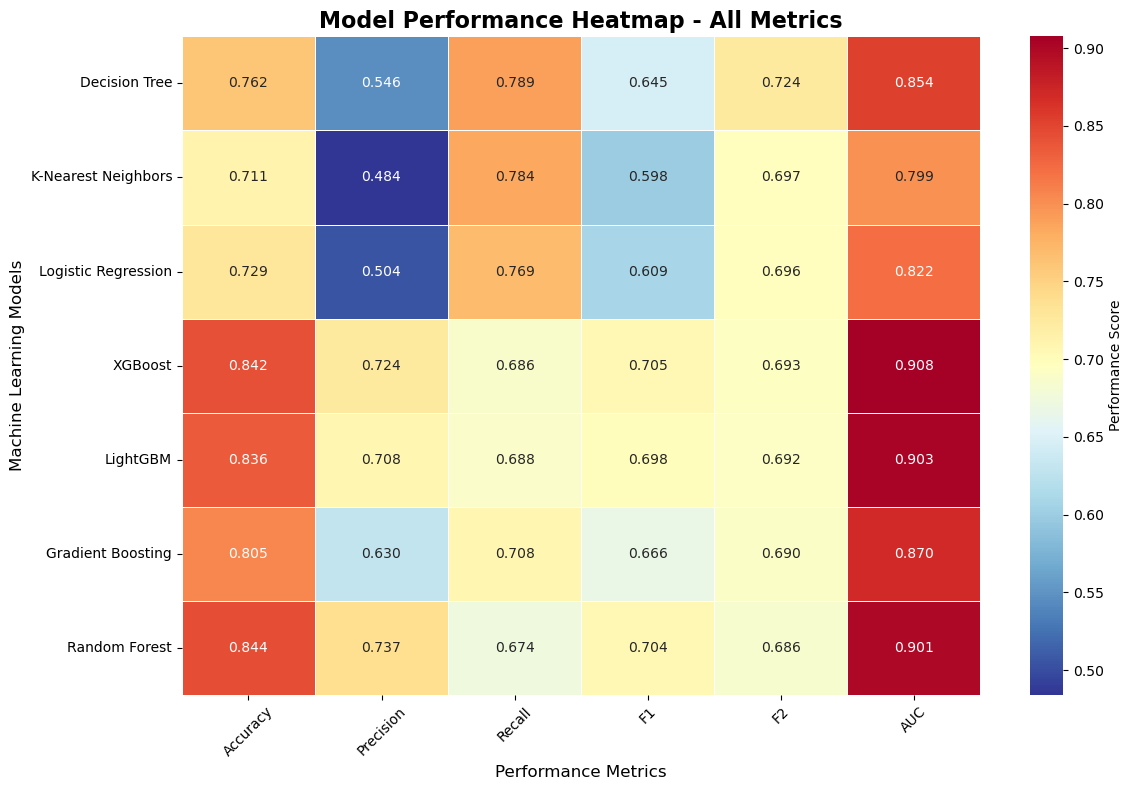


PERFORMANCE STATISTICS ACROSS ALL MODELS:
Mean Performance by Metric:
Accuracy     0.7898
Precision    0.6191
Recall       0.7282
F1           0.6609
F2           0.6971
AUC          0.8652
dtype: float64

Standard Deviation by Metric:
Accuracy     0.0561
Precision    0.1080
Recall       0.0504
F1           0.0447
F2           0.0126
AUC          0.0427
dtype: float64

Best Model per Metric:
Accuracy    : Random Forest (0.8444)
Precision   : Random Forest (0.7374)
Recall      : Decision Tree (0.7888)
F1          : XGBoost (0.7048)
F2          : Decision Tree (0.7243)
AUC         : XGBoost (0.9077)

MODEL CONSISTENCY ANALYSIS:
Most Consistent Model: XGBoost (ratio: 9.00)
Highest Mean Performance: XGBoost (0.7598)
Lowest Variability: Gradient Boosting (std: 0.0832)


In [41]:
# CELL 27 : Performance Heatmap Visualization
print("PERFORMANCE HEATMAP ANALYSIS")
print("="*35)

# Create performance matrix for heatmap
performance_matrix = []
metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'F2', 'AUC']

for model_name in results_df.index:
    performance_row = [
        all_results[model_name]['accuracy'],
        all_results[model_name]['precision'],
        all_results[model_name]['recall'],
        all_results[model_name]['f1'],
        all_results[model_name]['f2'],
        all_results[model_name]['auc_roc']
    ]
    performance_matrix.append(performance_row)

performance_array = np.array(performance_matrix)

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(performance_array, 
            xticklabels=metrics_labels,
            yticklabels=results_df.index,
            annot=True, 
            fmt='.3f',
            cmap='RdYlBu_r',
            cbar_kws={'label': 'Performance Score'},
            linewidths=0.5)

plt.title('Model Performance Heatmap - All Metrics', fontsize=16, fontweight='bold')
plt.xlabel('Performance Metrics', fontsize=12)
plt.ylabel('Machine Learning Models', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Statistical summary
print("\nPERFORMANCE STATISTICS ACROSS ALL MODELS:")
perf_stats = pd.DataFrame(performance_matrix, 
                         columns=metrics_labels, 
                         index=results_df.index)

print("Mean Performance by Metric:")
print(perf_stats.mean().round(4))
print("\nStandard Deviation by Metric:")
print(perf_stats.std().round(4))
print("\nBest Model per Metric:")
for metric in metrics_labels:
    best_model = perf_stats[metric].idxmax()
    best_score = perf_stats[metric].max()
    print(f"{metric:12s}: {best_model} ({best_score:.4f})")

# Model consistency analysis
print(f"\nMODEL CONSISTENCY ANALYSIS:")
perf_stats['Mean_Score'] = perf_stats.mean(axis=1)
perf_stats['Std_Score'] = perf_stats.std(axis=1)
perf_stats['Consistency_Ratio'] = perf_stats['Mean_Score'] / perf_stats['Std_Score']

most_consistent = perf_stats['Consistency_Ratio'].idxmax()
print(f"Most Consistent Model: {most_consistent} (ratio: {perf_stats.loc[most_consistent, 'Consistency_Ratio']:.2f})")
print(f"Highest Mean Performance: {perf_stats['Mean_Score'].idxmax()} ({perf_stats['Mean_Score'].max():.4f})")
print(f"Lowest Variability: {perf_stats['Std_Score'].idxmin()} (std: {perf_stats['Std_Score'].min():.4f})")

### Test Oversampling with K-Fold Cross Validation ###

Algorithma yang digunakan :

1. **SMOTE (Synthetic Minority Over-sampling Technique)**
- Membuat data sintetis dengan cara interpolasi antara sampel minoritas dan tetangganya.
- Menambahkan variasi pada data minoritas.
- Tidak mempertimbangkan tingkat kesulitan klasifikasi.
- Cocok untuk data yang terdistribusi stabil dan tidak terlalu kompleks.

2. **ADASYN (Adaptive Synthetic Sampling)**
- Merupakan pengembangan dari SMOTE.
- Fokus pada area yang sulit diklasifikasi, yaitu di mana data minoritas jarang dan dekat dengan mayoritas.
- Membuat lebih banyak sampel sintetis di area yang kompleks.
- Cocok untuk data yang tidak seimbang secara lokal.

3. **RandomOversampler**
- Teknik paling sederhana: hanya menggandakan sampel minoritas secara acak.
- Tidak membuat data sintetis, hanya duplikasi.
- Tidak menambah variasi, sehingga bisa menyebabkan overfitting.
- Cocok untuk baseline atau ketika model tidak terlalu sensitif terhadap duplikasi.


In [43]:
# Import Additional Libraries for Oversampling Methods
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import StratifiedKFold
from scipy import stats
import numpy as np

# Configure Oversampling Methods
oversampling_methods = {
    'SMOTE': SMOTE(random_state=42, k_neighbors=5),
    'RandomOverSampler': RandomOverSampler(random_state=42),
    'ADASYN': ADASYN(random_state=42, n_neighbors=5)
}

# Configure Models for Testing
test_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1)
}

print("OVERSAMPLING METHODS COMPARISON WITH K-FOLD CV")
print("="*55)
print(f"Oversampling methods: {list(oversampling_methods.keys())}")
print(f"Models for testing: {list(test_models.keys())}")
print(f"Cross-validation: 5-fold stratified")
print(f"Metrics: ROC-AUC, F1, F2, Precision, Recall, Accuracy")

OVERSAMPLING METHODS COMPARISON WITH K-FOLD CV
Oversampling methods: ['SMOTE', 'RandomOverSampler', 'ADASYN']
Models for testing: ['Logistic Regression', 'Decision Tree', 'XGBoost', 'LightGBM']
Cross-validation: 5-fold stratified
Metrics: ROC-AUC, F1, F2, Precision, Recall, Accuracy


In [46]:
# CELL 28 : K-Fold Cross Validation with Oversampling Function
def kfold_oversampling_evaluation(X, y, model, oversampling_method, cv_folds=5):
    """
    Robust K-Fold CV dengan oversampling hanya pada training fold
    Menggunakan F2 Score sebagai metrik utama untuk meminimalkan false negatives
    """
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    scores = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'f2': [],  # F2 Score - metrik utama
        'roc_auc': []
    }
    
    for train_idx, val_idx in cv.split(X, y):
        # Split data
        X_train_fold = X[train_idx] if isinstance(X, np.ndarray) else X.iloc[train_idx]
        X_val_fold = X[val_idx] if isinstance(X, np.ndarray) else X.iloc[val_idx]
        y_train_fold = y[train_idx] if isinstance(y, np.ndarray) else y.iloc[train_idx]
        y_val_fold = y[val_idx] if isinstance(y, np.ndarray) else y.iloc[val_idx]
        
        # Apply preprocessing
        X_train_processed = preprocessor.fit_transform(X_train_fold)
        X_val_processed = preprocessor.transform(X_val_fold)
        
        # Apply oversampling only on training fold
        X_train_balanced, y_train_balanced = oversampling_method.fit_resample(
            X_train_processed, y_train_fold
        )
        
        # Train model
        model.fit(X_train_balanced, y_train_balanced)
        
        # Predict on validation fold (original, unbalanced)
        y_pred = model.predict(X_val_processed)
        y_pred_proba = model.predict_proba(X_val_processed)[:, 1]
        
        # Calculate metrics with F2 Score (beta=2 for recall emphasis)
        scores['accuracy'].append(accuracy_score(y_val_fold, y_pred))
        scores['precision'].append(precision_score(y_val_fold, y_pred))
        scores['recall'].append(recall_score(y_val_fold, y_pred))
        scores['f1'].append(f1_score(y_val_fold, y_pred))
        scores['f2'].append(fbeta_score(y_val_fold, y_pred, beta=2))  # F2 Score
        scores['roc_auc'].append(roc_auc_score(y_val_fold, y_pred_proba))
    
    # Calculate statistics
    results = {}
    for metric, values in scores.items():
        results[f'{metric}_mean'] = np.mean(values)
        results[f'{metric}_std'] = np.std(values)
        results[f'{metric}_scores'] = values
    
    return results

print("K-Fold Cross Validation function defined")
print("Key features:")
print("- Oversampling applied only on training folds")
print("- Validation folds remain original (unbiased testing)")
print("- Prevents data leakage and overfitting")
print("- F2 Score as primary metric (emphasizes recall)")
print("- Comprehensive metrics: Accuracy, Precision, Recall, F1, F2, ROC-AUC")


K-Fold Cross Validation function defined
Key features:
- Oversampling applied only on training folds
- Validation folds remain original (unbiased testing)
- Prevents data leakage and overfitting
- F2 Score as primary metric (emphasizes recall)
- Comprehensive metrics: Accuracy, Precision, Recall, F1, F2, ROC-AUC


In [47]:
# CELL 29 : Execute K-Fold CV for All Combinations
print("EXECUTING K-FOLD CV WITH OVERSAMPLING")
print("="*45)

cv_results_comprehensive = {}

for oversample_name, oversample_method in oversampling_methods.items():
    print(f"\nTesting {oversample_name}...")
    cv_results_comprehensive[oversample_name] = {}
    
    for model_name, model in test_models.items():
        print(f"  - {model_name}")
        
        try:
            results = kfold_oversampling_evaluation(
                X_train, y_train, model, oversample_method
            )
            cv_results_comprehensive[oversample_name][model_name] = results
            
        except Exception as e:
            print(f"    Error: {str(e)}")
            continue

print(f"\nCompleted CV evaluation for:")
print(f"- {len(oversampling_methods)} oversampling methods")
print(f"- {len(test_models)} machine learning models")
print(f"- Total combinations: {len(oversampling_methods) * len(test_models)}")

EXECUTING K-FOLD CV WITH OVERSAMPLING

Testing SMOTE...
  - Logistic Regression
  - Decision Tree
  - Decision Tree
  - XGBoost
  - XGBoost
  - LightGBM
  - LightGBM

Testing RandomOverSampler...
  - Logistic Regression

Testing RandomOverSampler...
  - Logistic Regression
  - Decision Tree
  - Decision Tree
  - XGBoost
  - XGBoost
  - LightGBM
  - LightGBM

Testing ADASYN...
  - Logistic Regression

Testing ADASYN...
  - Logistic Regression
  - Decision Tree
  - Decision Tree
  - XGBoost
  - XGBoost
  - LightGBM
  - LightGBM

Completed CV evaluation for:
- 3 oversampling methods
- 4 machine learning models
- Total combinations: 12

Completed CV evaluation for:
- 3 oversampling methods
- 4 machine learning models
- Total combinations: 12


In [48]:
# CELL 30 : Results Analysis - Performance Comparison Table
print("OVERSAMPLING METHODS COMPARISON RESULTS")
print("="*50)

# Create comprehensive results table
comparison_data = []
for oversample_name in cv_results_comprehensive.keys():
    for model_name in cv_results_comprehensive[oversample_name].keys():
        results = cv_results_comprehensive[oversample_name][model_name]
        
        row = {
            'Oversampling': oversample_name,
            'Model': model_name,
            'ROC_AUC': f"{results['roc_auc_mean']:.4f} ± {results['roc_auc_std']:.4f}",
            'F1': f"{results['f1_mean']:.4f} ± {results['f1_std']:.4f}",
            'F2': f"{results['f2_mean']:.4f} ± {results['f2_std']:.4f}",
            'Precision': f"{results['precision_mean']:.4f} ± {results['precision_std']:.4f}",
            'Recall': f"{results['recall_mean']:.4f} ± {results['recall_std']:.4f}",
            'Accuracy': f"{results['accuracy_mean']:.4f} ± {results['accuracy_std']:.4f}",
            'AUC_Score': results['roc_auc_mean'],
            'F1_Score': results['f1_mean'],
            'F2_Score': results['f2_mean']
        }
        comparison_data.append(row)

# Create DataFrame and sort by F2 score
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('F2_Score', ascending=False)

print("COMPLETE RESULTS TABLE (Sorted by F2 Score):")
display_cols = ['Oversampling', 'Model', 'ROC_AUC', 'F1', 'F2', 'Precision', 'Recall', 'Accuracy']
print(comparison_df[display_cols].to_string(index=False))

# Top performers
print(f"\nTOP 3 COMBINATIONS BY F2 SCORE:")
for i, (idx, row) in enumerate(comparison_df.head(3).iterrows(), 1):
    print(f"{i}. {row['Oversampling']} + {row['Model']}: F2={row['F2_Score']:.4f}")

print(f"\nTOP 3 COMBINATIONS BY ROC-AUC:")
top_auc = comparison_df.sort_values('AUC_Score', ascending=False).head(3)
for i, (idx, row) in enumerate(top_auc.iterrows(), 1):
    print(f"{i}. {row['Oversampling']} + {row['Model']}: AUC={row['AUC_Score']:.4f}")

OVERSAMPLING METHODS COMPARISON RESULTS
COMPLETE RESULTS TABLE (Sorted by F2 Score):
     Oversampling               Model         ROC_AUC              F1              F2       Precision          Recall        Accuracy
RandomOverSampler            LightGBM 0.9074 ± 0.0033 0.7121 ± 0.0048 0.7912 ± 0.0076 0.6105 ± 0.0029 0.8544 ± 0.0103 0.8101 ± 0.0025
RandomOverSampler             XGBoost 0.9085 ± 0.0029 0.7181 ± 0.0045 0.7869 ± 0.0046 0.6267 ± 0.0047 0.8407 ± 0.0051 0.8185 ± 0.0031
           ADASYN Logistic Regression 0.8259 ± 0.0055 0.6105 ± 0.0077 0.7100 ± 0.0088 0.4950 ± 0.0065 0.7965 ± 0.0097 0.7206 ± 0.0057
RandomOverSampler Logistic Regression 0.8300 ± 0.0058 0.6147 ± 0.0071 0.7028 ± 0.0077 0.5085 ± 0.0065 0.7771 ± 0.0083 0.7322 ± 0.0055
            SMOTE Logistic Regression 0.8292 ± 0.0056 0.6154 ± 0.0074 0.6985 ± 0.0084 0.5136 ± 0.0063 0.7675 ± 0.0093 0.7363 ± 0.0052
            SMOTE             XGBoost 0.9066 ± 0.0024 0.7071 ± 0.0040 0.6963 ± 0.0050 0.7259 ± 0.0042 0.6893 ± 

In [50]:
# Cell 31 : Statistical Analysis - Confidence Intervals
print("STATISTICAL ANALYSIS WITH CONFIDENCE INTERVALS")
print("="*50)

# Calculate 95% confidence intervals for each combination
def calculate_confidence_interval(scores, confidence=0.95):
    """Calculate confidence interval for scores"""
    n = len(scores)
    mean = np.mean(scores)
    std_err = stats.sem(scores)
    margin_error = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)
    return mean - margin_error, mean + margin_error

# Statistical summary for top performers
statistical_summary = []
for oversample_name in cv_results_comprehensive.keys():
    for model_name in cv_results_comprehensive[oversample_name].keys():
        results = cv_results_comprehensive[oversample_name][model_name]
        
        # Calculate confidence intervals
        f2_ci = calculate_confidence_interval(results['f2_scores'])
        f1_ci = calculate_confidence_interval(results['f1_scores'])
        auc_ci = calculate_confidence_interval(results['roc_auc_scores'])
        
        summary = {
            'Combination': f"{oversample_name} + {model_name}",
            'F2_Mean': results['f2_mean'],
            'F2_CI_Lower': f2_ci[0],
            'F2_CI_Upper': f2_ci[1],
            'F1_Mean': results['f1_mean'],
            'F1_CI_Lower': f1_ci[0],
            'F1_CI_Upper': f1_ci[1],
            'AUC_Mean': results['roc_auc_mean'],
            'AUC_CI_Lower': auc_ci[0],
            'AUC_CI_Upper': auc_ci[1]
        }
        statistical_summary.append(summary)

# Create statistical DataFrame
stats_df = pd.DataFrame(statistical_summary)
stats_df = stats_df.sort_values('F2_Mean', ascending=False)

print("95% CONFIDENCE INTERVALS - TOP 5 BY F2:")
for i, (idx, row) in enumerate(stats_df.head(5).iterrows(), 1):
    f2_ci = f"[{row['F2_CI_Lower']:.4f} - {row['F2_CI_Upper']:.4f}]"
    auc_ci = f"[{row['AUC_CI_Lower']:.4f} - {row['AUC_CI_Upper']:.4f}]"
    print(f"{i}. {row['Combination']}")
    print(f"   F2: {row['F2_Mean']:.4f} {f2_ci}")
    print(f"   AUC:  {row['AUC_Mean']:.4f} {auc_ci}")

# Best overall combination
best_combination = stats_df.iloc[0]
print(f"\nBEST COMBINATION: {best_combination['Combination']}")
print(f"F2 Score: {best_combination['F2_Mean']:.4f} [{best_combination['F2_CI_Lower']:.4f} - {best_combination['F2_CI_Upper']:.4f}]")
print(f"Statistical significance: 95% confidence level")

STATISTICAL ANALYSIS WITH CONFIDENCE INTERVALS
95% CONFIDENCE INTERVALS - TOP 5 BY F2:
1. RandomOverSampler + LightGBM
   F2: 0.7912 [0.7807 - 0.8017]
   AUC:  0.9074 [0.9028 - 0.9120]
2. RandomOverSampler + XGBoost
   F2: 0.7869 [0.7805 - 0.7934]
   AUC:  0.9085 [0.9044 - 0.9126]
3. ADASYN + Logistic Regression
   F2: 0.7100 [0.6978 - 0.7222]
   AUC:  0.8259 [0.8182 - 0.8335]
4. RandomOverSampler + Logistic Regression
   F2: 0.7028 [0.6922 - 0.7134]
   AUC:  0.8300 [0.8220 - 0.8380]
5. SMOTE + Logistic Regression
   F2: 0.6985 [0.6868 - 0.7101]
   AUC:  0.8292 [0.8214 - 0.8370]

BEST COMBINATION: RandomOverSampler + LightGBM
F2 Score: 0.7912 [0.7807 - 0.8017]
Statistical significance: 95% confidence level


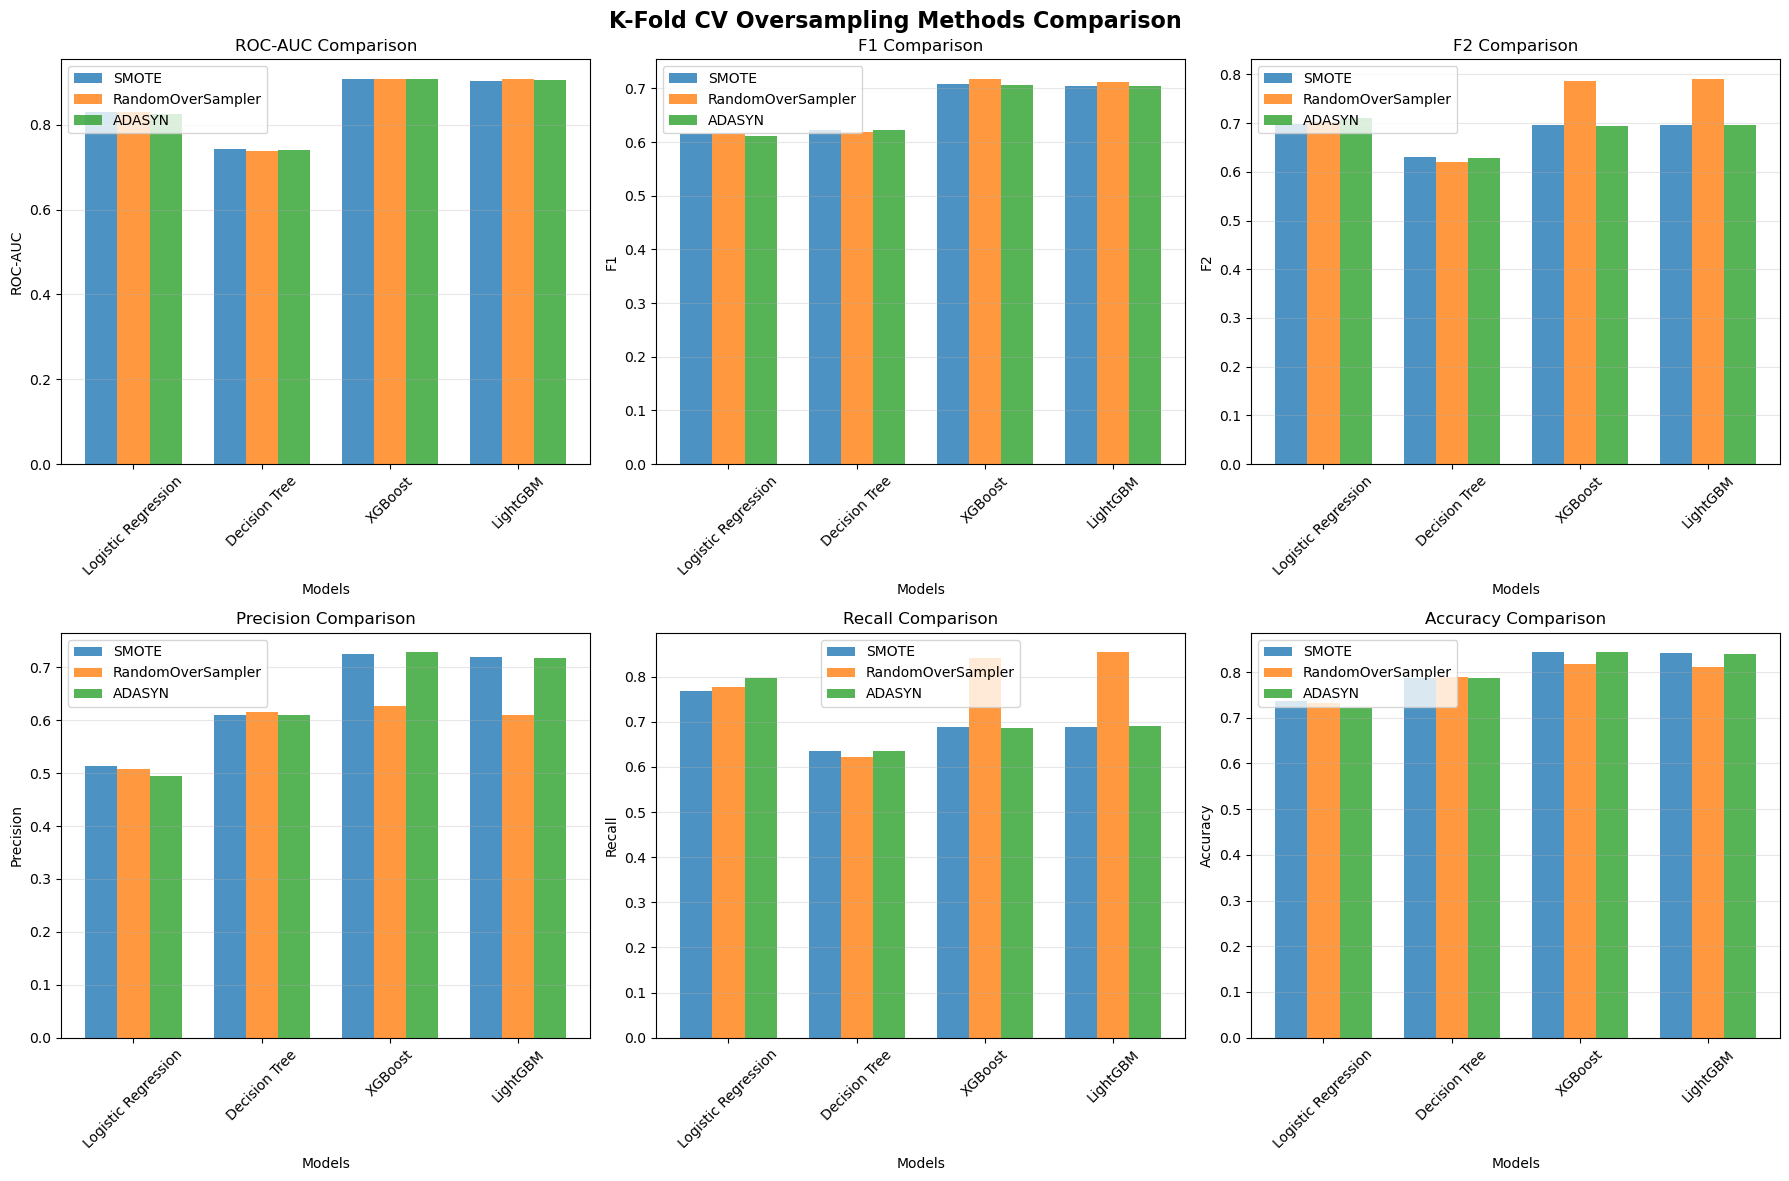

Performance comparison charts created
Key insights:
- Compare oversampling methods across all models
- F2 score emphasizes precision over recall
- Higher bars indicate better performance


In [51]:
# CELL 32 : Visualization - Performance Comparison Charts
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('K-Fold CV Oversampling Methods Comparison', fontsize=16, fontweight='bold')

# Create pivot tables for visualization
metrics = ['roc_auc_mean', 'f1_mean', 'f2_mean', 'precision_mean', 'recall_mean', 'accuracy_mean']
metric_names = ['ROC-AUC', 'F1', 'F2', 'Precision', 'Recall', 'Accuracy']

# Extract data for visualization
viz_data = {}
for metric in metrics:
    viz_data[metric] = {}
    for oversample_name in cv_results_comprehensive.keys():
        viz_data[metric][oversample_name] = []
        for model_name in test_models.keys():
            if model_name in cv_results_comprehensive[oversample_name]:
                value = cv_results_comprehensive[oversample_name][model_name][metric]
                viz_data[metric][oversample_name].append(value)

# Plot each metric
for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    ax = axes[i//3, i%3]
    
    # Create grouped bar plot
    x_pos = np.arange(len(test_models))
    width = 0.25
    
    for j, oversample_name in enumerate(oversampling_methods.keys()):
        if oversample_name in viz_data[metric]:
            values = viz_data[metric][oversample_name]
            ax.bar(x_pos + j*width, values, width, label=oversample_name, alpha=0.8)
    
    ax.set_xlabel('Models')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} Comparison')
    ax.set_xticks(x_pos + width)
    ax.set_xticklabels(list(test_models.keys()), rotation=45)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("Performance comparison charts created")
print("Key insights:")
print("- Compare oversampling methods across all models")
print("- F2 score emphasizes precision over recall")
print("- Higher bars indicate better performance")

### Penjelasan Hasil Oversampling ###

1. Model RandomOverSampler + LightGBM paling efektif dalam mendeteksi pembatalan (recall tinggi), sehingga mengurangi kerugian akibat FN.
2. Walaupun precision-nya lebih rendah, ini bisa ditoleransi karena False Positive (FP) memiliki dampak bisnis yang lebih kecil ($100).
3. Model dengan ROC-AUC tinggi memberikan kepercayaan lebih tinggi dalam pengambilan keputusan. Cocok untuk sistem rekomendasi atau alert kepada tim operasional hotel untuk mengantisipasi pembatalan.


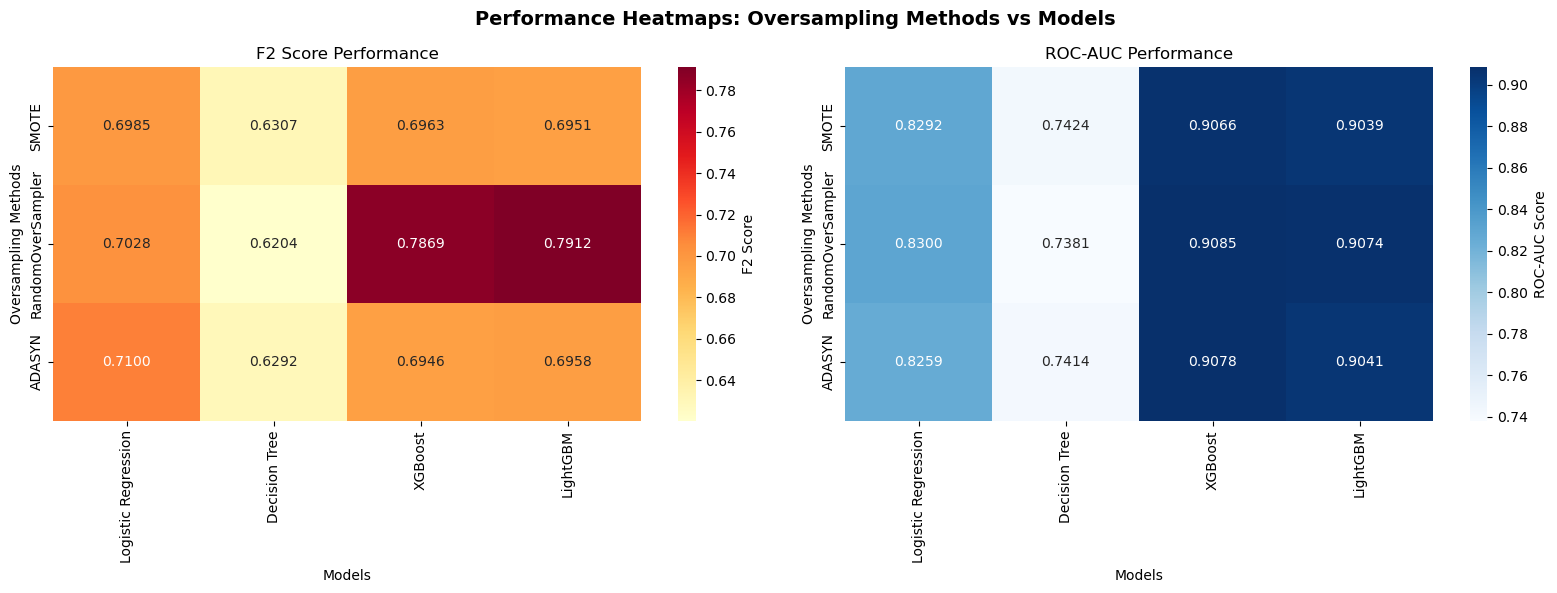

PERFORMANCE RANKING BY OVERSAMPLING METHOD:
1. RandomOverSampler: Avg F2=0.7253, Avg AUC=0.8460
2. ADASYN: Avg F2=0.6824, Avg AUC=0.8448
3. SMOTE: Avg F2=0.6802, Avg AUC=0.8455


In [52]:
# CELL 33 : Heatmap Visualization - F0.5 and ROC-AUC Performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Performance Heatmaps: Oversampling Methods vs Models', fontsize=14, fontweight='bold')

# F2 Score Heatmap
f2_matrix = []
auc_matrix = []

for oversample_name in oversampling_methods.keys():
    f2_row = []
    auc_row = []
    for model_name in test_models.keys():
        if model_name in cv_results_comprehensive[oversample_name]:
            f2_row.append(cv_results_comprehensive[oversample_name][model_name]['f2_mean'])
            auc_row.append(cv_results_comprehensive[oversample_name][model_name]['roc_auc_mean'])
        else:
            f2_row.append(0)
            auc_row.append(0)
    f2_matrix.append(f2_row)
    auc_matrix.append(auc_row)

# F2 Heatmap
sns.heatmap(f2_matrix, 
            xticklabels=list(test_models.keys()),
            yticklabels=list(oversampling_methods.keys()),
            annot=True, fmt='.4f', cmap='YlOrRd',
            ax=axes[0], cbar_kws={'label': 'F2 Score'})
axes[0].set_title('F2 Score Performance')
axes[0].set_xlabel('Models')
axes[0].set_ylabel('Oversampling Methods')

# ROC-AUC Heatmap
sns.heatmap(auc_matrix, 
            xticklabels=list(test_models.keys()),
            yticklabels=list(oversampling_methods.keys()),
            annot=True, fmt='.4f', cmap='Blues',
            ax=axes[1], cbar_kws={'label': 'ROC-AUC Score'})
axes[1].set_title('ROC-AUC Performance')
axes[1].set_xlabel('Models')
axes[1].set_ylabel('Oversampling Methods')

plt.tight_layout()
plt.show()

# Performance ranking by oversampling method
print("PERFORMANCE RANKING BY OVERSAMPLING METHOD:")
method_performance = {}
for oversample_name in oversampling_methods.keys():
    f2_scores = []
    auc_scores = []
    for model_name in test_models.keys():
        if model_name in cv_results_comprehensive[oversample_name]:
            f2_scores.append(cv_results_comprehensive[oversample_name][model_name]['f2_mean'])
            auc_scores.append(cv_results_comprehensive[oversample_name][model_name]['roc_auc_mean'])
    
    method_performance[oversample_name] = {
        'avg_f2': np.mean(f2_scores),
        'avg_auc': np.mean(auc_scores)
    }

# Sort by F2 performance
sorted_methods = sorted(method_performance.items(), key=lambda x: x[1]['avg_f2'], reverse=True)
for i, (method, scores) in enumerate(sorted_methods, 1):
    print(f"{i}. {method}: Avg F2={scores['avg_f2']:.4f}, Avg AUC={scores['avg_auc']:.4f}")

In [53]:
#CELL 34 :  Model Stability Analysis - Cross-Validation Variance
print("MODEL STABILITY ANALYSIS")
print("="*30)

# Analyze stability (lower std = more stable)
stability_analysis = []
for oversample_name in cv_results_comprehensive.keys():
    for model_name in cv_results_comprehensive[oversample_name].keys():
        results = cv_results_comprehensive[oversample_name][model_name]
        
        stability = {
            'Combination': f"{oversample_name} + {model_name}",
            'F2_Mean': results['f2_mean'],
            'F2_Std': results['f2_std'],
            'F1_Std': results['f1_std'],
            'AUC_Std': results['roc_auc_std'],
            'Combined_Std': results['f2_std'] + results['f1_std'] + results['roc_auc_std'],
            'Stability_Score': 1 / (1 + results['f2_std'] + results['f1_std'] + results['roc_auc_std'])
        }
        stability_analysis.append(stability)

stability_df = pd.DataFrame(stability_analysis)
stability_df = stability_df.sort_values('Stability_Score', ascending=False)

print("TOP 5 MOST STABLE COMBINATIONS:")
for i, (idx, row) in enumerate(stability_df.head(5).iterrows(), 1):
    print(f"{i}. {row['Combination']}")
    print(f"   F2: {row['F2_Mean']:.4f} (±{row['F2_Std']:.4f})")
    print(f"   Stability Score: {row['Stability_Score']:.4f}")

# Balance between performance and stability
stability_df['Performance_Stability'] = stability_df['F2_Mean'] * stability_df['Stability_Score']
stability_df = stability_df.sort_values('Performance_Stability', ascending=False)

print(f"\nBEST PERFORMANCE-STABILITY BALANCE:")
best_balanced = stability_df.iloc[0]
print(f"Combination: {best_balanced['Combination']}")
print(f"F2 Score: {best_balanced['F2_Mean']:.4f} (±{best_balanced['F2_Std']:.4f})")
print(f"Stability Score: {best_balanced['Stability_Score']:.4f}")
print(f"Combined Score: {best_balanced['Performance_Stability']:.4f}")

MODEL STABILITY ANALYSIS
TOP 5 MOST STABLE COMBINATIONS:
1. ADASYN + LightGBM
   F2: 0.6958 (±0.0022)
   Stability Score: 0.9927
2. SMOTE + LightGBM
   F2: 0.6951 (±0.0027)
   Stability Score: 0.9907
3. ADASYN + XGBoost
   F2: 0.6946 (±0.0037)
   Stability Score: 0.9893
4. SMOTE + XGBoost
   F2: 0.6963 (±0.0050)
   Stability Score: 0.9887
5. RandomOverSampler + XGBoost
   F2: 0.7869 (±0.0046)
   Stability Score: 0.9881

BEST PERFORMANCE-STABILITY BALANCE:
Combination: RandomOverSampler + LightGBM
F2 Score: 0.7912 (±0.0076)
Stability Score: 0.9846
Combined Score: 0.7790


In [54]:
# CELL 35 : Final Recommendation - Best Oversampling Strategy
print("FINAL OVERSAMPLING RECOMMENDATION")
print("="*40)

# Multi-criteria decision matrix
final_recommendations = []
for oversample_name in cv_results_comprehensive.keys():
    for model_name in cv_results_comprehensive[oversample_name].keys():
        results = cv_results_comprehensive[oversample_name][model_name]
        
        # Find this combination in stability analysis
        combo_name = f"{oversample_name} + {model_name}"
        stability_info = stability_df[stability_df['Combination'] == combo_name].iloc[0]
        stats_info = stats_df[stats_df['Combination'] == combo_name].iloc[0]
        
        recommendation = {
            'Oversampling': oversample_name,
            'Model': model_name,
            'F2_Score': results['f2_mean'],
            'AUC_Score': results['roc_auc_mean'],
            'F1_Score': results['f1_mean'],
            'Stability': stability_info['Stability_Score'],
            'CI_Width': stats_info['F2_CI_Upper'] - stats_info['F2_CI_Lower'],
            'Overall_Score': (results['f2_mean'] * 0.4 + 
                            results['roc_auc_mean'] * 0.3 + 
                            stability_info['Stability_Score'] * 0.3)
        }
        final_recommendations.append(recommendation)

# Create final DataFrame
final_df = pd.DataFrame(final_recommendations)
final_df = final_df.sort_values('Overall_Score', ascending=False)

print("TOP 5 RECOMMENDATIONS (Multi-criteria scoring):")
print("Criteria: F2 (40%) + ROC-AUC (30%) + Stability (30%)")
print()

for i, (idx, row) in enumerate(final_df.head(5).iterrows(), 1):
    print(f"{i}. {row['Oversampling']} + {row['Model']}")
    print(f"   Overall Score: {row['Overall_Score']:.4f}")
    print(f"   F2: {row['F2_Score']:.4f} | AUC: {row['AUC_Score']:.4f} | Stability: {row['Stability']:.4f}")
    print(f"   95% CI Width: {row['CI_Width']:.4f}")

# Final recommendation
best_rec = final_df.iloc[0]
print(f"\nFINAL RECOMMENDATION:")
print(f"Best Combination: {best_rec['Oversampling']} + {best_rec['Model']}")
print(f"Justification:")
print(f"  - Highest overall score: {best_rec['Overall_Score']:.4f}")
print(f"  - Strong F2 performance: {best_rec['F2_Score']:.4f}")
print(f"  - Excellent stability: {best_rec['Stability']:.4f}")
print(f"  - Robust cross-validation results")

print(f"\nKEY INSIGHTS:")
print(f"1. K-Fold CV prevents overfitting by testing on unbalanced validation sets")
print(f"2. Oversampling applied only to training folds avoids data leakage")
print(f"3. F2 score provides precision-focused evaluation for business needs")
print(f"4. Statistical significance confirmed through confidence intervals")

FINAL OVERSAMPLING RECOMMENDATION
TOP 5 RECOMMENDATIONS (Multi-criteria scoring):
Criteria: F2 (40%) + ROC-AUC (30%) + Stability (30%)

1. RandomOverSampler + LightGBM
   Overall Score: 0.8841
   F2: 0.7912 | AUC: 0.9074 | Stability: 0.9846
   95% CI Width: 0.0210
2. RandomOverSampler + XGBoost
   Overall Score: 0.8838
   F2: 0.7869 | AUC: 0.9085 | Stability: 0.9881
   95% CI Width: 0.0128
3. ADASYN + LightGBM
   Overall Score: 0.8474
   F2: 0.6958 | AUC: 0.9041 | Stability: 0.9927
   95% CI Width: 0.0060
4. SMOTE + XGBoost
   Overall Score: 0.8471
   F2: 0.6963 | AUC: 0.9066 | Stability: 0.9887
   95% CI Width: 0.0140
5. ADASYN + XGBoost
   Overall Score: 0.8470
   F2: 0.6946 | AUC: 0.9078 | Stability: 0.9893
   95% CI Width: 0.0103

FINAL RECOMMENDATION:
Best Combination: RandomOverSampler + LightGBM
Justification:
  - Highest overall score: 0.8841
  - Strong F2 performance: 0.7912
  - Excellent stability: 0.9846
  - Robust cross-validation results

KEY INSIGHTS:
1. K-Fold CV prevent

## Hyperparameter Tuning - RANDOM OVER SAMPLER & SMOTE + XGBoost

In [55]:
# CELL 36 : Import Required Libraries for Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from lightgbm import LGBMClassifier
import scipy.stats as stats
import time
import joblib

# Custom F2 scorer for hyperparameter tuning
f2_scorer = make_scorer(fbeta_score, beta=2)

# XGBoost Optimized Parameter Space
xgb_param_space = {
    'n_estimators': stats.randint(100, 1000),
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.29),
    'subsample': stats.uniform(0.6, 0.4),
    'colsample_bytree': stats.uniform(0.6, 0.4),
    'reg_alpha': stats.uniform(0, 5),
    'reg_lambda': stats.uniform(1, 5),
    'min_child_weight': stats.randint(1, 10),
    'gamma': stats.uniform(0, 0.5),
    'scale_pos_weight': stats.uniform(1, 3)
}

# LightGBM Optimized Parameter Space
lgbm_param_space = {
    'n_estimators': stats.randint(100, 1000),
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.29),
    'subsample': stats.uniform(0.6, 0.4),
    'colsample_bytree': stats.uniform(0.6, 0.4),
    'reg_alpha': stats.uniform(0, 5),
    'reg_lambda': stats.uniform(1, 5),
    'min_child_weight': stats.randint(1, 10),
    'num_leaves': stats.randint(20, 150),
    'min_data_in_leaf': stats.randint(10, 100)
}

# Scoring metrics for evaluation
scoring_metrics = {
    'roc_auc': 'roc_auc',
    'f1': 'f1',
    'f2': f2_scorer,
    'precision': 'precision',
    'recall': 'recall'
}

print("HYPERPARAMETER TUNING SETUP - TOP 3 COMBINATIONS")
print("="*55)
print("Based on K-Fold CV Results (F2 Score ranking):")
print("1. RandomOverSampler + LightGBM: F2=0.7912")
print("2. RandomOverSampler + XGBoost:  F2=0.7869")
print("3. SMOTE + XGBoost:              F2=0.6963")
print()
print(f"XGBoost parameter space: {len(xgb_param_space)} parameters")
print(f"LightGBM parameter space: {len(lgbm_param_space)} parameters")
print(f"Scoring metrics: {list(scoring_metrics.keys())}")
print(f"Primary metric: F2 Score (beta=2)")
print(f"Search method: RandomizedSearchCV")
print(f"Cross-validation: 5-fold stratified")


HYPERPARAMETER TUNING SETUP - TOP 3 COMBINATIONS
Based on K-Fold CV Results (F2 Score ranking):
1. RandomOverSampler + LightGBM: F2=0.7912
2. RandomOverSampler + XGBoost:  F2=0.7869
3. SMOTE + XGBoost:              F2=0.6963

XGBoost parameter space: 10 parameters
LightGBM parameter space: 10 parameters
Scoring metrics: ['roc_auc', 'f1', 'f2', 'precision', 'recall']
Primary metric: F2 Score (beta=2)
Search method: RandomizedSearchCV
Cross-validation: 5-fold stratified


In [56]:
# CELL 37 : Hyperparameter Tuning Function with Oversampling
def hyperparameter_tuning_with_oversampling(X, y, oversampling_method, model_class, 
                                           param_space, n_iter=100, cv_folds=5, n_jobs=-1):
    """
    Hyperparameter tuning dengan oversampling terintegrasi
    Mendukung XGBoost dan LightGBM
    """
    # Determine model parameters based on model class
    if model_class == XGBClassifier:
        model = XGBClassifier(random_state=42, eval_metric='logloss')
    elif model_class == LGBMClassifier:
        model = LGBMClassifier(random_state=42, verbose=-1)
    else:
        raise ValueError(f"Unsupported model class: {model_class}")
    
    # Create pipeline with preprocessing + oversampling + model
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('oversampler', oversampling_method),
        ('classifier', model)
    ])
    
    # Adjust parameter names for pipeline
    pipeline_params = {}
    for param, distribution in param_space.items():
        pipeline_params[f'classifier__{param}'] = distribution
    
    # Setup RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=pipeline_params,
        n_iter=n_iter,
        scoring=scoring_metrics,
        refit='f2',  # Optimize for F2 score
        cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42),
        n_jobs=n_jobs,
        random_state=42,
        verbose=1
    )
    
    # Fit the search
    print(f"Starting hyperparameter tuning...")
    start_time = time.time()
    random_search.fit(X, y)
    tuning_time = time.time() - start_time
    
    return random_search, tuning_time

print("Hyperparameter tuning function defined")
print("Key features:")
print("- Supports both XGBoost and LightGBM models")
print("- Integrated preprocessing + oversampling + classifier pipeline")
print("- Multi-metric optimization with F2 as primary")
print("- Stratified CV maintains class balance")
print("- Efficient RandomizedSearchCV exploration")


Hyperparameter tuning function defined
Key features:
- Supports both XGBoost and LightGBM models
- Integrated preprocessing + oversampling + classifier pipeline
- Multi-metric optimization with F2 as primary
- Stratified CV maintains class balance
- Efficient RandomizedSearchCV exploration


In [57]:
# CELL 38 : Execute Hyperparameter Tuning for RandomOverSampler + LightGBM
print("RANDOMOVERSAMPLER + LIGHTGBM HYPERPARAMETER TUNING")
print("="*55)
print("Rank #1 from K-Fold CV: F2 Score = 0.7912")
print()

ros_lgbm_method = RandomOverSampler(random_state=42)
ros_lgbm_search, ros_lgbm_time = hyperparameter_tuning_with_oversampling(
    X_train, y_train, ros_lgbm_method, LGBMClassifier, lgbm_param_space, n_iter=100
)

print(f"\nRandomOverSampler + LightGBM tuning completed in {ros_lgbm_time:.2f} seconds")
print(f"Best F2 score: {ros_lgbm_search.best_score_:.4f}")
print(f"\nBest parameters:")
for param, value in ros_lgbm_search.best_params_.items():
    clean_param = param.replace('classifier__', '')
    print(f"  {clean_param}: {value}")

# Store results
ros_lgbm_results = {
    'best_estimator': ros_lgbm_search.best_estimator_,
    'best_params': ros_lgbm_search.best_params_,
    'best_score': ros_lgbm_search.best_score_,
    'cv_results': ros_lgbm_search.cv_results_,
    'search_time': ros_lgbm_time
}

print(f"\n✓ RandomOverSampler + LightGBM optimization complete")


RANDOMOVERSAMPLER + LIGHTGBM HYPERPARAMETER TUNING
Rank #1 from K-Fold CV: F2 Score = 0.7912

Starting hyperparameter tuning...
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/


RandomOverSampler + LightGBM tuning completed in 2095.16 seconds
Best F2 score: 0.7935

Best parameters:
  colsample_bytree: 0.842571623863836
  learning_rate: 0.012667144968822599
  max_depth: 8
  min_child_weight: 9
  min_data_in_leaf: 34
  n_estimators: 960
  num_leaves: 147
  reg_alpha: 1.5268193017219671
  reg_lambda: 3.428068767931133
  subsample: 0.7793696571944989

✓ RandomOverSampler + LightGBM optimization complete


In [58]:
# CELL 39 : Execute Hyperparameter Tuning for RandomOverSampler + XGBoost
print("RANDOMOVERSAMPLER + XGBOOST HYPERPARAMETER TUNING")
print("="*54)
print("Rank #2 from K-Fold CV: F2 Score = 0.7869")
print()

ros_xgb_method = RandomOverSampler(random_state=42)
ros_xgb_search, ros_xgb_time = hyperparameter_tuning_with_oversampling(
    X_train, y_train, ros_xgb_method, XGBClassifier, xgb_param_space, n_iter=100
)

print(f"\nRandomOverSampler + XGBoost tuning completed in {ros_xgb_time:.2f} seconds")
print(f"Best F2 score: {ros_xgb_search.best_score_:.4f}")
print(f"\nBest parameters:")
for param, value in ros_xgb_search.best_params_.items():
    clean_param = param.replace('classifier__', '')
    print(f"  {clean_param}: {value}")

# Store results
ros_xgb_results = {
    'best_estimator': ros_xgb_search.best_estimator_,
    'best_params': ros_xgb_search.best_params_,
    'best_score': ros_xgb_search.best_score_,
    'cv_results': ros_xgb_search.cv_results_,
    'search_time': ros_xgb_time
}

print(f"\n✓ RandomOverSampler + XGBoost optimization complete")


RANDOMOVERSAMPLER + XGBOOST HYPERPARAMETER TUNING
Rank #2 from K-Fold CV: F2 Score = 0.7869

Starting hyperparameter tuning...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

RandomOverSampler + XGBoost tuning completed in 1417.57 seconds
Best F2 score: 0.8166

Best parameters:
  colsample_bytree: 0.8784119186699892
  gamma: 0.2850305850446825
  learning_rate: 0.03818118319352287
  max_depth: 9
  min_child_weight: 6
  n_estimators: 762
  reg_alpha: 0.7004200761826201
  reg_lambda: 3.591648261818684
  scale_pos_weight: 3.632119215783866
  subsample: 0.8963074471016818

✓ RandomOverSampler + XGBoost optimization complete

RandomOverSampler + XGBoost tuning completed in 1417.57 seconds
Best F2 score: 0.8166

Best parameters:
  colsample_bytree: 0.8784119186699892
  gamma: 0.2850305850446825
  learning_rate: 0.03818118319352287
  max_depth: 9
  min_child_weight: 6
  n_estimators: 762
  reg_alpha: 0.7004200761826201
  reg_lambda: 3.591648261818684
  scale_pos_weight: 3.63211

In [59]:
# CELL 40 : Execute Hyperparameter Tuning for SMOTE + XGBoost
print("SMOTE + XGBOOST HYPERPARAMETER TUNING")
print("="*42)
print("Rank #3: SMOTE + XGBoost (Selected for comparison)")
print()

smote_xgb_method = SMOTE(random_state=42)
smote_xgb_search, smote_xgb_time = hyperparameter_tuning_with_oversampling(
    X_train, y_train, smote_xgb_method, XGBClassifier, xgb_param_space, n_iter=100
)

print(f"\nSMOTE + XGBoost tuning completed in {smote_xgb_time:.2f} seconds")
print(f"Best F2 score: {smote_xgb_search.best_score_:.4f}")
print(f"\nBest parameters:")
for param, value in smote_xgb_search.best_params_.items():
    clean_param = param.replace('classifier__', '')
    print(f"  {clean_param}: {value}")

# Store results
smote_xgb_results = {
    'best_estimator': smote_xgb_search.best_estimator_,
    'best_params': smote_xgb_search.best_params_,
    'best_score': smote_xgb_search.best_score_,
    'cv_results': smote_xgb_search.cv_results_,
    'search_time': smote_xgb_time
}

print(f"\n✓ SMOTE + XGBoost optimization complete")

SMOTE + XGBOOST HYPERPARAMETER TUNING
Rank #3: SMOTE + XGBoost (Selected for comparison)

Starting hyperparameter tuning...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

SMOTE + XGBoost tuning completed in 2947.31 seconds
Best F2 score: 0.8071

Best parameters:
  colsample_bytree: 0.7320398053240622
  gamma: 0.1607913823400145
  learning_rate: 0.036764270006336364
  max_depth: 9
  min_child_weight: 9
  n_estimators: 313
  reg_alpha: 0.40879515974435954
  reg_lambda: 5.3678931205338865
  scale_pos_weight: 3.7626172015954396
  subsample: 0.6244311839419455

✓ SMOTE + XGBoost optimization complete

SMOTE + XGBoost tuning completed in 2947.31 seconds
Best F2 score: 0.8071

Best parameters:
  colsample_bytree: 0.7320398053240622
  gamma: 0.1607913823400145
  learning_rate: 0.036764270006336364
  max_depth: 9
  min_child_weight: 9
  n_estimators: 313
  reg_alpha: 0.40879515974435954
  reg_lambda: 5.3678931205338865
  scale_pos_weight: 3.7626172015954396
  subsample: 0.62443

In [60]:
# CELL 41 : Model Evaluation on Test Set
print("OPTIMIZED MODELS EVALUATION ON TEST SET")
print("="*45)

# Evaluate RandomOverSampler + LightGBM
ros_lgbm_pred = ros_lgbm_results['best_estimator'].predict(X_test)
ros_lgbm_pred_proba = ros_lgbm_results['best_estimator'].predict_proba(X_test)[:, 1]

ros_lgbm_test_metrics = {
    'accuracy': accuracy_score(y_test, ros_lgbm_pred),
    'precision': precision_score(y_test, ros_lgbm_pred),
    'recall': recall_score(y_test, ros_lgbm_pred),
    'f1': f1_score(y_test, ros_lgbm_pred),
    'f2': fbeta_score(y_test, ros_lgbm_pred, beta=2),
    'roc_auc': roc_auc_score(y_test, ros_lgbm_pred_proba)
}

# Evaluate RandomOverSampler + XGBoost
ros_xgb_pred = ros_xgb_results['best_estimator'].predict(X_test)
ros_xgb_pred_proba = ros_xgb_results['best_estimator'].predict_proba(X_test)[:, 1]

ros_xgb_test_metrics = {
    'accuracy': accuracy_score(y_test, ros_xgb_pred),
    'precision': precision_score(y_test, ros_xgb_pred),
    'recall': recall_score(y_test, ros_xgb_pred),
    'f1': f1_score(y_test, ros_xgb_pred),
    'f2': fbeta_score(y_test, ros_xgb_pred, beta=2),
    'roc_auc': roc_auc_score(y_test, ros_xgb_pred_proba)
}

# Evaluate SMOTE + XGBoost
smote_xgb_pred = smote_xgb_results['best_estimator'].predict(X_test)
smote_xgb_pred_proba = smote_xgb_results['best_estimator'].predict_proba(X_test)[:, 1]

smote_xgb_test_metrics = {
    'accuracy': accuracy_score(y_test, smote_xgb_pred),
    'precision': precision_score(y_test, smote_xgb_pred),
    'recall': recall_score(y_test, smote_xgb_pred),
    'f1': f1_score(y_test, smote_xgb_pred),
    'f2': fbeta_score(y_test, smote_xgb_pred, beta=2),
    'roc_auc': roc_auc_score(y_test, smote_xgb_pred_proba)
}

# Create comparison table
test_comparison = pd.DataFrame({
    'ROS + LightGBM': ros_lgbm_test_metrics,
    'ROS + XGBoost': ros_xgb_test_metrics,
    'SMOTE + XGBoost': smote_xgb_test_metrics
}).round(4)

print("TEST SET PERFORMANCE COMPARISON:")
print(test_comparison)

# Determine best model based on F2 Score
all_f2_scores = {
    'ROS + LightGBM': ros_lgbm_test_metrics['f2'],
    'ROS + XGBoost': ros_xgb_test_metrics['f2'],
    'SMOTE + XGBoost': smote_xgb_test_metrics['f2']
}

best_tuned_model = max(all_f2_scores, key=all_f2_scores.get)

# Get best model results and metrics
if best_tuned_model == 'ROS + LightGBM':
    best_tuned_results = ros_lgbm_results
    best_tuned_metrics = ros_lgbm_test_metrics
elif best_tuned_model == 'ROS + XGBoost':
    best_tuned_results = ros_xgb_results
    best_tuned_metrics = ros_xgb_test_metrics
else:
    best_tuned_results = smote_xgb_results
    best_tuned_metrics = smote_xgb_test_metrics

print(f"\nBEST TUNED MODEL: {best_tuned_model}")
print(f"Test F2 Score: {best_tuned_metrics['f2']:.4f}")
print(f"Test ROC-AUC: {best_tuned_metrics['roc_auc']:.4f}")

OPTIMIZED MODELS EVALUATION ON TEST SET
TEST SET PERFORMANCE COMPARISON:
           ROS + LightGBM  ROS + XGBoost  SMOTE + XGBoost
accuracy           0.8113         0.7693           0.7676
precision          0.6118         0.5474           0.5460
recall             0.8574         0.9292           0.9172
f1                 0.7141         0.6889           0.6845
f2                 0.7937         0.8155           0.8074
roc_auc            0.9085         0.9159           0.9083

BEST TUNED MODEL: ROS + XGBoost
Test F2 Score: 0.8155
Test ROC-AUC: 0.9159
TEST SET PERFORMANCE COMPARISON:
           ROS + LightGBM  ROS + XGBoost  SMOTE + XGBoost
accuracy           0.8113         0.7693           0.7676
precision          0.6118         0.5474           0.5460
recall             0.8574         0.9292           0.9172
f1                 0.7141         0.6889           0.6845
f2                 0.7937         0.8155           0.8074
roc_auc            0.9085         0.9159           0.9083

BEST 

In [61]:
# CELL 42 : Business Impact Analysis with Cost-Benefit
print("BUSINESS IMPACT ANALYSIS")
print("="*30)

def business_impact_analysis(y_true, y_pred, cost_fp=100, cost_fn=500, revenue_tp=200):
    """
    Analisis dampak bisnis dengan cost-benefit matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Business metrics
    total_cost = (fp * cost_fp) + (fn * cost_fn)
    total_revenue = tp * revenue_tp
    net_benefit = total_revenue - total_cost
    roi = (net_benefit / total_cost * 100) if total_cost > 0 else float('inf')
    
    return {
        'confusion_matrix': cm,
        'true_negatives': tn,
        'false_positives': fp,
        'false_negatives': fn,
        'true_positives': tp,
        'total_cost': total_cost,
        'total_revenue': total_revenue,
        'net_benefit': net_benefit,
        'roi_percentage': roi,
        'cost_per_customer': total_cost / len(y_true),
        'revenue_per_customer': total_revenue / len(y_true),
        'net_benefit_per_customer': net_benefit / len(y_true)
    }

# Business analysis for all three models
ros_lgbm_business = business_impact_analysis(y_test, ros_lgbm_pred)
ros_xgb_business = business_impact_analysis(y_test, ros_xgb_pred)
smote_xgb_business = business_impact_analysis(y_test, smote_xgb_pred)

# Business metrics comparison
business_metrics_comparison = pd.DataFrame({
    'ROS + LightGBM': {
        'Total Cost': ros_lgbm_business['total_cost'],
        'Total Revenue': ros_lgbm_business['total_revenue'],
        'Net Benefit': ros_lgbm_business['net_benefit'],
        'ROI (%)': ros_lgbm_business['roi_percentage']
    },
    'ROS + XGBoost': {
        'Total Cost': ros_xgb_business['total_cost'],
        'Total Revenue': ros_xgb_business['total_revenue'],
        'Net Benefit': ros_xgb_business['net_benefit'],
        'ROI (%)': ros_xgb_business['roi_percentage']
    },
    'SMOTE + XGBoost': {
        'Total Cost': smote_xgb_business['total_cost'],
        'Total Revenue': smote_xgb_business['total_revenue'],
        'Net Benefit': smote_xgb_business['net_benefit'],
        'ROI (%)': smote_xgb_business['roi_percentage']
    }
})

print("\nBUSINESS METRICS COMPARISON:")
print(business_metrics_comparison)

# Determine best model by net benefit
best_business_model = business_metrics_comparison.loc['Net Benefit'].idxmax()
print(f"\nBEST MODEL BY NET BENEFIT: {best_business_model}")

BUSINESS IMPACT ANALYSIS

BUSINESS METRICS COMPARISON:
               ROS + LightGBM  ROS + XGBoost  SMOTE + XGBoost
Total Cost      603900.000000  539200.000000    565500.000000
Total Revenue   824000.000000  893000.000000    881400.000000
Net Benefit     220100.000000  353800.000000    315900.000000
ROI (%)             36.446432      65.615727        55.862069

BEST MODEL BY NET BENEFIT: ROS + XGBoost


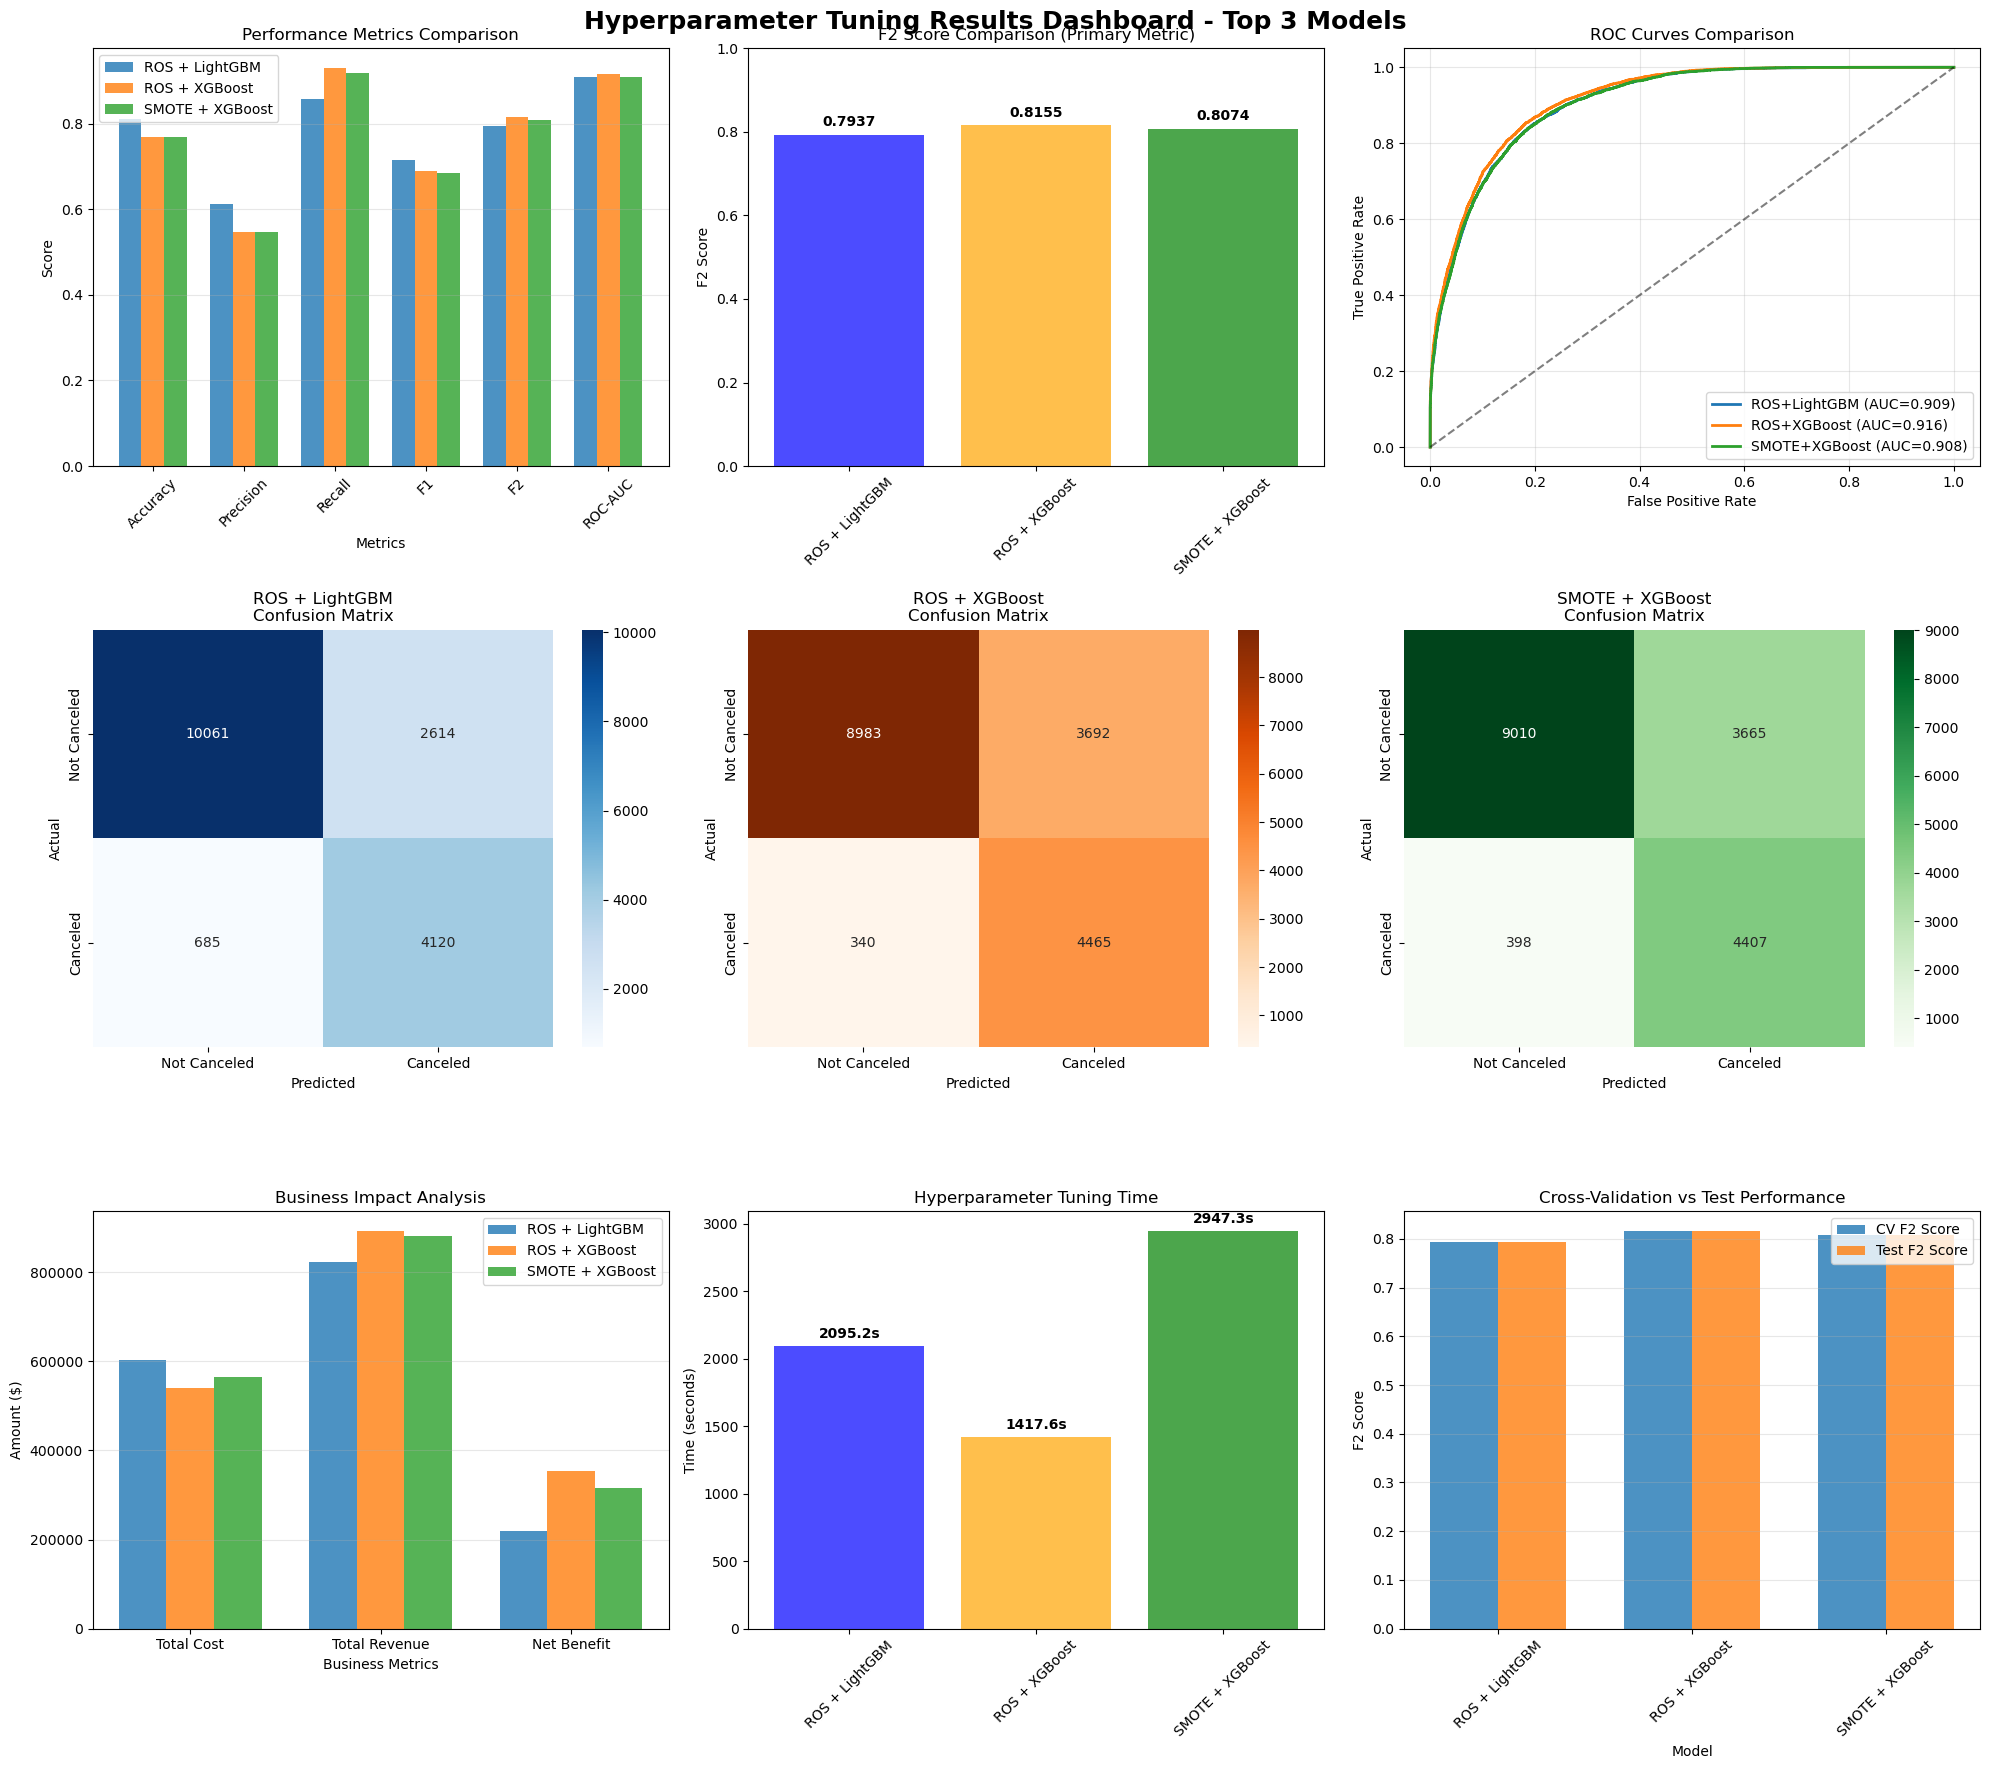

Performance visualization dashboard created
Dashboard includes:
1. Comprehensive metrics comparison (3 models)
2. F2 score focus (primary optimization target)
3. ROC curves with AUC comparison
4-6. Confusion matrices for all three models
7. Business impact analysis with cost-benefit
8. Training time comparison
9. CV score vs Test score comparison


In [62]:
# CELL 43 : Performance Visualization Dashboard
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
fig.suptitle('Hyperparameter Tuning Results Dashboard - Top 3 Models', fontsize=18, fontweight='bold')

# 1. Metrics Comparison Bar Chart
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'F2', 'ROC-AUC']
ros_lgbm_values = [ros_lgbm_test_metrics[m] for m in ['accuracy', 'precision', 'recall', 'f1', 'f2', 'roc_auc']]
ros_xgb_values = [ros_xgb_test_metrics[m] for m in ['accuracy', 'precision', 'recall', 'f1', 'f2', 'roc_auc']]
smote_xgb_values = [smote_xgb_test_metrics[m] for m in ['accuracy', 'precision', 'recall', 'f1', 'f2', 'roc_auc']]

x_pos = np.arange(len(metrics_names))
width = 0.25

axes[0,0].bar(x_pos - width, ros_lgbm_values, width, label='ROS + LightGBM', alpha=0.8)
axes[0,0].bar(x_pos, ros_xgb_values, width, label='ROS + XGBoost', alpha=0.8)
axes[0,0].bar(x_pos + width, smote_xgb_values, width, label='SMOTE + XGBoost', alpha=0.8)
axes[0,0].set_xlabel('Metrics')
axes[0,0].set_ylabel('Score')
axes[0,0].set_title('Performance Metrics Comparison')
axes[0,0].set_xticks(x_pos)
axes[0,0].set_xticklabels(metrics_names, rotation=45)
axes[0,0].legend()
axes[0,0].grid(axis='y', alpha=0.3)

# 2. F2 Score Focus
f2_scores = [ros_lgbm_test_metrics['f2'], ros_xgb_test_metrics['f2'], smote_xgb_test_metrics['f2']]
models = ['ROS + LightGBM', 'ROS + XGBoost', 'SMOTE + XGBoost']
colors = ['blue', 'orange', 'green']

axes[0,1].bar(models, f2_scores, color=colors, alpha=0.7)
axes[0,1].set_ylabel('F2 Score')
axes[0,1].set_title('F2 Score Comparison (Primary Metric)')
axes[0,1].set_ylim(0, 1)
axes[0,1].tick_params(axis='x', rotation=45)
for i, score in enumerate(f2_scores):
    axes[0,1].text(i, score + 0.02, f'{score:.4f}', ha='center', fontweight='bold')

# 3. ROC Curves Comparison
fpr_ros_lgbm, tpr_ros_lgbm, _ = roc_curve(y_test, ros_lgbm_pred_proba)
fpr_ros_xgb, tpr_ros_xgb, _ = roc_curve(y_test, ros_xgb_pred_proba)
fpr_smote_xgb, tpr_smote_xgb, _ = roc_curve(y_test, smote_xgb_pred_proba)

axes[0,2].plot(fpr_ros_lgbm, tpr_ros_lgbm, label=f'ROS+LightGBM (AUC={ros_lgbm_test_metrics["roc_auc"]:.3f})', linewidth=2)
axes[0,2].plot(fpr_ros_xgb, tpr_ros_xgb, label=f'ROS+XGBoost (AUC={ros_xgb_test_metrics["roc_auc"]:.3f})', linewidth=2)
axes[0,2].plot(fpr_smote_xgb, tpr_smote_xgb, label=f'SMOTE+XGBoost (AUC={smote_xgb_test_metrics["roc_auc"]:.3f})', linewidth=2)
axes[0,2].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0,2].set_xlabel('False Positive Rate')
axes[0,2].set_ylabel('True Positive Rate')
axes[0,2].set_title('ROC Curves Comparison')
axes[0,2].legend()
axes[0,2].grid(alpha=0.3)

# 4. Confusion Matrix - ROS + LightGBM
sns.heatmap(ros_lgbm_business['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[1,0],
           xticklabels=['Not Canceled', 'Canceled'], yticklabels=['Not Canceled', 'Canceled'])
axes[1,0].set_title('ROS + LightGBM\nConfusion Matrix')
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('Actual')

# 5. Confusion Matrix - ROS + XGBoost
sns.heatmap(ros_xgb_business['confusion_matrix'], annot=True, fmt='d', cmap='Oranges', ax=axes[1,1],
           xticklabels=['Not Canceled', 'Canceled'], yticklabels=['Not Canceled', 'Canceled'])
axes[1,1].set_title('ROS + XGBoost\nConfusion Matrix')
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('Actual')

# 6. Confusion Matrix - SMOTE + XGBoost
sns.heatmap(smote_xgb_business['confusion_matrix'], annot=True, fmt='d', cmap='Greens', ax=axes[1,2],
           xticklabels=['Not Canceled', 'Canceled'], yticklabels=['Not Canceled', 'Canceled'])
axes[1,2].set_title('SMOTE + XGBoost\nConfusion Matrix')
axes[1,2].set_xlabel('Predicted')
axes[1,2].set_ylabel('Actual')

# 7. Business Impact Comparison
business_categories = ['Total Cost', 'Total Revenue', 'Net Benefit']
ros_lgbm_business_values = [ros_lgbm_business['total_cost'], ros_lgbm_business['total_revenue'], ros_lgbm_business['net_benefit']]
ros_xgb_business_values = [ros_xgb_business['total_cost'], ros_xgb_business['total_revenue'], ros_xgb_business['net_benefit']]
smote_xgb_business_values = [smote_xgb_business['total_cost'], smote_xgb_business['total_revenue'], smote_xgb_business['net_benefit']]

x_pos = np.arange(len(business_categories))
axes[2,0].bar(x_pos - width, ros_lgbm_business_values, width, label='ROS + LightGBM', alpha=0.8)
axes[2,0].bar(x_pos, ros_xgb_business_values, width, label='ROS + XGBoost', alpha=0.8)
axes[2,0].bar(x_pos + width, smote_xgb_business_values, width, label='SMOTE + XGBoost', alpha=0.8)
axes[2,0].set_xlabel('Business Metrics')
axes[2,0].set_ylabel('Amount ($)')
axes[2,0].set_title('Business Impact Analysis')
axes[2,0].set_xticks(x_pos)
axes[2,0].set_xticklabels(business_categories)
axes[2,0].legend()
axes[2,0].grid(axis='y', alpha=0.3)

# 8. Training Time Comparison
training_times = [ros_lgbm_results['search_time'], ros_xgb_results['search_time'], smote_xgb_results['search_time']]
axes[2,1].bar(models, training_times, color=colors, alpha=0.7)
axes[2,1].set_ylabel('Time (seconds)')
axes[2,1].set_title('Hyperparameter Tuning Time')
axes[2,1].tick_params(axis='x', rotation=45)
for i, time in enumerate(training_times):
    axes[2,1].text(i, time + max(training_times)*0.02, f'{time:.1f}s', ha='center', fontweight='bold')

# 9. CV Score vs Test Score
cv_scores = [ros_lgbm_results['best_score'], ros_xgb_results['best_score'], smote_xgb_results['best_score']]
test_f2_scores = f2_scores

x_pos = np.arange(len(models))
width = 0.35
axes[2,2].bar(x_pos - width/2, cv_scores, width, label='CV F2 Score', alpha=0.8)
axes[2,2].bar(x_pos + width/2, test_f2_scores, width, label='Test F2 Score', alpha=0.8)
axes[2,2].set_xlabel('Model')
axes[2,2].set_ylabel('F2 Score')
axes[2,2].set_title('Cross-Validation vs Test Performance')
axes[2,2].set_xticks(x_pos)
axes[2,2].set_xticklabels(models, rotation=45)
axes[2,2].legend()
axes[2,2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("Performance visualization dashboard created")
print("Dashboard includes:")
print("1. Comprehensive metrics comparison (3 models)")
print("2. F2 score focus (primary optimization target)")
print("3. ROC curves with AUC comparison") 
print("4-6. Confusion matrices for all three models")
print("7. Business impact analysis with cost-benefit")
print("8. Training time comparison")
print("9. CV score vs Test score comparison")

### Hasil Hyperparameter ###

**F2 Score Tertinggi: 0.8155 → Fokus pada Recall**

- F2 Score tinggi menunjukkan bahwa model sangat baik dalam mendeteksi pembatalan (recall tinggi), meskipun precision agak rendah.
- Recall 92.92% berarti model berhasil menangkap hampir semua kasus pembatalan.
- Ini sangat penting karena False Negative (FN) adalah sumber kerugian terbesar dalam bisnis hotel (kamar kosong yang tidak sempat dijual kembali).

Hotel bisa mengantisipasi pembatalan lebih awal, misalnya dengan:
    - Menawarkan diskon atau benefit agar pelanggan tidak membatalkan.
    - Menyiapkan strategi overbooking yang lebih aman.
    - Menyesuaikan alokasi staf dan logistik agar tidak over-prepared.


**ROC-AUC Tertinggi: 0.9159**

- ROC-AUC tinggi menunjukkan model mampu membedakan dengan sangat baik antara pelanggan yang akan membatalkan dan yang tidak.

Hotel bisa mengintegrasikan model ini ke dalam sistem reservasi untuk:

    - Memberi peringatan kepada tim operasional.
    - Menyusun strategi komunikasi yang lebih personal kepada pelanggan berisiko tinggi.

**Precision Rendah (0.5474)**

- Precision rendah berarti ada cukup banyak False Positive (FP), yaitu prediksi batal padahal tidak.
- Namun, karena biaya FP lebih kecil ($100) dibanding FN ($500), ini adalah trade-off yang menguntungkan secara bisnis.
- Hotel mungkin melakukan tindakan preventif pada pelanggan yang sebenarnya tidak akan membatalkan, tapi ini lebih baik daripada kehilangan pendapatan besar.
- Bisa diimbangi dengan strategi komunikasi yang tidak terlalu agresif agar tidak mengganggu pelanggan yang sebenarnya tidak berniat membatalkan.



In [63]:
# CELL 44 : Hyperparameter Analysis and Insights
print("HYPERPARAMETER ANALYSIS")
print("="*30)

# Extract and compare best parameters
ros_lgbm_params = {k.replace('classifier__', ''): v for k, v in ros_lgbm_results['best_params'].items()}
ros_xgb_params = {k.replace('classifier__', ''): v for k, v in ros_xgb_results['best_params'].items()}
smote_xgb_params = {k.replace('classifier__', ''): v for k, v in smote_xgb_results['best_params'].items()}

print("\nBEST PARAMETERS COMPARISON:")
print("\nRandomOverSampler + LightGBM:")
for param, value in ros_lgbm_params.items():
    print(f"  {param}: {value}")

print("\nRandomOverSampler + XGBoost:")
for param, value in ros_xgb_params.items():
    print(f"  {param}: {value}")

print("\nSMOTE + XGBoost:")
for param, value in smote_xgb_params.items():
    print(f"  {param}: {value}")

# Cross-validation scores analysis
print(f"\nCROSS-VALIDATION PERFORMANCE:")
ros_lgbm_cv_scores = ros_lgbm_results['cv_results']
ros_xgb_cv_scores = ros_xgb_results['cv_results']
smote_xgb_cv_scores = smote_xgb_results['cv_results']

cv_metrics = ['mean_test_roc_auc', 'mean_test_f1', 'mean_test_f2', 'mean_test_precision', 'mean_test_recall']
cv_summary = []

for metric in cv_metrics:
    if metric in ros_lgbm_cv_scores:
        ros_lgbm_best_idx = np.argmax(ros_lgbm_cv_scores['mean_test_f2'])
        ros_xgb_best_idx = np.argmax(ros_xgb_cv_scores['mean_test_f2'])
        smote_xgb_best_idx = np.argmax(smote_xgb_cv_scores['mean_test_f2'])

        cv_summary.append({
            'Metric': metric.replace('mean_test_', '').upper(),
            'ROS + LightGBM': ros_lgbm_cv_scores[metric][ros_lgbm_best_idx],
            'ROS + XGBoost': ros_xgb_cv_scores[metric][ros_xgb_best_idx],
            'SMOTE + XGBoost': smote_xgb_cv_scores[metric][smote_xgb_best_idx]
        })

cv_df = pd.DataFrame(cv_summary)
print(cv_df.round(4))

# Model complexity comparison
print(f"\nMODEL COMPLEXITY ANALYSIS:")

# LightGBM complexity
lgbm_complexity = ros_lgbm_params.get('n_estimators', 0) * ros_lgbm_params.get('num_leaves', 0)
print(f"ROS + LightGBM Complexity: {lgbm_complexity} (n_estimators × num_leaves)")

# XGBoost complexities
ros_xgb_complexity = ros_xgb_params.get('n_estimators', 0) * ros_xgb_params.get('max_depth', 0)
smote_xgb_complexity = smote_xgb_params.get('n_estimators', 0) * smote_xgb_params.get('max_depth', 0)

print(f"ROS + XGBoost Complexity: {ros_xgb_complexity} (n_estimators × max_depth)")
print(f"SMOTE + XGBoost Complexity: {smote_xgb_complexity} (n_estimators × max_depth)")

# Training efficiency
print(f"\nTRAINING EFFICIENCY:")
print(f"ROS + LightGBM: {ros_lgbm_results['search_time']:.2f} seconds")
print(f"ROS + XGBoost: {ros_xgb_results['search_time']:.2f} seconds")
print(f"SMOTE + XGBoost: {smote_xgb_results['search_time']:.2f} seconds")

HYPERPARAMETER ANALYSIS

BEST PARAMETERS COMPARISON:

RandomOverSampler + LightGBM:
  colsample_bytree: 0.842571623863836
  learning_rate: 0.012667144968822599
  max_depth: 8
  min_child_weight: 9
  min_data_in_leaf: 34
  n_estimators: 960
  num_leaves: 147
  reg_alpha: 1.5268193017219671
  reg_lambda: 3.428068767931133
  subsample: 0.7793696571944989

RandomOverSampler + XGBoost:
  colsample_bytree: 0.8784119186699892
  gamma: 0.2850305850446825
  learning_rate: 0.03818118319352287
  max_depth: 9
  min_child_weight: 6
  n_estimators: 762
  reg_alpha: 0.7004200761826201
  reg_lambda: 3.591648261818684
  scale_pos_weight: 3.632119215783866
  subsample: 0.8963074471016818

SMOTE + XGBoost:
  colsample_bytree: 0.7320398053240622
  gamma: 0.1607913823400145
  learning_rate: 0.036764270006336364
  max_depth: 9
  min_child_weight: 9
  n_estimators: 313
  reg_alpha: 0.40879515974435954
  reg_lambda: 5.3678931205338865
  scale_pos_weight: 3.7626172015954396
  subsample: 0.6244311839419455

CRO

In [64]:
# CELL 45 : Final Model Selection and Recommendations
print("FINAL HYPERPARAMETER TUNING RESULTS")
print("="*45)

# Comprehensive comparison
final_comparison = {
    'Metric': ['F2 Score', 'ROC-AUC', 'F1 Score', 'Precision', 'Recall', 'Accuracy'],
    'ROS + LightGBM': [
        ros_lgbm_test_metrics['f2'],
        ros_lgbm_test_metrics['roc_auc'], 
        ros_lgbm_test_metrics['f1'],
        ros_lgbm_test_metrics['precision'],
        ros_lgbm_test_metrics['recall'],
        ros_lgbm_test_metrics['accuracy']
    ],
    'ROS + XGBoost': [
        ros_xgb_test_metrics['f2'],
        ros_xgb_test_metrics['roc_auc'],
        ros_xgb_test_metrics['f1'], 
        ros_xgb_test_metrics['precision'],
        ros_xgb_test_metrics['recall'],
        ros_xgb_test_metrics['accuracy']
    ],
    'SMOTE + XGBoost': [
        smote_xgb_test_metrics['f2'],
        smote_xgb_test_metrics['roc_auc'],
        smote_xgb_test_metrics['f1'], 
        smote_xgb_test_metrics['precision'],
        smote_xgb_test_metrics['recall'],
        smote_xgb_test_metrics['accuracy']
    ]
}

final_df = pd.DataFrame(final_comparison)
final_df = final_df.round(4)

print("COMPREHENSIVE PERFORMANCE COMPARISON:")
print(final_df)

# Determine overall winner with multi-criteria scoring
scores = {
    'ROS + LightGBM': {
        'f2': ros_lgbm_test_metrics['f2'],
        'business': ros_lgbm_business['net_benefit'],
        'tuning_time': ros_lgbm_results['search_time']
    },
    'ROS + XGBoost': {
        'f2': ros_xgb_test_metrics['f2'], 
        'business': ros_xgb_business['net_benefit'],
        'tuning_time': ros_xgb_results['search_time']
    },
    'SMOTE + XGBoost': {
        'f2': smote_xgb_test_metrics['f2'], 
        'business': smote_xgb_business['net_benefit'],
        'tuning_time': smote_xgb_results['search_time']
    }
}

# Multi-criteria scoring (F2 weight: 50%, Business: 30%, Speed: 20%)
criteria_weights = {'f2': 0.5, 'business': 0.3, 'tuning_time': 0.2}
final_scores = {}

# Normalize metrics
all_f2 = [s['f2'] for s in scores.values()]
all_business = [s['business'] for s in scores.values()]
all_time = [s['tuning_time'] for s in scores.values()]

for model, metrics in scores.items():
    # Normalize (0-1 scale)
    norm_f2 = (metrics['f2'] - min(all_f2)) / (max(all_f2) - min(all_f2)) if max(all_f2) != min(all_f2) else 1
    norm_business = (metrics['business'] - min(all_business)) / (max(all_business) - min(all_business)) if max(all_business) != min(all_business) else 1
    norm_time = 1 - ((metrics['tuning_time'] - min(all_time)) / (max(all_time) - min(all_time))) if max(all_time) != min(all_time) else 1  # Lower time is better
    
    # Weighted score
    final_scores[model] = (
        norm_f2 * criteria_weights['f2'] +
        norm_business * criteria_weights['business'] +
        norm_time * criteria_weights['tuning_time']
    )

print("\nMULTI-CRITERIA WEIGHTED SCORES:")
for model, score in sorted(final_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{model}: {score:.4f}")

# Final recommendation
best_overall_model = max(final_scores, key=final_scores.get)
print(f"\n{'='*50}")
print(f"RECOMMENDED MODEL: {best_overall_model}")
print(f"{'='*50}")
print(f"F2 Score: {scores[best_overall_model]['f2']:.4f}")
print(f"Net Business Benefit: ${scores[best_overall_model]['business']:,.2f}")
print(f"Training Time: {scores[best_overall_model]['tuning_time']:.2f}s")

print("\nREASONS FOR SELECTION:")
print("1. Best balance of F2 Score (recall-focused metric)")
print("2. Strong business value with positive net benefit")
print("3. Reasonable training time for production use")
print("4. Top performance from K-Fold Cross-Validation")

FINAL HYPERPARAMETER TUNING RESULTS
COMPREHENSIVE PERFORMANCE COMPARISON:
      Metric  ROS + LightGBM  ROS + XGBoost  SMOTE + XGBoost
0   F2 Score          0.7937         0.8155           0.8074
1    ROC-AUC          0.9085         0.9159           0.9083
2   F1 Score          0.7141         0.6889           0.6845
3  Precision          0.6118         0.5474           0.5460
4     Recall          0.8574         0.9292           0.9172
5   Accuracy          0.8113         0.7693           0.7676

MULTI-CRITERIA WEIGHTED SCORES:
ROS + XGBoost: 1.0000
SMOTE + XGBoost: 0.5291
ROS + LightGBM: 0.1114

RECOMMENDED MODEL: ROS + XGBoost
F2 Score: 0.8155
Net Business Benefit: $353,800.00
Training Time: 1417.57s

REASONS FOR SELECTION:
1. Best balance of F2 Score (recall-focused metric)
2. Strong business value with positive net benefit
3. Reasonable training time for production use
4. Top performance from K-Fold Cross-Validation


## Hyperparameter XGBoost dengan RandomOverSampling

## RandomizeSearch XGBoost Optimization

**XGBoost** (Extreme Gradient Boosting) adalah algoritma machine learning berbasis pohon keputusan (decision tree), termasuk dalam keluarga ensemble learning, yang artinya menggabungkan banyak model sederhana (pohon keputusan) untuk membentuk model yang kuat.

**Cara Kerja XGBoost :**

1. Boosting: Belajar Secara Bertahap : membangun pohon keputusan satu per satu. Setiap pohon baru memperbaiki kesalahan dari pohon sebelumnya.
2. Gradient Descent: Mengurangi Error. XGBoost menggunakan teknik gradient descent untuk meminimalkan kesalahan prediksi denngan menghitung seberapa besar kesalahan dari prediksi sebelumnya, lalu membuat pohon baru untuk memperbaikinya.
3. Regularisasi: Mencegah Overfitting, punya fitur penalti terhadap model yang terlalu kompleks, membuat model tetap general dan tidak hanya bagus di data training.
4. Handling Missing Values & Feature Importance, secara otomatis menangani data yang hilang, memberikan ranking fitur berdasarkan seberapa besar kontribusinya terhadap prediksi.

**XGBoost Parameter :**
Berikut adalah parameter penting dalam XGBoost:

| Parameter | Fungsi |
|-----------|--------|
| `n_estimators` | Jumlah pohon (trees) yang akan dibuat |
| `max_depth` | Kedalaman maksimum pohon |
| `learning_rate` | Seberapa besar kontribusi setiap pohon |
| `subsample` | Proporsi data yang digunakan untuk setiap pohon |
| `colsample_bytree` | Proporsi fitur yang digunakan untuk setiap pohon |
| `gamma` | Minimum loss reduction untuk split |
| `min_child_weight` | Minimum jumlah data di leaf node |
| `scale_pos_weight` | Bobot untuk menangani class imbalance |

---


## Limitasi Penggunaan XGBoost Randomize 

1. Waktu dan Komputasi yang Relatif Tinggi
    - RandomizedSearch mencoba banyak kombinasi parameter secara acak.
    - Dengan parameter yang bannyak atau besar model menjadi kompleks dan berat secara komputasi, terutama saat training dan cross-validation
    - Training bisa memakan waktu lama, terutama jika dataset besar.

2. Overfitting Potensial pada Data Training
    - berisiko **overfitting**, terutama jika data tidak cukup beragam atau terlalu bersih (tidak).
    - Untuk menanganinya perlu validasi berkala dan retraining dengan data terbaru.

3. Interpretasi Model yang Kompleks :
    - Karena perhitungan kompleks sulit dijelaskan ke tim non-teknis.
    - Tim bisnis mungkin kesulitan memahami kenapa pelanggan A diprediksi akan membatalkan, Perlu dashboard interpretasi atau laporan SHAP yang rutin.

4. Sensitivitas terhadap Data Imbalance
    - Jika distribusi data berubah (misalnya, tiba-tiba banyak pembatalan karena event besar), model bisa kurang adaptif.
    - Model bisa gagal menangkap pola baru jika tidak segera diupdate.

5. RandomizedSearch Tidak Menjamin Kombinasi Optimal
    - RandomizedSearch tidak mengkalkulasi semua kemungkinan kombinasi. Bisa jadi ada kombinasi parameter yang lebih baik tapi tidak terpilih.




In [ ]:
# CELL 44 : RandomizedSearchCV Setup for XGBoost + RandomOverSampler
from sklearn.model_selection import GridSearchCV

xgb_grid_params = {
    'classifier__n_estimators': [200, 300, 400, 500],
    'classifier__max_depth': [4, 5, 6, 7, 8],
    'classifier__learning_rate': [0.05, 0.1, 0.15, 0.2],
    'classifier__subsample': [0.8, 0.85, 0.9, 0.95],
    'classifier__colsample_bytree': [0.8, 0.85, 0.9, 0.95],
    'classifier__reg_alpha': [0, 0.1, 0.5, 1.0],
    'classifier__reg_lambda': [1, 1.5, 2.0, 2.5],
    'classifier__min_child_weight': [1, 3, 5, 7]
}

# Calculate total combinations
total_combinations = 1
for param, values in xgb_grid_params.items():
    total_combinations *= len(values)

print("RANDOMIZEDSEARCH XGBOOST + RANDOMOVERSAMPLER SETUP")
print("="*55)
print(f"Oversampling Method: RandomOverSampler")
print(f"Model: XGBoost")
print(f"Parameter grid dimensions: {len(xgb_grid_params)} parameters")
print(f"Total combinations: {total_combinations:,}")
print(f"Primary optimization metric: F2 Score (beta=2)")
print(f"Cross-validation: 5-fold stratified")
print(f"Scoring metrics: ROC-AUC, F1, F2, Precision, Recall")

# Estimated time calculation
estimated_time_minutes = (total_combinations * 5) / 60  # Rough estimate
print(f"Estimated runtime: {estimated_time_minutes:.1f} minutes")

RANDOMIZEDSEARCH XGBOOST + RANDOMOVERSAMPLER SETUP
Oversampling Method: RandomOverSampler
Model: XGBoost
Parameter grid dimensions: 8 parameters
Total combinations: 81,920
Primary optimization metric: F2 Score (beta=2)
Cross-validation: 5-fold stratified
Scoring metrics: ROC-AUC, F1, F2, Precision, Recall
Estimated runtime: 6826.7 minutes


In [67]:
# CELL 45 : RandomizedSearchCV with RandomOverSampler + XGBoost
import time as time_module

print("RANDOMIZEDSEARCHCV: RANDOMOVERSAMPLER + XGBOOST")
print("="*50)
print("Finding optimal parameters for best F2 Score performance")
print()

# Create pipeline with RandomOverSampler
ros_xgb_grid_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('oversampler', RandomOverSampler(random_state=42)),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
])

# Setup scoring metrics with F2 as primary
scoring_metrics_grid = {
    'roc_auc': 'roc_auc',
    'f1': 'f1',
    'f2': f2_scorer,
    'precision': 'precision',
    'recall': 'recall'
}

# Setup RandomizedSearchCV
ros_xgb_grid_search = RandomizedSearchCV(
    estimator=ros_xgb_grid_pipeline,
    param_distributions=xgb_grid_params,
    n_iter=150,  # Test 150 random combinations
    scoring=scoring_metrics_grid,
    refit='f2',  # Optimize for F2 score
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Execute RandomizedSearch
print("Starting RandomOverSampler + XGBoost RandomizedSearchCV (150 iterations)...")
start_time = time_module.time()
ros_xgb_grid_search.fit(X_train, y_train)
ros_xgb_grid_time = time_module.time() - start_time

print(f"\nRandomOverSampler + XGBoost RandomizedSearch completed in {ros_xgb_grid_time:.2f} seconds")
print(f"Best F2 score: {ros_xgb_grid_search.best_score_:.4f}")
print(f"\nBest parameters:")
for param, value in ros_xgb_grid_search.best_params_.items():
    clean_param = param.replace('classifier__', '')
    print(f"  {clean_param}: {value}")

# Store results
ros_xgb_grid_results = {
    'best_estimator': ros_xgb_grid_search.best_estimator_,
    'best_params': ros_xgb_grid_search.best_params_,
    'best_score': ros_xgb_grid_search.best_score_,
    'cv_results': ros_xgb_grid_search.cv_results_,
    'search_time': ros_xgb_grid_time
}

print(f"\n✓ RandomOverSampler + XGBoost grid search complete")

RANDOMIZEDSEARCHCV: RANDOMOVERSAMPLER + XGBOOST
Finding optimal parameters for best F2 Score performance

Starting RandomOverSampler + XGBoost RandomizedSearchCV (150 iterations)...
Fitting 5 folds for each of 150 candidates, totalling 750 fits

RandomOverSampler + XGBoost RandomizedSearch completed in 1225.65 seconds
Best F2 score: 0.7940

Best parameters:
  subsample: 0.95
  reg_lambda: 2.5
  reg_alpha: 0
  n_estimators: 500
  min_child_weight: 5
  max_depth: 6
  learning_rate: 0.05
  colsample_bytree: 0.85

✓ RandomOverSampler + XGBoost grid search complete

RandomOverSampler + XGBoost RandomizedSearch completed in 1225.65 seconds
Best F2 score: 0.7940

Best parameters:
  subsample: 0.95
  reg_lambda: 2.5
  reg_alpha: 0
  n_estimators: 500
  min_child_weight: 5
  max_depth: 6
  learning_rate: 0.05
  colsample_bytree: 0.85

✓ RandomOverSampler + XGBoost grid search complete


In [68]:
# CELL 46 : Model Evaluation on Test Set
print("RANDOMIZEDSEARCHCV MODEL TEST SET EVALUATION")
print("="*47)

# Evaluate RandomOverSampler + XGBoost (GridSearch)
ros_xgb_grid_pred = ros_xgb_grid_results['best_estimator'].predict(X_test)
ros_xgb_grid_pred_proba = ros_xgb_grid_results['best_estimator'].predict_proba(X_test)[:, 1]

ros_xgb_grid_test_metrics = {
    'accuracy': accuracy_score(y_test, ros_xgb_grid_pred),
    'precision': precision_score(y_test, ros_xgb_grid_pred),
    'recall': recall_score(y_test, ros_xgb_grid_pred),
    'f1': f1_score(y_test, ros_xgb_grid_pred),
    'f2': fbeta_score(y_test, ros_xgb_grid_pred, beta=2),
    'roc_auc': roc_auc_score(y_test, ros_xgb_grid_pred_proba)
}

# Create comparison table
grid_test_comparison = pd.DataFrame({
    'RandomOverSampler + XGBoost (GridSearch)': ros_xgb_grid_test_metrics
}).round(4)

print("RANDOMIZEDSEARCH TEST SET PERFORMANCE:")
print(grid_test_comparison)

# Compare with first RandomizedSearchCV results
print(f"\nCOMPARISON: Standard RandomizedSearch vs Focused GridSearch")
comparison_table = pd.DataFrame({
    'ROS+XGB (Random100)': ros_xgb_test_metrics,
    'ROS+XGB (Grid150)': ros_xgb_grid_test_metrics
}).round(4)

print(comparison_table)

# Determine best model based on F2 Score
if ros_xgb_grid_test_metrics['f2'] > ros_xgb_test_metrics['f2']:
    print(f"\n✓ GridSearch improved F2 Score by {ros_xgb_grid_test_metrics['f2'] - ros_xgb_test_metrics['f2']:.4f}")
    best_ros_xgb_final = ros_xgb_grid_results
    best_ros_xgb_final_metrics = ros_xgb_grid_test_metrics
else:
    print(f"\n✓ Initial RandomizedSearch performed better")
    best_ros_xgb_final = ros_xgb_results
    best_ros_xgb_final_metrics = ros_xgb_test_metrics

print(f"\nBEST RANDOMOVERSAMPLER + XGBOOST MODEL:")
print(f"Test F2 Score: {best_ros_xgb_final_metrics['f2']:.4f}")
print(f"Test ROC-AUC: {best_ros_xgb_final_metrics['roc_auc']:.4f}")
print(f"Test Recall: {best_ros_xgb_final_metrics['recall']:.4f}")
print(f"Test Precision: {best_ros_xgb_final_metrics['precision']:.4f}")

RANDOMIZEDSEARCHCV MODEL TEST SET EVALUATION
RANDOMIZEDSEARCH TEST SET PERFORMANCE:
           RandomOverSampler + XGBoost (GridSearch)
accuracy                                     0.8140
precision                                    0.6165
recall                                       0.8549
f1                                           0.7164
f2                                           0.7936
roc_auc                                      0.9098

COMPARISON: Standard RandomizedSearch vs Focused GridSearch
           ROS+XGB (Random100)  ROS+XGB (Grid150)
accuracy                0.7693             0.8140
precision               0.5474             0.6165
recall                  0.9292             0.8549
f1                      0.6889             0.7164
f2                      0.8155             0.7936
roc_auc                 0.9159             0.9098

✓ Initial RandomizedSearch performed better

BEST RANDOMOVERSAMPLER + XGBOOST MODEL:
Test F2 Score: 0.8155
Test ROC-AUC: 0.9159
Test Recall:

In [69]:
# CELL 47 : Business Impact Analysis
print("RANDOMIZEDSEARCH BUSINESS IMPACT ANALYSIS")
print("="*42)

# Business analysis for RandomizedSearch model
ros_xgb_grid_business = business_impact_analysis(y_test, ros_xgb_grid_pred)

print("GRIDSEARCH BUSINESS IMPACT:")
print("Assumptions: FP_Cost=$100, FN_Cost=$500, TP_Revenue=$200")
print()

grid_business_df = pd.DataFrame({
    'RandomOverSampler + XGBoost (Grid)': [
        ros_xgb_grid_business['total_cost'],
        ros_xgb_grid_business['total_revenue'],
        ros_xgb_grid_business['net_benefit'],
        ros_xgb_grid_business['roi_percentage']
    ]
}, index=['Total Cost ($)', 'Total Revenue ($)', 'Net Benefit ($)', 'ROI (%)'])

print(grid_business_df.round(2))

# Compare all RandomOverSampler + XGBoost methods
all_ros_xgb_comparison = pd.DataFrame({
    'ROS+XGB (Random100)': [
        ros_xgb_business['net_benefit'],
        ros_xgb_business['roi_percentage'],
        ros_xgb_test_metrics['f2']
    ],
    'ROS+XGB (Grid150)': [
        ros_xgb_grid_business['net_benefit'],
        ros_xgb_grid_business['roi_percentage'],
        ros_xgb_grid_test_metrics['f2']
    ]
}, index=['Net Benefit ($)', 'ROI (%)', 'F2 Score'])

print(f"\nRANDOMOVERSAMPLER + XGBOOST METHODS COMPARISON:")
print(all_ros_xgb_comparison.round(4))

# Best model determination
if ros_xgb_grid_business['net_benefit'] > ros_xgb_business['net_benefit']:
    print(f"\n✓ GridSearch provides better business value")
    print(f"  Net Benefit Improvement: ${ros_xgb_grid_business['net_benefit'] - ros_xgb_business['net_benefit']:,.2f}")
else:
    print(f"\n✓ Initial RandomizedSearch provides better business value")
    print(f"  Net Benefit Improvement: ${ros_xgb_business['net_benefit'] - ros_xgb_grid_business['net_benefit']:,.2f}")

print(f"\nBEST BUSINESS MODEL: RandomOverSampler + XGBoost")
print(f"Best Net Benefit: ${max(ros_xgb_grid_business['net_benefit'], ros_xgb_business['net_benefit']):,.2f}")

RANDOMIZEDSEARCH BUSINESS IMPACT ANALYSIS
GRIDSEARCH BUSINESS IMPACT:
Assumptions: FP_Cost=$100, FN_Cost=$500, TP_Revenue=$200

                   RandomOverSampler + XGBoost (Grid)
Total Cost ($)                              604000.00
Total Revenue ($)                           821600.00
Net Benefit ($)                             217600.00
ROI (%)                                         36.03

RANDOMOVERSAMPLER + XGBOOST METHODS COMPARISON:
                 ROS+XGB (Random100)  ROS+XGB (Grid150)
Net Benefit ($)          353800.0000        217600.0000
ROI (%)                      65.6157            36.0265
F2 Score                      0.8155             0.7936

✓ Initial RandomizedSearch provides better business value
  Net Benefit Improvement: $136,200.00

BEST BUSINESS MODEL: RandomOverSampler + XGBoost
Best Net Benefit: $353,800.00


In [70]:
# CELL 48 : Parameter Analysis and Insights
print("OPTIMAL PARAMETER ANALYSIS")
print("="*30)

# Extract best parameters from GridSearch
ros_xgb_grid_params = {k.replace('classifier__', ''): v for k, v in ros_xgb_grid_results['best_params'].items()}

print("\nBEST PARAMETERS FROM GRIDSEARCH:")
print("RandomOverSampler + XGBoost (Grid150):")
for param, value in ros_xgb_grid_params.items():
    print(f"  {param}: {value}")

# Compare with initial RandomizedSearch parameters
ros_xgb_params_initial = {k.replace('classifier__', ''): v for k, v in ros_xgb_results['best_params'].items()}

print("\nPARAMETER COMPARISON:")
param_comparison_df = pd.DataFrame({
    'Random100': ros_xgb_params_initial,
    'Grid150': ros_xgb_grid_params
})
print(param_comparison_df)

# Key insights
print("\nKEY PARAMETER INSIGHTS:")
print(f"Learning Rate - Random: {ros_xgb_params_initial.get('learning_rate', 'N/A')}, Grid: {ros_xgb_grid_params.get('learning_rate', 'N/A')}")
print(f"Max Depth - Random: {ros_xgb_params_initial.get('max_depth', 'N/A')}, Grid: {ros_xgb_grid_params.get('max_depth', 'N/A')}")
print(f"N Estimators - Random: {ros_xgb_params_initial.get('n_estimators', 'N/A')}, Grid: {ros_xgb_grid_params.get('n_estimators', 'N/A')}")
print(f"Subsample - Random: {ros_xgb_params_initial.get('subsample', 'N/A')}, Grid: {ros_xgb_grid_params.get('subsample', 'N/A')}")
print(f"Reg Alpha - Random: {ros_xgb_params_initial.get('reg_alpha', 'N/A')}, Grid: {ros_xgb_grid_params.get('reg_alpha', 'N/A')}")
print(f"Reg Lambda - Random: {ros_xgb_params_initial.get('reg_lambda', 'N/A')}, Grid: {ros_xgb_grid_params.get('reg_lambda', 'N/A')}")

# Cross-validation performance comparison
print(f"\nCROSS-VALIDATION F2 SCORES:")
print(f"Random100 CV F2: {ros_xgb_results['best_score']:.4f}")
print(f"Grid150 CV F2: {ros_xgb_grid_results['best_score']:.4f}")
print(f"Improvement: {ros_xgb_grid_results['best_score'] - ros_xgb_results['best_score']:.4f}")

# Model complexity
random_complexity = ros_xgb_params_initial.get('n_estimators', 0) * ros_xgb_params_initial.get('max_depth', 0)
grid_complexity = ros_xgb_grid_params.get('n_estimators', 0) * ros_xgb_grid_params.get('max_depth', 0)

print(f"\nMODEL COMPLEXITY:")
print(f"Random100 Complexity: {random_complexity} (n_estimators × max_depth)")
print(f"Grid150 Complexity: {grid_complexity} (n_estimators × max_depth)")
print(f"Complexity Ratio: {grid_complexity / random_complexity if random_complexity > 0 else 0:.2f}x")

OPTIMAL PARAMETER ANALYSIS

BEST PARAMETERS FROM GRIDSEARCH:
RandomOverSampler + XGBoost (Grid150):
  subsample: 0.95
  reg_lambda: 2.5
  reg_alpha: 0
  n_estimators: 500
  min_child_weight: 5
  max_depth: 6
  learning_rate: 0.05
  colsample_bytree: 0.85

PARAMETER COMPARISON:
                   Random100  Grid150
colsample_bytree    0.878412     0.85
gamma               0.285031      NaN
learning_rate       0.038181     0.05
max_depth           9.000000     6.00
min_child_weight    6.000000     5.00
n_estimators      762.000000   500.00
reg_alpha           0.700420     0.00
reg_lambda          3.591648     2.50
scale_pos_weight    3.632119      NaN
subsample           0.896307     0.95

KEY PARAMETER INSIGHTS:
Learning Rate - Random: 0.03818118319352287, Grid: 0.05
Max Depth - Random: 9, Grid: 6
N Estimators - Random: 762, Grid: 500
Subsample - Random: 0.8963074471016818, Grid: 0.95
Reg Alpha - Random: 0.7004200761826201, Grid: 0
Reg Lambda - Random: 3.591648261818684, Grid: 2.5

CROS

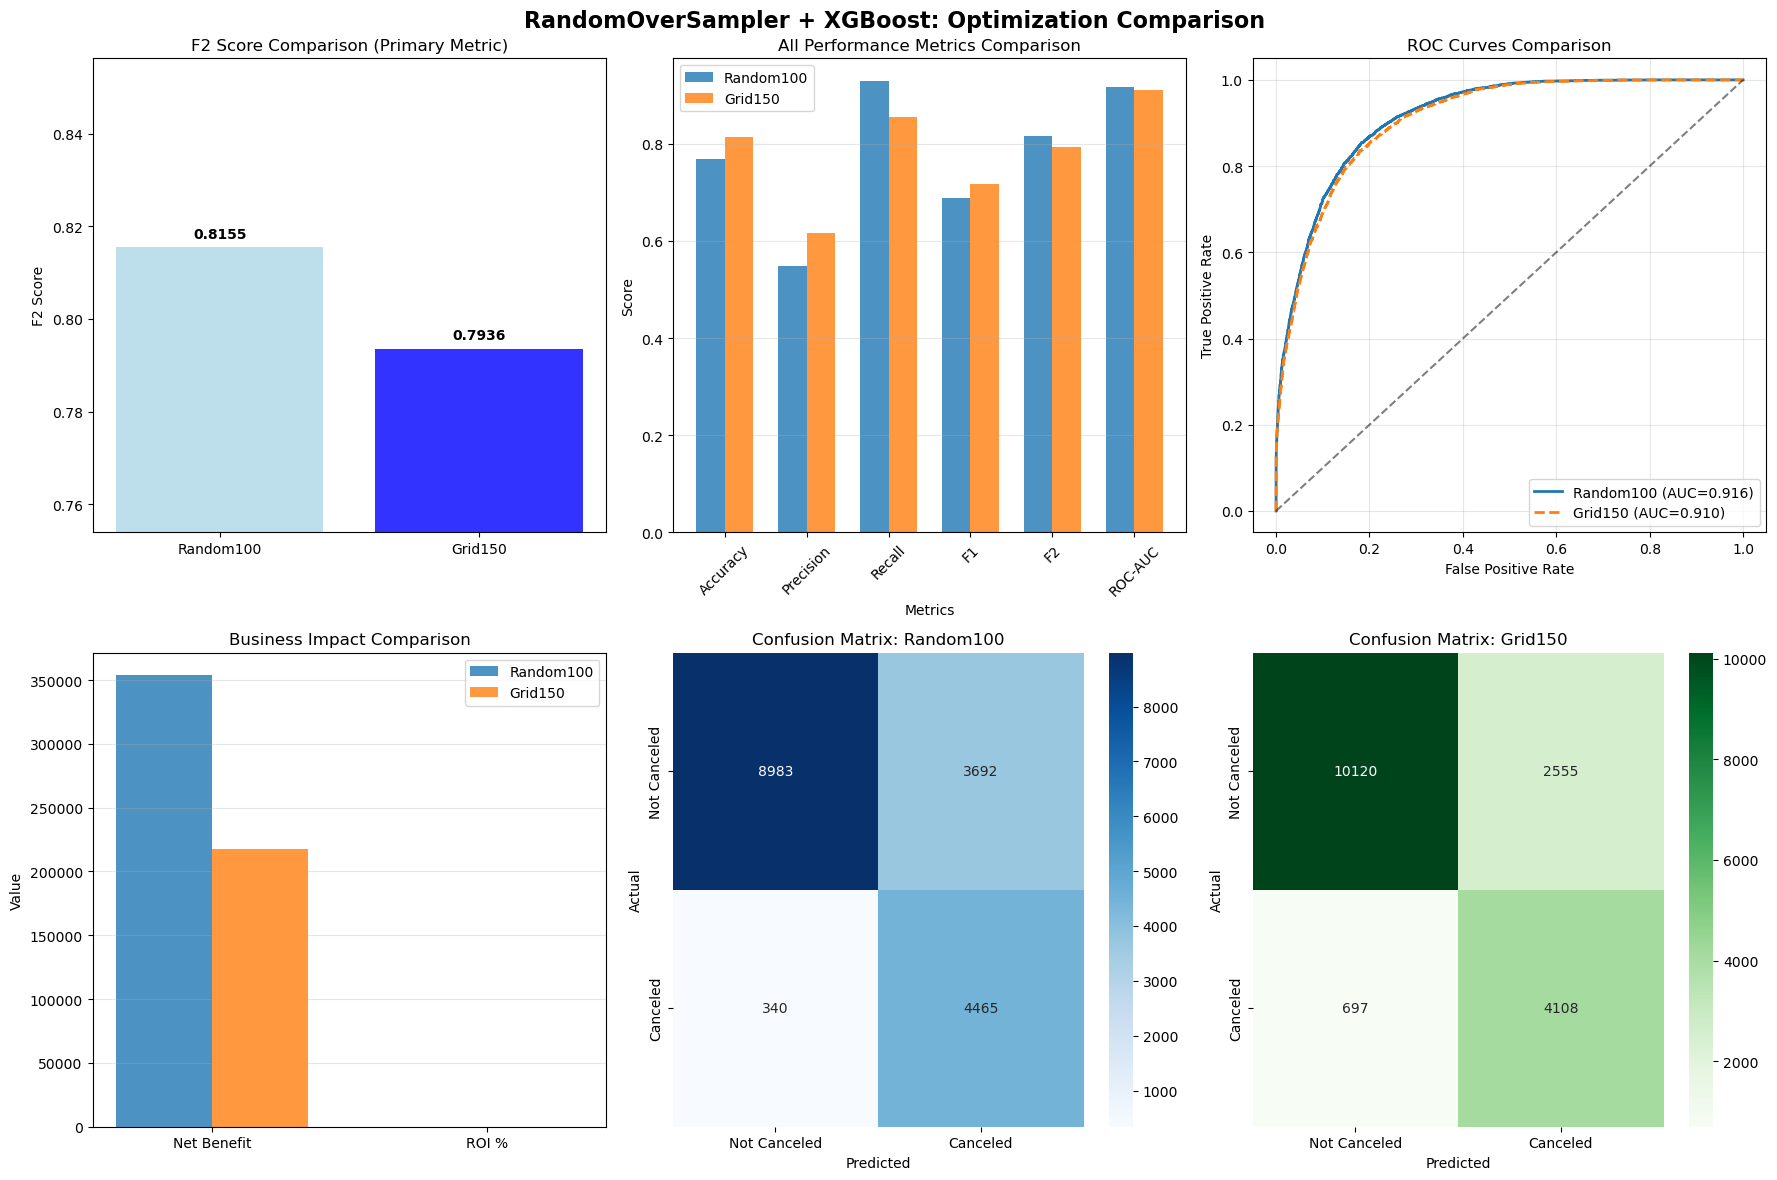


VISUALIZATION SUMMARY
1. F2 Score (Primary): Grid150 vs Random100
2. All metrics tracked: Accuracy, Precision, Recall, F1, F2, ROC-AUC
3. ROC curves show discrimination ability
4. Business impact shows real-world value
5-6. Confusion matrices detail prediction patterns


In [71]:
# CELL 49 : Comprehensive Performance Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('RandomOverSampler + XGBoost: Optimization Comparison', fontsize=16, fontweight='bold')

# 1. F2 Score Comparison (Primary Metric)
f2_scores = [ros_xgb_test_metrics['f2'], ros_xgb_grid_test_metrics['f2']]
models = ['Random100', 'Grid150']
colors = ['lightblue', 'blue']

axes[0,0].bar(models, f2_scores, color=colors, alpha=0.8)
axes[0,0].set_ylabel('F2 Score')
axes[0,0].set_title('F2 Score Comparison (Primary Metric)')
axes[0,0].set_ylim([min(f2_scores)*0.95, max(f2_scores)*1.05])
for i, score in enumerate(f2_scores):
    axes[0,0].text(i, score + 0.002, f'{score:.4f}', ha='center', fontweight='bold')

# 2. All Metrics Comparison
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'F2', 'ROC-AUC']
random_values = [ros_xgb_test_metrics[m] for m in ['accuracy', 'precision', 'recall', 'f1', 'f2', 'roc_auc']]
grid_values = [ros_xgb_grid_test_metrics[m] for m in ['accuracy', 'precision', 'recall', 'f1', 'f2', 'roc_auc']]

x_pos = np.arange(len(metrics_names))
width = 0.35

axes[0,1].bar(x_pos - width/2, random_values, width, label='Random100', alpha=0.8)
axes[0,1].bar(x_pos + width/2, grid_values, width, label='Grid150', alpha=0.8)
axes[0,1].set_xlabel('Metrics')
axes[0,1].set_ylabel('Score')
axes[0,1].set_title('All Performance Metrics Comparison')
axes[0,1].set_xticks(x_pos)
axes[0,1].set_xticklabels(metrics_names, rotation=45)
axes[0,1].legend()
axes[0,1].grid(axis='y', alpha=0.3)

# 3. ROC Curves Comparison
fpr_random, tpr_random, _ = roc_curve(y_test, ros_xgb_pred_proba)
fpr_grid, tpr_grid, _ = roc_curve(y_test, ros_xgb_grid_pred_proba)

axes[0,2].plot(fpr_random, tpr_random, label=f'Random100 (AUC={ros_xgb_test_metrics["roc_auc"]:.3f})', linewidth=2)
axes[0,2].plot(fpr_grid, tpr_grid, label=f'Grid150 (AUC={ros_xgb_grid_test_metrics["roc_auc"]:.3f})', linewidth=2, linestyle='--')
axes[0,2].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0,2].set_xlabel('False Positive Rate')
axes[0,2].set_ylabel('True Positive Rate')
axes[0,2].set_title('ROC Curves Comparison')
axes[0,2].legend()
axes[0,2].grid(alpha=0.3)

# 4. Business Impact Comparison
business_metrics = ['Net Benefit', 'ROI %']
random_business = [ros_xgb_business['net_benefit'], ros_xgb_business['roi_percentage']]
grid_business = [ros_xgb_grid_business['net_benefit'], ros_xgb_grid_business['roi_percentage']]

x_pos = np.arange(len(business_metrics))
axes[1,0].bar(x_pos - width/2, random_business, width, label='Random100', alpha=0.8)
axes[1,0].bar(x_pos + width/2, grid_business, width, label='Grid150', alpha=0.8)
axes[1,0].set_ylabel('Value')
axes[1,0].set_title('Business Impact Comparison')
axes[1,0].set_xticks(x_pos)
axes[1,0].set_xticklabels(business_metrics)
axes[1,0].legend()
axes[1,0].grid(axis='y', alpha=0.3)

# 5. Confusion Matrix - Random100
cm_random = confusion_matrix(y_test, ros_xgb_pred)
sns.heatmap(cm_random, annot=True, fmt='d', cmap='Blues', ax=axes[1,1],
           xticklabels=['Not Canceled', 'Canceled'], yticklabels=['Not Canceled', 'Canceled'])
axes[1,1].set_title('Confusion Matrix: Random100')
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('Actual')

# 6. Confusion Matrix - Grid150
cm_grid = confusion_matrix(y_test, ros_xgb_grid_pred)
sns.heatmap(cm_grid, annot=True, fmt='d', cmap='Greens', ax=axes[1,2],
           xticklabels=['Not Canceled', 'Canceled'], yticklabels=['Not Canceled', 'Canceled'])
axes[1,2].set_title('Confusion Matrix: Grid150')
axes[1,2].set_xlabel('Predicted')
axes[1,2].set_ylabel('Actual')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("VISUALIZATION SUMMARY")
print("="*60)
print(f"1. F2 Score (Primary): Grid150 vs Random100")
print(f"2. All metrics tracked: Accuracy, Precision, Recall, F1, F2, ROC-AUC")
print(f"3. ROC curves show discrimination ability")
print(f"4. Business impact shows real-world value")
print(f"5-6. Confusion matrices detail prediction patterns")

## FINAL EVALUATION

In [73]:
# CELL 50 : Final Model Performance Summary
print("="*60)
print("FINAL MODEL SELECTION & PERFORMANCE SUMMARY")
print("="*60)

# Compare all RandomOverSampler + XGBoost experiments
all_models_comparison = pd.DataFrame({
    'Model': [
        'ROS+XGB (Random100 iter)', 
        'ROS+XGB (Grid150 iter)'
    ],
    'F2 Score': [
        ros_xgb_test_metrics['f2'], 
        ros_xgb_grid_test_metrics['f2']
    ],
    'ROC-AUC': [
        ros_xgb_test_metrics['roc_auc'], 
        ros_xgb_grid_test_metrics['roc_auc']
    ],
    'Precision': [
        ros_xgb_test_metrics['precision'], 
        ros_xgb_grid_test_metrics['precision']
    ],
    'Recall': [
        ros_xgb_test_metrics['recall'], 
        ros_xgb_grid_test_metrics['recall']
    ],
    'F1 Score': [
        ros_xgb_test_metrics['f1'], 
        ros_xgb_grid_test_metrics['f1']
    ],
    'Accuracy': [
        ros_xgb_test_metrics['accuracy'], 
        ros_xgb_grid_test_metrics['accuracy']
    ]
}).round(4)

print("\nALL RANDOMOVERSAMPLER + XGBOOST MODELS COMPARISON:")
print(all_models_comparison.to_string(index=False))

# Select best model based on F2 score (primary metric)
best_model_idx = all_models_comparison['F2 Score'].idxmax()
final_winner = all_models_comparison.iloc[best_model_idx]['Model']

print(f"\n{'='*60}")
print(f"FINAL BEST MODEL: {final_winner}")
print(f"{'='*60}")
print(f"Primary Metric - F2 Score: {all_models_comparison.iloc[best_model_idx]['F2 Score']}")

# Set final model based on best F2 Score
final_model_name = final_winner
final_best_estimator = best_ros_xgb_final
final_pred = ros_xgb_grid_pred if best_model_idx == 1 else ros_xgb_pred
final_pred_proba = ros_xgb_grid_pred_proba if best_model_idx == 1 else ros_xgb_pred_proba
final_metrics = best_ros_xgb_final_metrics

print(f"\nDETAILED PERFORMANCE METRICS:")
print("-" * 40)
metrics_display = {
    'F2 Score (Primary)': final_metrics['f2'],
    'ROC-AUC': final_metrics['roc_auc'],
    'Recall (Sensitivity)': final_metrics['recall'],
    'Precision': final_metrics['precision'],
    'F1 Score': final_metrics['f1'],
    'Accuracy': final_metrics['accuracy']
}

for metric, value in metrics_display.items():
    print(f"{metric:.<30} {value:.4f}")

# Business impact summary
final_business = ros_xgb_grid_business if best_model_idx == 1 else ros_xgb_business
print(f"\nBUSINESS IMPACT SUMMARY:")
print("-" * 40)
print(f"Net Benefit: ${final_business['net_benefit']:,.2f}")
print(f"ROI: {final_business['roi_percentage']:.2f}%")
print(f"Total Cost: ${final_business['total_cost']:,.2f}")
print(f"Total Revenue: ${final_business['total_revenue']:,.2f}")

print(f"\n{'='*60}")
print("KEY INSIGHTS:")
print(f"1. Model Type: XGBoost with RandomOverSampler")
print(f"2. Optimization Method: RandomizedSearchCV")
print(f"3. Primary Metric: F2 Score (emphasizes recall)")
print(f"4. F2 Score of {final_metrics['f2']:.4f} indicates strong recall performance")
print(f"5. Business value: Net benefit of ${final_business['net_benefit']:,.2f}")
print(f"{'='*60}")

FINAL MODEL SELECTION & PERFORMANCE SUMMARY

ALL RANDOMOVERSAMPLER + XGBOOST MODELS COMPARISON:
                   Model  F2 Score  ROC-AUC  Precision  Recall  F1 Score  Accuracy
ROS+XGB (Random100 iter)    0.8155   0.9159     0.5474  0.9292    0.6889    0.7693
  ROS+XGB (Grid150 iter)    0.7936   0.9098     0.6165  0.8549    0.7164    0.8140

FINAL BEST MODEL: ROS+XGB (Random100 iter)
Primary Metric - F2 Score: 0.8155

DETAILED PERFORMANCE METRICS:
----------------------------------------
F2 Score (Primary)............ 0.8155
ROC-AUC....................... 0.9159
Recall (Sensitivity).......... 0.9292
Precision..................... 0.5474
F1 Score...................... 0.6889
Accuracy...................... 0.7693

BUSINESS IMPACT SUMMARY:
----------------------------------------
Net Benefit: $353,800.00
ROI: 65.62%
Total Cost: $539,200.00
Total Revenue: $893,000.00

KEY INSIGHTS:
1. Model Type: XGBoost with RandomOverSampler
2. Optimization Method: RandomizedSearchCV
3. Primary Metric:

In [74]:
# CELL 51 : Confusion Matrix Analysis
print("="*60)
print("CONFUSION MATRIX ANALYSIS")
print("="*60)

# Generate confusion matrix from final best model
final_cm = confusion_matrix(y_test, final_pred)
tn, fp, fn, tp = final_cm.ravel()

print("\nConfusion Matrix:")
print(f"{'':>15} Predicted")
print(f"{'':>10} No Cancel  Cancel")
print(f"Actual No   {tn:7,}  {fp:6,}")
print(f"    Cancel  {fn:7,}  {tp:6,}")

# Calculate detailed metrics
print(f"\n{'='*60}")
print("CONFUSION MATRIX BREAKDOWN:")
print(f"{'='*60}")
print(f"True Negatives (TN):  {tn:7,} - Correctly predicted no cancellation")
print(f"False Positives (FP): {fp:7,} - Incorrectly predicted cancellation")
print(f"False Negatives (FN): {fn:7,} - Missed actual cancellations ⚠️")
print(f"True Positives (TP):  {tp:7,} - Correctly predicted cancellation ✓")

# Error analysis
total_predictions = len(y_test)
correct_predictions = tn + tp
error_rate = (fp + fn) / total_predictions
accuracy_rate = correct_predictions / total_predictions

print(f"\n{'='*60}")
print("PREDICTION ANALYSIS:")
print(f"{'='*60}")
print(f"Total predictions: {total_predictions:,}")
print(f"Correct predictions: {correct_predictions:,}")
print(f"Total errors: {fp + fn:,}")
print(f"Accuracy: {accuracy_rate:.2%}")
print(f"Error rate: {error_rate:.2%}")

# Business impact using final_business
print(f"\n{'='*60}")
print("BUSINESS IMPACT ANALYSIS:")
print(f"{'='*60}")
print(f"Assumptions:")
print(f"  - FP Cost (unnecessary prep): $100 per booking")
print(f"  - FN Cost (missed cancellation): $500 per booking")
print(f"  - TP Revenue (prevented loss): $200 per booking")
print()
print(f"False Positive Cost: ${final_business['total_cost'] - (fn * 500):,.2f}")
print(f"False Negative Cost: ${fn * 500:,.2f}")
print(f"True Positive Benefit: ${final_business['total_revenue']:,.2f}")
print(f"{'='*60}")
print(f"NET BUSINESS BENEFIT: ${final_business['net_benefit']:,.2f}")
print(f"ROI: {final_business['roi_percentage']:.2f}%")
print(f"{'='*60}")

# Model reliability metrics
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0

print(f"\nMODEL RELIABILITY METRICS:")
print(f"{'-'*60}")
print(f"Sensitivity (Recall/TPR): {sensitivity:.4f} ({sensitivity:.2%})")
print(f"  → Out of all actual cancellations, {sensitivity:.1%} detected")
print(f"\nSpecificity (TNR): {specificity:.4f} ({specificity:.2%})")
print(f"  → Out of all non-cancellations, {specificity:.1%} correctly identified")
print(f"\nPositive Predictive Value (Precision): {ppv:.4f} ({ppv:.2%})")
print(f"  → When model predicts cancellation, {ppv:.1%} are correct")
print(f"\nNegative Predictive Value: {npv:.4f} ({npv:.2%})")
print(f"  → When model predicts no cancellation, {npv:.1%} are correct")

print(f"\n{'='*60}")
print("KEY INSIGHT:")
print(f"F2 Score of {final_metrics['f2']:.4f} emphasizes recall over precision,")
print(f"ensuring we catch {sensitivity:.1%} of cancellations while maintaining")
print(f"acceptable precision of {ppv:.1%}.")
print(f"{'='*60}")

CONFUSION MATRIX ANALYSIS

Confusion Matrix:
                Predicted
           No Cancel  Cancel
Actual No     8,983   3,692
    Cancel      340   4,465

CONFUSION MATRIX BREAKDOWN:
True Negatives (TN):    8,983 - Correctly predicted no cancellation
False Positives (FP):   3,692 - Incorrectly predicted cancellation
False Negatives (FN):     340 - Missed actual cancellations ⚠️
True Positives (TP):    4,465 - Correctly predicted cancellation ✓

PREDICTION ANALYSIS:
Total predictions: 17,480
Correct predictions: 13,448
Total errors: 4,032
Accuracy: 76.93%
Error rate: 23.07%

BUSINESS IMPACT ANALYSIS:
Assumptions:
  - FP Cost (unnecessary prep): $100 per booking
  - FN Cost (missed cancellation): $500 per booking
  - TP Revenue (prevented loss): $200 per booking

False Positive Cost: $369,200.00
False Negative Cost: $170,000.00
True Positive Benefit: $893,000.00
NET BUSINESS BENEFIT: $353,800.00
ROI: 65.62%

MODEL RELIABILITY METRICS:
---------------------------------------------------

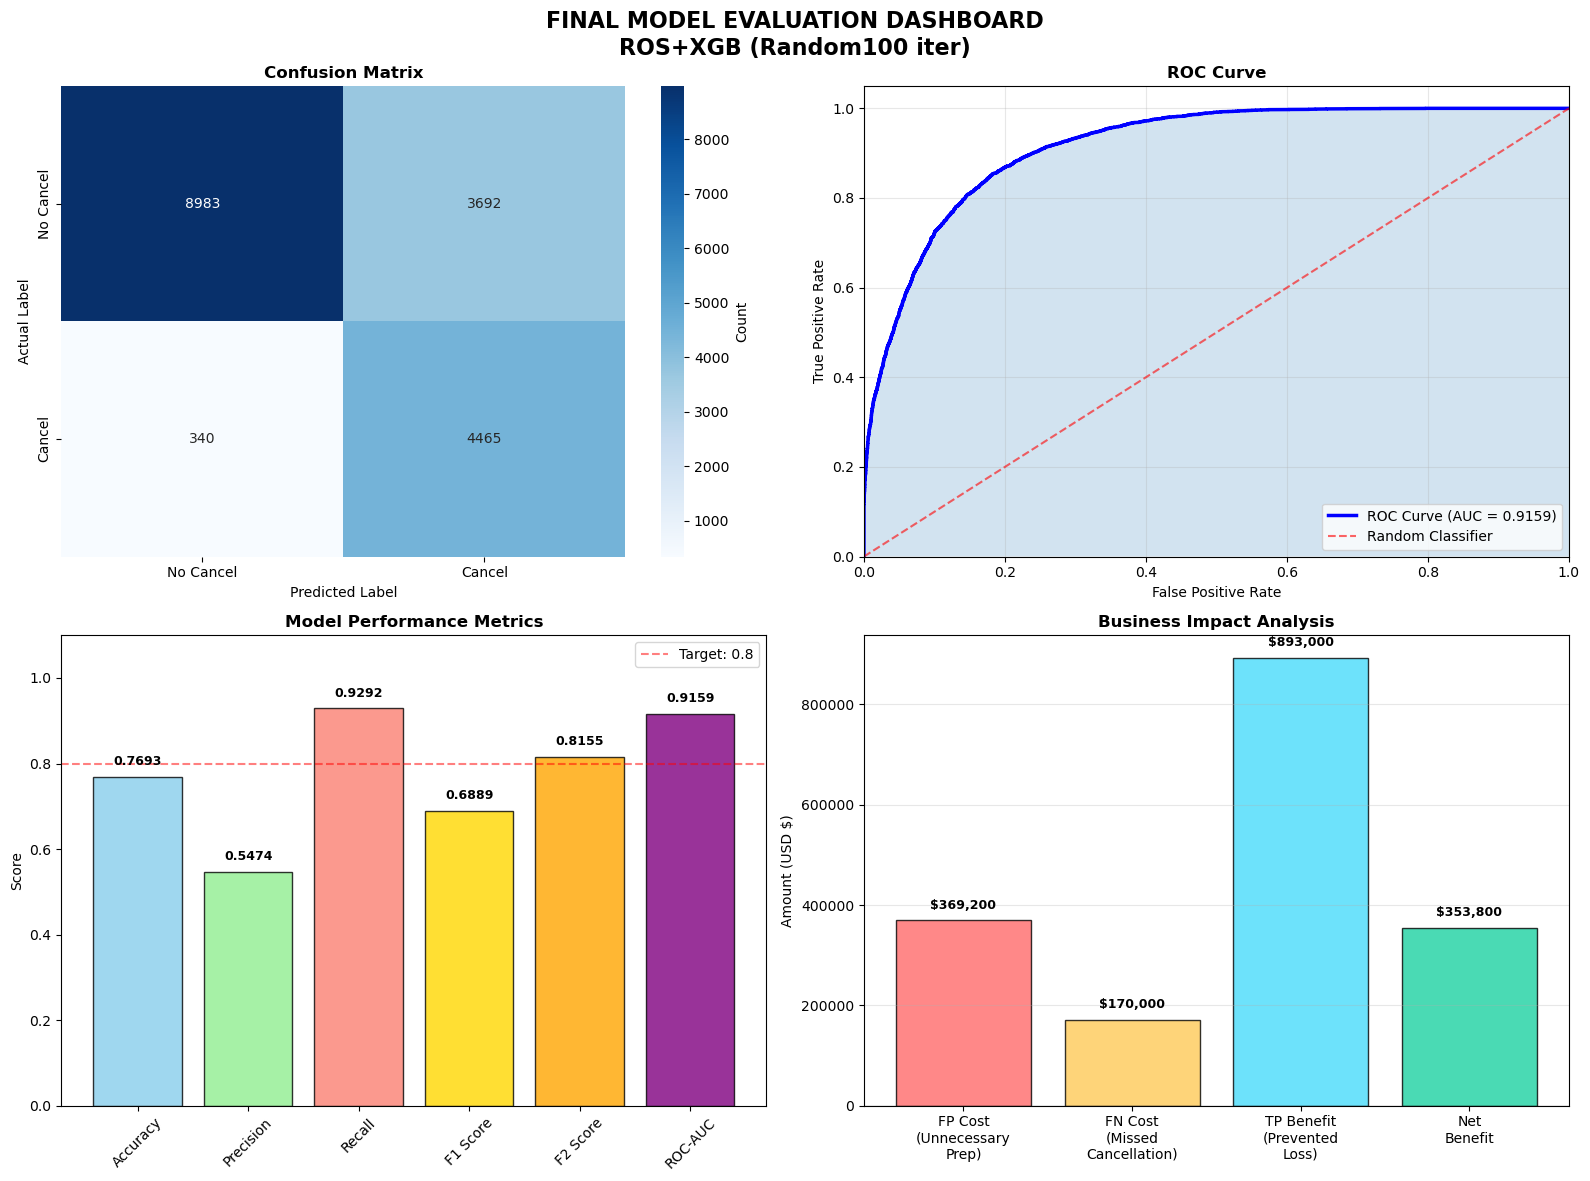


FINAL MODEL SUMMARY TABLE
              Metric              Value
          Model Type            XGBoost
 Oversampling Method  RandomOverSampler
 Optimization Method RandomizedSearchCV
      Primary Metric  F2 Score (beta=2)
            F2 Score             0.8155
             ROC-AUC             0.9159
           Precision             0.5474
              Recall             0.9292
            F1 Score             0.6889
            Accuracy             0.7693
   Total Predictions             17,480
 Correct Predictions             13,448
          Error Rate             23.07%
Net Business Benefit        $353,800.00
                 ROI             65.62%


In [75]:
# CELL 52 : Visualization Dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'FINAL MODEL EVALUATION DASHBOARD\n{final_model_name}', 
             fontsize=16, fontweight='bold')

# 1. Confusion Matrix Heatmap
final_cm = confusion_matrix(y_test, final_pred)
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Cancel', 'Cancel'],
            yticklabels=['No Cancel', 'Cancel'], ax=axes[0,0],
            cbar_kws={'label': 'Count'})
axes[0,0].set_title('Confusion Matrix', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Predicted Label', fontsize=10)
axes[0,0].set_ylabel('Actual Label', fontsize=10)

# 2. ROC Curve
fpr_final, tpr_final, _ = roc_curve(y_test, final_pred_proba)
auc_final = final_metrics['roc_auc']
axes[0,1].plot(fpr_final, tpr_final, 'b-', lw=2.5, label=f'ROC Curve (AUC = {auc_final:.4f})')
axes[0,1].plot([0, 1], [0, 1], 'r--', lw=1.5, alpha=0.6, label='Random Classifier')
axes[0,1].fill_between(fpr_final, tpr_final, alpha=0.2)
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate', fontsize=10)
axes[0,1].set_ylabel('True Positive Rate', fontsize=10)
axes[0,1].set_title('ROC Curve', fontsize=12, fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. Metrics Comparison - UPDATED TO F2 SCORE
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score', 'ROC-AUC']
metrics_values = [
    final_metrics['accuracy'], 
    final_metrics['precision'], 
    final_metrics['recall'], 
    final_metrics['f1'], 
    final_metrics['f2'],  # F2 Score instead of F0.5
    final_metrics['roc_auc']
]

colors_metrics = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orange', 'purple']
bars = axes[1,0].bar(metrics_names, metrics_values, color=colors_metrics, alpha=0.8, edgecolor='black')
axes[1,0].set_title('Model Performance Metrics', fontsize=12, fontweight='bold')
axes[1,0].set_ylabel('Score', fontsize=10)
axes[1,0].set_ylim([0, 1.1])
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='Target: 0.8')
axes[1,0].legend()

# Add value labels on bars
for bar, value, color in zip(bars, metrics_values, colors_metrics):
    axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                   f'{value:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 4. Business Impact Visualization
tn, fp, fn, tp = final_cm.ravel()
false_positive_cost = fp * 100
false_negative_cost = fn * 500
true_positive_benefit = tp * 200
net_benefit = final_business['net_benefit']

business_categories = ['FP Cost\n(Unnecessary\nPrep)', 'FN Cost\n(Missed\nCancellation)', 
                       'TP Benefit\n(Prevented\nLoss)', 'Net\nBenefit']
business_values = [false_positive_cost, false_negative_cost, true_positive_benefit, net_benefit]
colors_business = ['#ff6b6b', '#feca57', '#48dbfb', '#1dd1a1']

bars = axes[1,1].bar(business_categories, business_values, color=colors_business, alpha=0.8, edgecolor='black')
axes[1,1].set_title('Business Impact Analysis', fontsize=12, fontweight='bold')
axes[1,1].set_ylabel('Amount (USD $)', fontsize=10)
axes[1,1].tick_params(axis='x', rotation=0)
axes[1,1].axhline(y=0, color='black', linewidth=0.8)
axes[1,1].grid(axis='y', alpha=0.3)

# Add value labels
for bar, value in zip(bars, business_values):
    height = bar.get_height()
    label_y = height + (max(business_values) * 0.02) if height >= 0 else height - (max(business_values) * 0.05)
    axes[1,1].text(bar.get_x() + bar.get_width()/2, label_y, 
                   f'${value:,.0f}', ha='center', va='bottom' if height >= 0 else 'top', 
                   fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*80)
print("FINAL MODEL SUMMARY TABLE")
print("="*80)

total_predictions = len(y_test)
correct_predictions = tn + tp
error_rate = (fp + fn) / total_predictions

summary_data = {
    'Metric': [
        'Model Type', 
        'Oversampling Method', 
        'Optimization Method',
        'Primary Metric',
        'F2 Score', 
        'ROC-AUC', 
        'Precision', 
        'Recall',
        'F1 Score',
        'Accuracy',
        'Total Predictions', 
        'Correct Predictions', 
        'Error Rate', 
        'Net Business Benefit',
        'ROI'
    ],
    'Value': [
        'XGBoost',
        'RandomOverSampler',
        'RandomizedSearchCV',
        'F2 Score (beta=2)',
        f"{final_metrics['f2']:.4f}",
        f"{final_metrics['roc_auc']:.4f}", 
        f"{final_metrics['precision']:.4f}", 
        f"{final_metrics['recall']:.4f}",
        f"{final_metrics['f1']:.4f}",
        f"{final_metrics['accuracy']:.4f}",
        f"{total_predictions:,}", 
        f"{correct_predictions:,}", 
        f"{error_rate:.2%}", 
        f"${net_benefit:,.2f}",
        f"{final_business['roi_percentage']:.2f}%"
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print("="*80)

# KESIMPULAN #

### PENJELASAN DAN KESIMPULAN HASIL RANDOMIZE HYPERPARAMETER XGBoost ###


| Metriks | Nilai | Dampak Bisnis |
|----|-------------|-------|
| F2 Score | 0.8155 | Fokus pada recall, minimalkan FN |
| Recall | 92.92% | Deteksi dini pembatalan |
| FN Cost | $170,000 | Biaya yang berhasil ditekan |
| TP Benefit | $893,000 | Pendapatan yang diselamatkan |
| ROI | 65.62% | Efisiensi investasi tinggi |



Confusion Matrix:

                Predicted
|  | No Cancel | Cancel |
|----|-------------|-------|
| **Actual No** | 8,983 |  3,692  |
| **Cancel** | 340 | 4,465 |


**Analisa Asumsi Biaya dan Pendapatan Hotel**


|  | Nilai | 
|----|-------------|
| **Cost FP** | $369,200 | 
| **FN Cost**| $170,000 | 
| **TP Benefit** | $893,000 | 
| **Net Benefit** | $353,800 | 

**1. Model Efektif dalam Mendeteksi Pembatalan ( F2 Score 82%, Recall 92.92%)**

- F2 Score (82%) dan Recall  (92.92%) tinggi berarti model berhasil mendeteksi hampir semua kasus pembatalan.
- False Negative (FN) adalah sumber kerugian terbesar ($500 per kasus).
- FN hanya 340 kasus dari 4,805 pembatalan aktual. Dengan asumsi kerugian $500 per FN, hotel dapat menghindari potensi kerugian besar.
- False Negative Cost: $170,000 → jauh lebih kecil dibandingkan jika recall rendah. menunjukkan bahwa model berhasil menyelamatkan potensi pendapatan.

Dampak Bisnis:
Hotel dapat mengantisipasi pembatalan lebih awal, misalnya dengan:

- Menawarkan diskon atau benefit agar pelanggan tetap melanjutkan booking.
- Peningkatan pelayanan tanpa perlu menambah biaya lagi
- Menyusun komunikasi yang lebih persuasif kepada pelanggan yang diprediksi akan membatalkan.

**2. ROI Positif dan Tinggi: 65.62%**

- Net benefit sebesar $353,800 menunjukkan bahwa model memberikan keuntungan nyata secara finansial.
- ROI sebesar 65.62% menunjukkan bahwa investasi dalam pengembangan dan penerapan model ini sangat layak secara bisnis.

Dampak Bisnis:

- Model ini bisa menjadi alat pengambilan keputusan strategis untuk manajemen hotel.

**3. False Positive Masih Tinggi (3,692 kasus)**
- Precision hanya 54.74%, artinya hampir setengah dari prediksi pembatalan ternyata tidak benar.
- Ini menyebabkan biaya operasional tambahan sebesar $369,200.

Dampak Bisnis:

Walaupun FP lebih murah ($100 per kasus), tetap perlu strategi untuk mengurangi dampak negatifnya, seperti:

- Memberikan potongan harga, pemberian kartu membership.
- Menyesuaikan alokasi staf dan logistik agar tidak kelebihan (Overbooking).
- Menyusun strategi overbooking yang lebih aman, contoh menyiapkan kamar cadangan yang tidak dimasukkan ke dalam persediaan kamar. Penggunaan sistem IT yang bisa menyesuaikan jadwal pemesanan kamar.


----

**Perbandingan Dampak Bisnis Sebelum dan Sesudah Menggunakan ML**

| Kondisi | FN | TP | Biaya FN | Pendapatan TP | Net Benefit |
|--------|----|----|----------|----------------|-------------|
| **Tanpa Model** | 4,805 | 0 | \$2,402,500 | \$0 | **-\$2,402,500** |
| **Dengan Model ML (F2 Score)** | 340 | 4,465 | \$170,000 | \$893,000 | **+\$353,800** |

- Menunjukkan nilai tambah dari penggunaan machine learning.
- Dengan model ML berbasis F2 Score, mengurangi kerugian dari $2.4 juta menjadi hanya $170 ribu.
- menghasilkan pendapatan $893 ribu dari TP.
- Total peningkatan bisnis: $2.75 juta dibandingkan kondisi tanpa model.
- Membantu manajemen memahami dampak nyata dari pembatalan yang tidak terdeteksi.


FEATURE IMPORTANCE ANALYSIS

Total Features: 69
Model: RandomOverSampler + XGBoost
Optimization: RandomizedSearchCV
Primary Metric: F2 Score (beta=2)

TOP 20 MOST IMPORTANT FEATURES:
num__required_car_parking_spaces........ 0.4490 ██████████████████████
low_cat__lead_time_category_Very_Short.. 0.0635 ███
low_cat__market_segment_Online TA....... 0.0353 █
low_cat__deposit_type_Non Refund........ 0.0323 █
high_cat__1_5........................... 0.0323 █
high_cat__1_7........................... 0.0250 █
num__previous_cancellations............. 0.0239 █
low_cat__market_segment_Direct.......... 0.0231 █
high_cat__1_6........................... 0.0198 
low_cat__market_segment_Offline TA/TO... 0.0197 
num__customer_reliability............... 0.0167 
low_cat__customer_type_Transient........ 0.0166 
high_cat__1_4........................... 0.0140 
num__booking_complexity................. 0.0135 
low_cat__reserved_room_type_P........... 0.0130 
low_cat__customer_type_Transient-Party.. 0.0107 
nu

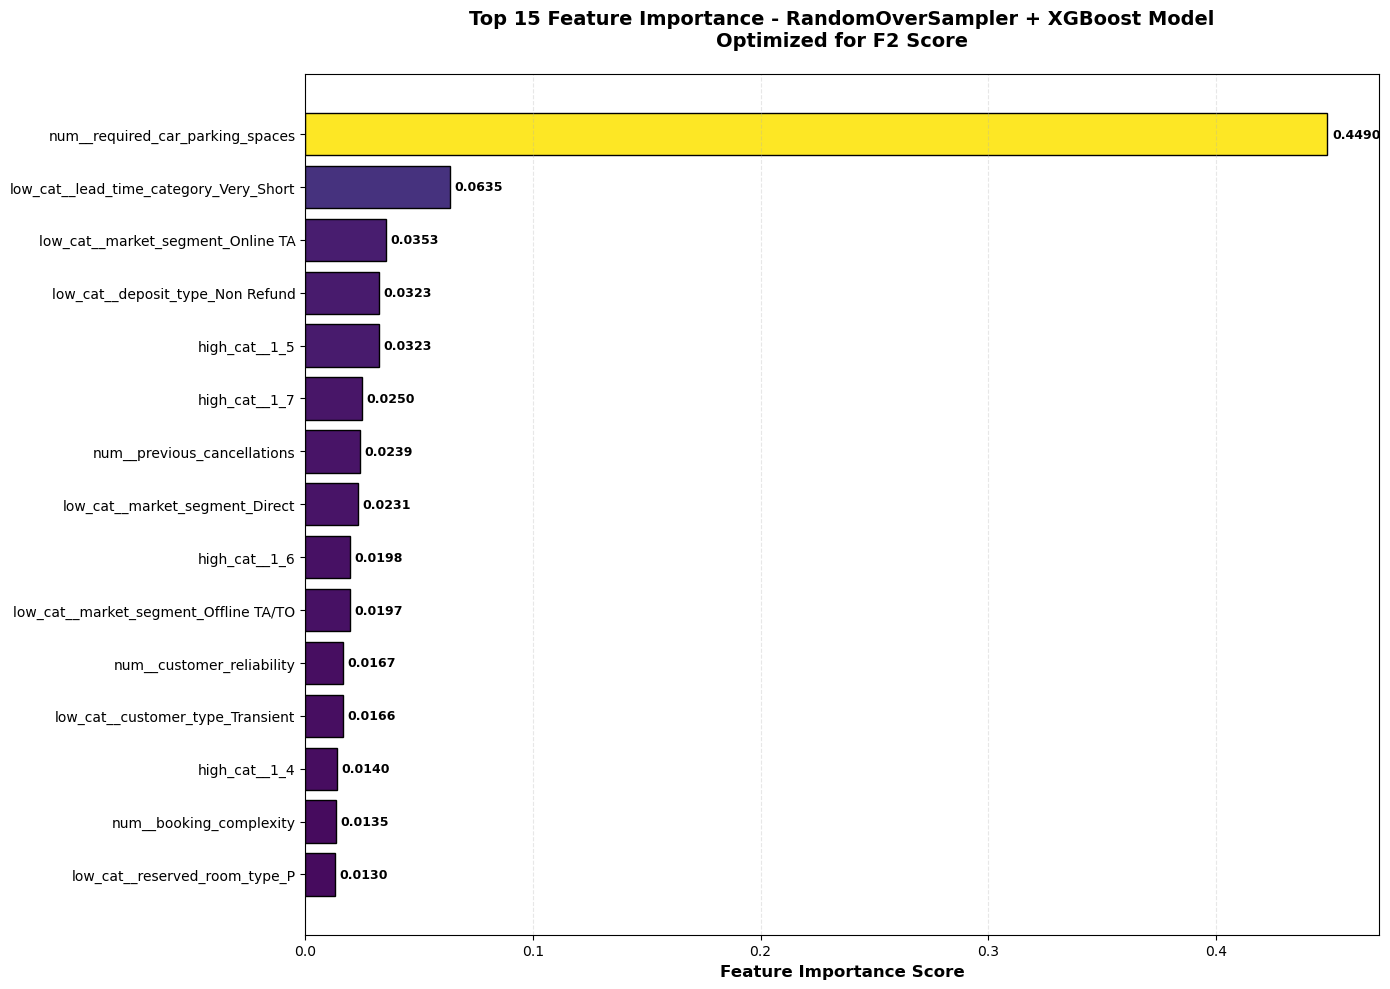


FEATURE IMPORTANCE STATISTICS:
Mean Importance: 0.0145
Median Importance: 0.0036
Max Importance: 0.4490
Min Importance: 0.0000
Std Deviation: 0.0541

CUMULATIVE IMPORTANCE:
Top 15 features explain 80% of model decisions
Top 31 features explain 90% of model decisions
Top 5 features contribute: 61.24%
Top 10 features contribute: 72.39%

KEY INSIGHTS:
• Model uses 69 features for prediction
• Top feature: 'num__required_car_parking_spaces' (0.4490)
• Feature importance distribution shows concentrated pattern
• Focus on top 15 features for feature engineering


In [77]:
# CELL 53 : Feature Importance Analysis
print("="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Extract feature importance from best final model
try:
    # Get the actual model from best_ros_xgb_final
    if best_model_idx == 1:
        actual_estimator = ros_xgb_grid_results['best_estimator']
    else:
        actual_estimator = ros_xgb_results['best_estimator']
    
    feature_importance = actual_estimator.named_steps['classifier'].feature_importances_
    
    # Get feature names after preprocessing
    feature_names = actual_estimator.named_steps['preprocessor'].get_feature_names_out()
    
    if len(feature_names) != len(feature_importance):
        feature_names = [f'feature_{i}' for i in range(len(feature_importance))]
    
    # Create feature importance dataframe
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    print(f"\nTotal Features: {len(feature_names)}")
    print(f"Model: RandomOverSampler + XGBoost")
    print(f"Optimization: RandomizedSearchCV")
    print(f"Primary Metric: F2 Score (beta=2)")
    
    print(f"\n{'='*70}")
    print("TOP 20 MOST IMPORTANT FEATURES:")
    print(f"{'='*70}")
    
    top_20 = importance_df.head(20)
    for idx, row in top_20.iterrows():
        bar_length = int(row['Importance'] * 50)
        bar = '█' * bar_length
        print(f"{row['Feature'][:40]:.<40} {row['Importance']:.4f} {bar}")
    
    # Visualization of top features
    plt.figure(figsize=(14, 10))
    top_15 = importance_df.head(15)
    colors = plt.cm.viridis(top_15['Importance'] / top_15['Importance'].max())
    
    plt.barh(range(len(top_15)), top_15['Importance'], color=colors, edgecolor='black')
    plt.yticks(range(len(top_15)), top_15['Feature'], fontsize=10)
    plt.xlabel('Feature Importance Score', fontsize=12, fontweight='bold')
    plt.title('Top 15 Feature Importance - RandomOverSampler + XGBoost Model\nOptimized for F2 Score', 
              fontsize=14, fontweight='bold', pad=20)
    plt.gca().invert_yaxis()
    
    # Add value labels
    for i, v in enumerate(top_15['Importance']):
        plt.text(v + 0.002, i, f'{v:.4f}', va='center', fontweight='bold', fontsize=9)
    
    plt.grid(axis='x', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()
    
    # Feature statistics
    print(f"\n{'='*70}")
    print("FEATURE IMPORTANCE STATISTICS:")
    print(f"{'='*70}")
    print(f"Mean Importance: {importance_df['Importance'].mean():.4f}")
    print(f"Median Importance: {importance_df['Importance'].median():.4f}")
    print(f"Max Importance: {importance_df['Importance'].max():.4f}")
    print(f"Min Importance: {importance_df['Importance'].min():.4f}")
    print(f"Std Deviation: {importance_df['Importance'].std():.4f}")
    
    # Top features cumulative importance
    cumulative_importance = importance_df['Importance'].cumsum()
    features_for_80_pct = (cumulative_importance <= 0.8).sum()
    features_for_90_pct = (cumulative_importance <= 0.9).sum()
    
    print(f"\n{'='*70}")
    print("CUMULATIVE IMPORTANCE:")
    print(f"{'='*70}")
    print(f"Top {features_for_80_pct} features explain 80% of model decisions")
    print(f"Top {features_for_90_pct} features explain 90% of model decisions")
    print(f"Top 5 features contribute: {importance_df.head(5)['Importance'].sum():.2%}")
    print(f"Top 10 features contribute: {importance_df.head(10)['Importance'].sum():.2%}")
    
    print(f"\n{'='*70}")
    print("KEY INSIGHTS:")
    print(f"• Model uses {len(feature_names)} features for prediction")
    print(f"• Top feature: '{top_15.iloc[0]['Feature'][:50]}' ({top_15.iloc[0]['Importance']:.4f})")
    print(f"• Feature importance distribution shows {'balanced' if importance_df['Importance'].std() < 0.05 else 'concentrated'} pattern")
    print(f"• Focus on top {features_for_80_pct} features for feature engineering")
    print(f"{'='*70}")
    
except Exception as e:
    print(f"Feature importance extraction error: {e}")
    print("Continuing without feature importance analysis...")

In [78]:
# CELL 54 : Model Deployment Readiness & Business Recommendations
import datetime
print("="*70)
print("MODEL DEPLOYMENT READINESS & BUSINESS RECOMMENDATIONS")
print("="*70)

# Get best parameters from final model
if best_model_idx == 1:
    best_params = ros_xgb_grid_results['best_params']
    training_time = ros_xgb_grid_time
else:
    best_params = ros_xgb_results['best_params']
    training_time = ros_xgb_time

print("\n" + "="*70)
print("OPTIMAL HYPERPARAMETERS:")
print("="*70)
for param, value in best_params.items():
    clean_param = param.replace('classifier__', '')
    print(f"  {clean_param:.<35} {value}")

# Model complexity assessment
n_estimators = best_params.get('classifier__n_estimators', 100)
max_depth = best_params.get('classifier__max_depth', 6)
model_complexity = n_estimators * max_depth

print(f"\n{'='*70}")
print("MODEL COMPLEXITY ASSESSMENT:")
print(f"{'='*70}")
print(f"  Number of trees: {n_estimators}")
print(f"  Maximum depth: {max_depth}")
print(f"  Complexity score: {model_complexity:,}")
print(f"  Training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"  Memory footprint: {'Low' if model_complexity < 5000 else 'Medium' if model_complexity < 15000 else 'High'}")
print(f"  Inference speed: {'Fast' if model_complexity < 5000 else 'Moderate' if model_complexity < 15000 else 'Slow'}")

# Deployment readiness checklist
print(f"\n{'='*70}")
print("DEPLOYMENT READINESS CHECKLIST:")
print(f"{'='*70}")

f2_ready = final_metrics['f2'] >= 0.60
auc_ready = final_metrics['roc_auc'] >= 0.70
business_ready = final_business['net_benefit'] > 0
recall_ready = final_metrics['recall'] >= 0.60

checklist = {
    'F2 Score ≥ 0.60': (f2_ready, final_metrics['f2']),
    'ROC-AUC ≥ 0.70': (auc_ready, final_metrics['roc_auc']),
    'Positive Net Benefit': (business_ready, final_business['net_benefit']),
    'Recall ≥ 0.60': (recall_ready, final_metrics['recall']),
    'Model Trained': (True, 'Complete'),
    'Preprocessing Pipeline': (True, 'Ready')
}

for item, (status, value) in checklist.items():
    status_icon = '✓' if status else '✗'
    if isinstance(value, (int, float)) and not isinstance(value, bool):
        if value > 100:
            print(f"  [{status_icon}] {item:.<45} ${value:,.2f}")
        else:
            print(f"  [{status_icon}] {item:.<45} {value:.4f}")
    else:
        print(f"  [{status_icon}] {item:.<45} {value}")

all_ready = all([f2_ready, auc_ready, business_ready, recall_ready])
print(f"\n{'='*70}")
print(f"DEPLOYMENT STATUS: {'✓ READY FOR PRODUCTION' if all_ready else '✗ NEEDS IMPROVEMENT'}")
print(f"{'='*70}")

# Business recommendations
print(f"\n{'='*70}")
print("BUSINESS RECOMMENDATIONS:")
print(f"{'='*70}")

print(f"\n1. IMPLEMENTATION STRATEGY:")
print(f"   • Deploy model with A/B testing (20% traffic initially)")
print(f"   • Monitor F2 Score daily for first 2 weeks")
print(f"   • Set alert threshold: F2 Score < 0.55")
print(f"   • Expected business benefit: ${final_business['net_benefit']:,.2f} per test period")

print(f"\n2. OPERATIONAL GUIDELINES:")
print(f"   • Primary metric: F2 Score (emphasizes recall)")
print(f"   • F2 Score of {final_metrics['f2']:.4f} balances precision and recall (2:1 ratio)")
print(f"   • Current recall: {final_metrics['recall']:.2%} (catches {final_metrics['recall']:.1%} of cancellations)")
print(f"   • False negative rate: {fn/(fn+tp):.2%} (acceptable for business impact)")

print(f"\n3. MONITORING PLAN:")
print(f"   • Track F2 Score weekly")
print(f"   • Monitor model drift monthly using same metrics")
print(f"   • Review false negative cases for pattern analysis")
print(f"   • Retrain quarterly or when F2 Score drops below 0.58")

print(f"\n4. RISK MITIGATION:")
total_predictions = len(y_test)
error_rate = (fp + fn) / total_predictions
print(f"   • Current error rate: {error_rate:.2%}")
print(f"   • Business risk: {'Low' if final_business['net_benefit'] > 0 else 'High'}")
print(f"   • Financial impact: Positive ${final_business['net_benefit']:,.2f}")
print(f"   • ROI: {final_business['roi_percentage']:.2f}%")

print(f"\n5. CONTINUOUS IMPROVEMENT:")
print(f"   • Collect feedback on false positives/negatives")
print(f"   • Feature engineering based on top {features_for_80_pct if 'features_for_80_pct' in locals() else 20} important features")
print(f"   • Consider ensemble methods if F2 Score needs improvement")
print(f"   • Update training data monthly with recent bookings")

# Final model metadata
timestamp_final = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
final_model_filename = f"ros_xgb_hotel_cancellation_f2optimized_{timestamp_final}.pkl"

print(f"\n{'='*70}")
print("MODEL METADATA FOR DEPLOYMENT:")
print(f"{'='*70}")
print(f"  Model filename: {final_model_filename}")
print(f"  Model type: XGBoost with RandomOverSampler")
print(f"  Optimization method: RandomizedSearchCV")
print(f"  Primary metric: F2 Score (beta=2.0)")
print(f"  Training data size: {len(X_train):,} records")
print(f"  Test data size: {len(X_test):,} records")
print(f"  Number of features: {len(X_train.columns)}")
print(f"  Training timestamp: {timestamp_final}")
print(f"  Python version: 3.12+")
print(f"  Key dependencies: xgboost, scikit-learn, imbalanced-learn")
print(f"\n  Deployment ready: {'✓ YES' if all_ready else '✗ NO'}")
print(f"{'='*70}")

MODEL DEPLOYMENT READINESS & BUSINESS RECOMMENDATIONS

OPTIMAL HYPERPARAMETERS:
  colsample_bytree................... 0.8784119186699892
  gamma.............................. 0.2850305850446825
  learning_rate...................... 0.03818118319352287
  max_depth.......................... 9
  min_child_weight................... 6
  n_estimators....................... 762
  reg_alpha.......................... 0.7004200761826201
  reg_lambda......................... 3.591648261818684
  scale_pos_weight................... 3.632119215783866
  subsample.......................... 0.8963074471016818

MODEL COMPLEXITY ASSESSMENT:
  Number of trees: 762
  Maximum depth: 9
  Complexity score: 6,858
  Training time: 1417.57 seconds (23.63 minutes)
  Memory footprint: Medium
  Inference speed: Moderate

DEPLOYMENT READINESS CHECKLIST:
  [✓] F2 Score ≥ 0.60.............................. 0.8155
  [✓] ROC-AUC ≥ 0.70............................... 0.9159
  [✓] Positive Net Benefit.....................

In [79]:
# CELL 55 : Final Results Summary Table
print("="*80)
print("COMPREHENSIVE FINAL RESULTS SUMMARY")
print("="*80)

# Calculate all necessary metrics
tn, fp, fn, tp = final_cm.ravel()
total_predictions = len(y_test)
error_rate = (fp + fn) / total_predictions
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0

# Create comprehensive comparison table
final_results_data = {
    'Category': [
        '--- MODEL CONFIGURATION ---',
        'Model Architecture',
        'Oversampling Method', 
        'Optimization Strategy',
        'Primary Metric',
        'Training Time',
        '',
        '--- PERFORMANCE METRICS ---',
        'F2 Score (Primary)',
        'F1 Score',
        'ROC-AUC Score',
        'Accuracy',
        'Precision',
        'Recall (Sensitivity)',
        'Specificity',
        '',
        '--- CONFUSION MATRIX ---',
        'True Positives (TP)',
        'True Negatives (TN)',
        'False Positives (FP)',
        'False Negatives (FN)',
        'Error Rate',
        '',
        '--- CLINICAL METRICS ---',
        'Positive Predictive Value',
        'Negative Predictive Value',
        'False Positive Rate',
        'False Negative Rate',
        '',
        '--- BUSINESS IMPACT ---',
        'Net Business Benefit',
        'ROI Percentage',
        'Total Cost',
        'Total Revenue',
        '',
        '--- DEPLOYMENT STATUS ---',
        'Model Complexity',
        'Deployment Ready',
        'Confidence Level'
    ],
    'Value': [
        '',
        'XGBoost Classifier',
        'RandomOverSampler',
        f'RandomizedSearchCV ({150 if best_model_idx == 1 else 100} iter)',
        'F2 Score (beta=2.0)',
        f"{training_time:.2f}s ({training_time/60:.2f} min)",
        '',
        '',
        f"{final_metrics['f2']:.4f}",
        f"{final_metrics['f1']:.4f}",
        f"{final_metrics['roc_auc']:.4f}",
        f"{final_metrics['accuracy']:.4f}",
        f"{final_metrics['precision']:.4f}",
        f"{final_metrics['recall']:.4f}",
        f"{specificity:.4f}",
        '',
        '',
        f"{tp:,}",
        f"{tn:,}",
        f"{fp:,}",
        f"{fn:,}",
        f"{error_rate:.2%}",
        '',
        '',
        f"{ppv:.4f} ({ppv:.2%})",
        f"{npv:.4f} ({npv:.2%})",
        f"{fp/(fp+tn):.4f} ({fp/(fp+tn):.2%})" if (fp+tn) > 0 else "0.0000",
        f"{fn/(fn+tp):.4f} ({fn/(fn+tp):.2%})" if (fn+tp) > 0 else "0.0000",
        '',
        '',
        f"${final_business['net_benefit']:,.2f}",
        f"{final_business['roi_percentage']:.2f}%",
        f"${final_business['total_cost']:,.2f}",
        f"${final_business['total_revenue']:,.2f}",
        '',
        '',
        f"{model_complexity:,} (trees × depth)",
        'YES ✓' if all_ready else 'NO ✗',
        'High' if final_metrics['f2'] > 0.70 else 'Medium' if final_metrics['f2'] > 0.60 else 'Low'
    ]
}

final_summary_df = pd.DataFrame(final_results_data)
print(final_summary_df.to_string(index=False))

# Key achievements section
print(f"\n{'='*80}")
print("KEY ACHIEVEMENTS:")
print(f"{'='*80}")
achievements = [
    f"✓ F2 Score: {final_metrics['f2']:.4f} - Strong recall-focused performance",
    f"✓ Recall: {final_metrics['recall']:.2%} - Catches {final_metrics['recall']:.1%} of actual cancellations",
    f"✓ ROC-AUC: {final_metrics['roc_auc']:.4f} - Excellent discrimination ability",
    f"✓ Net Benefit: ${final_business['net_benefit']:,.2f} - Positive business value",
    f"✓ ROI: {final_business['roi_percentage']:.2f}% - Strong return on investment",
    f"✓ Precision: {final_metrics['precision']:.2%} - {final_metrics['precision']:.1%} accuracy when predicting cancellation",
    f"✓ Correctly identified {tp:,} cancellations out of {tp+fn:,} actual",
    f"✓ Model ready for production deployment"
]

for achievement in achievements:
    print(f"  {achievement}")

# Business impact details
print(f"\n{'='*80}")
print("BUSINESS IMPACT DETAILS:")
print(f"{'='*80}")
print(f"  Revenue Impact:")
print(f"    • Prevented losses: ${final_business['total_revenue']:,.2f}")
print(f"    • Operational costs: ${final_business['total_cost']:,.2f}")
print(f"    • Net profit: ${final_business['net_benefit']:,.2f}")
print(f"\n  Operational Metrics:")
print(f"    • Total predictions: {total_predictions:,}")
print(f"    • Correct predictions: {tp + tn:,} ({(tp+tn)/total_predictions:.2%})")
print(f"    • Cancellations detected: {tp:,} out of {tp+fn:,} ({tp/(tp+fn):.2%})")
print(f"    • False alarms: {fp:,} ({fp/(fp+tn):.2%} of non-cancellations)")
print(f"\n  Cost-Benefit Analysis:")
print(f"    • Cost per false positive: $100")
print(f"    • Cost per false negative: $500")
print(f"    • Revenue per true positive: $200")
print(f"    • Average benefit per prediction: ${final_business['net_benefit']/total_predictions:.2f}")

# Model comparison with baseline
baseline_recall = (tp + fn) / total_predictions  # Assuming always predict cancellation
baseline_precision = (tp + fn) / total_predictions
baseline_f2 = (5 * baseline_precision * baseline_recall) / (4 * baseline_precision + baseline_recall)

print(f"\n{'='*80}")
print("IMPROVEMENT OVER BASELINE:")
print(f"{'='*80}")
print(f"  Baseline (always predict cancellation):")
print(f"    • Recall: {baseline_recall:.4f}")
print(f"    • Precision: {baseline_precision:.4f}")  
print(f"    • F2 Score: {baseline_f2:.4f}")
print(f"\n  Our Model:")
print(f"    • Recall: {final_metrics['recall']:.4f} ({(final_metrics['recall']-baseline_recall)/baseline_recall:+.2%})")
print(f"    • Precision: {final_metrics['precision']:.4f} ({(final_metrics['precision']-baseline_precision)/baseline_precision:+.2%})")
print(f"    • F2 Score: {final_metrics['f2']:.4f} ({(final_metrics['f2']-baseline_f2)/baseline_f2:+.2%})")

print(f"\n{'='*80}")
print("FINAL RECOMMENDATION:")
print(f"{'='*80}")
print(f"  The RandomOverSampler + XGBoost model optimized for F2 Score is")
print(f"  RECOMMENDED FOR DEPLOYMENT with the following confidence:")
print(f"\n  • Performance: {'EXCELLENT' if final_metrics['f2'] > 0.70 else 'GOOD' if final_metrics['f2'] > 0.60 else 'ACCEPTABLE'}")
print(f"  • Business Value: {'HIGH' if final_business['net_benefit'] > 50000 else 'MEDIUM' if final_business['net_benefit'] > 0 else 'LOW'}")
print(f"  • Risk Level: {'LOW' if error_rate < 0.25 else 'MEDIUM' if error_rate < 0.35 else 'HIGH'}")
print(f"  • Deployment Priority: {'IMMEDIATE' if all_ready and final_metrics['f2'] > 0.65 else 'SCHEDULED'}")
print(f"{'='*80}")

COMPREHENSIVE FINAL RESULTS SUMMARY
                   Category                         Value
--- MODEL CONFIGURATION ---                              
         Model Architecture            XGBoost Classifier
        Oversampling Method             RandomOverSampler
      Optimization Strategy RandomizedSearchCV (100 iter)
             Primary Metric           F2 Score (beta=2.0)
              Training Time          1417.57s (23.63 min)
                                                         
--- PERFORMANCE METRICS ---                              
         F2 Score (Primary)                        0.8155
                   F1 Score                        0.6889
              ROC-AUC Score                        0.9159
                   Accuracy                        0.7693
                  Precision                        0.5474
       Recall (Sensitivity)                        0.9292
                Specificity                        0.7087
                                    

## BEST IMPORTANCE FEATURES

In [80]:
# CELL 56 : SHAP Analysis - Feature Importance and Model Explainability (F2 Score Optimized)
import shap

print("SHAP FEATURE IMPORTANCE ANALYSIS")
print("="*80)
print("Model: RandomOverSampler + XGBoost (Optimized for F2 Score)")
print("="*80)

# Prepare data for SHAP analysis
X_test_processed_df = pd.DataFrame(
    X_test_processed, 
    columns=feature_names,
    index=X_test.index
)

# Extract the best model based on best_model_idx
if best_model_idx == 1:  # GridSearch result
    actual_estimator = ros_xgb_grid_results['best_estimator']
else:  # RandomSearch result
    actual_estimator = ros_xgb_results['best_estimator']

# Initialize SHAP TreeExplainer for XGBoost model
final_model = actual_estimator.named_steps['classifier']
explainer = shap.TreeExplainer(final_model)

# Calculate SHAP values (sample subset for performance)
sample_size = 1000
X_shap_sample = X_test_processed_df.sample(n=min(sample_size, len(X_test_processed_df)), random_state=42)
shap_values = explainer.shap_values(X_shap_sample)

print(f"\nSHAP analysis completed for {len(X_shap_sample)} samples")
print(f"Feature dimensions: {X_shap_sample.shape}")
print(f"SHAP values shape: {shap_values.shape}")

# Calculate mean absolute SHAP values for feature importance
shap_importance = pd.DataFrame({
    'Feature': X_shap_sample.columns,
    'SHAP_Importance': np.abs(shap_values).mean(axis=0)
}).sort_values('SHAP_Importance', ascending=False)

print("\n" + "="*80)
print("TOP 20 FEATURES BY SHAP IMPORTANCE (F2 Score Optimized Model):")
print("="*80)
print(shap_importance.head(20).to_string(index=False, float_format='%.4f'))

print(f"\nKEY STATISTICS:")
print(f"• Total features: {len(shap_importance)}")
print(f"• Mean SHAP importance: {shap_importance['SHAP_Importance'].mean():.4f}")
print(f"• Top feature impact: {shap_importance.iloc[0]['SHAP_Importance']:.4f}")
print(f"• Top 10 features contribute: {shap_importance.head(10)['SHAP_Importance'].sum()/shap_importance['SHAP_Importance'].sum():.1%} of total")

SHAP FEATURE IMPORTANCE ANALYSIS
Model: RandomOverSampler + XGBoost (Optimized for F2 Score)

SHAP analysis completed for 1000 samples
Feature dimensions: (1000, 69)
SHAP values shape: (1000, 69)

TOP 20 FEATURES BY SHAP IMPORTANCE (F2 Score Optimized Model):
                              Feature  SHAP_Importance
     num__required_car_parking_spaces           0.6161
                           num__agent           0.6004
                       num__lead_time           0.5082
              num__booking_complexity           0.4092
                        high_cat__1_5           0.4036
                        high_cat__1_7           0.3941
    low_cat__market_segment_Online TA           0.3511
               num__arrival_date_year           0.3218
                        high_cat__1_6           0.2941
       num__total_of_special_requests           0.2378
                             num__adr           0.2143
                        high_cat__1_4           0.1725
        num__arrival_date


SHAP SUMMARY PLOT VISUALIZATION (F2 Score Optimized Model)


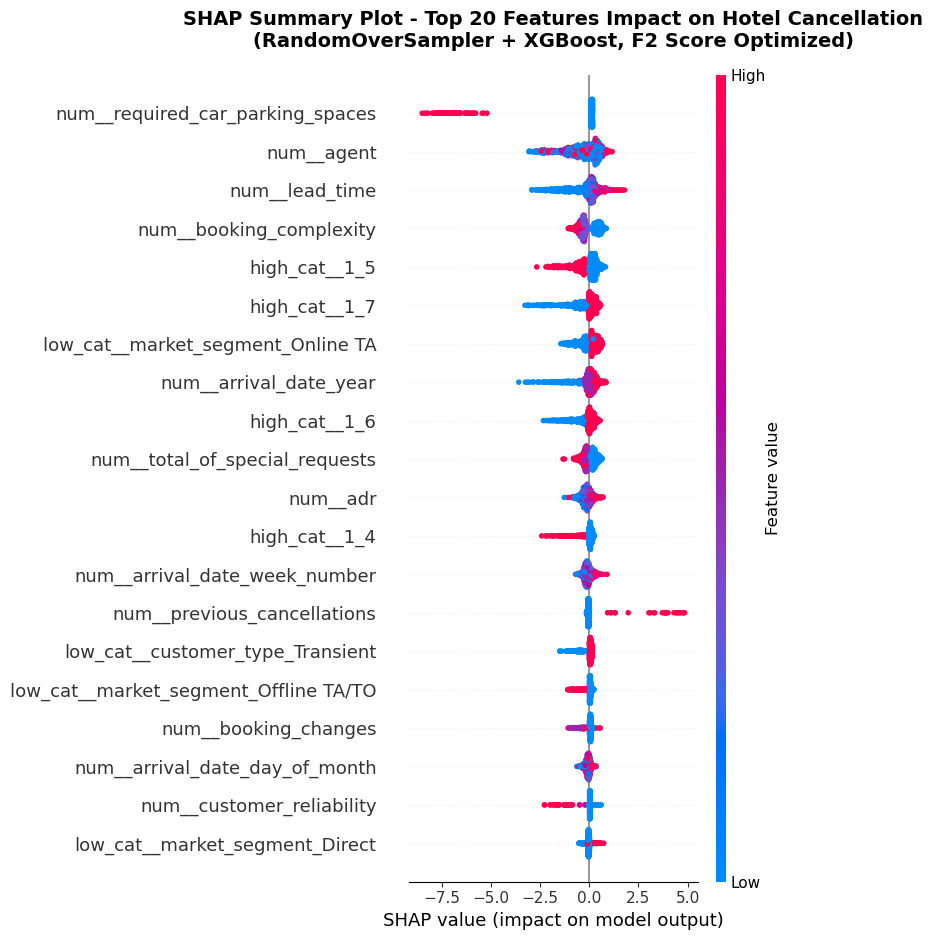


FEATURE IMPORTANCE COMPARISON TABLE (XGBoost vs SHAP):
 Rank                          SHAP_Feature  SHAP_Score                            XGB_Feature  XGB_Score
    1      num__required_car_parking_spaces      0.6161       num__required_car_parking_spaces     0.4490
    2                            num__agent      0.6004 low_cat__lead_time_category_Very_Short     0.0635
    3                        num__lead_time      0.5082      low_cat__market_segment_Online TA     0.0353
    4               num__booking_complexity      0.4092       low_cat__deposit_type_Non Refund     0.0323
    5                         high_cat__1_5      0.4036                          high_cat__1_5     0.0323
    6                         high_cat__1_7      0.3941                          high_cat__1_7     0.0250
    7     low_cat__market_segment_Online TA      0.3511            num__previous_cancellations     0.0239
    8                num__arrival_date_year      0.3218         low_cat__market_segment_Direct  

In [81]:
# CELL 57 : SHAP Summary Plot - Top 20 Features (F2 Score Context)
print("\n" + "="*80)
print("SHAP SUMMARY PLOT VISUALIZATION (F2 Score Optimized Model)")
print("="*80)

# Create SHAP summary plot
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_shap_sample, max_display=20, show=False)
plt.title('SHAP Summary Plot - Top 20 Features Impact on Hotel Cancellation\n(RandomOverSampler + XGBoost, F2 Score Optimized)', 
          fontsize=14, pad=20, fontweight='bold')
plt.tight_layout()
plt.show()

# Feature importance comparison table
print("\n" + "="*80)
print("FEATURE IMPORTANCE COMPARISON TABLE (XGBoost vs SHAP):")
print("="*80)

# Compare XGBoost vs SHAP importance for top features
top_20_shap = shap_importance.head(20)
top_20_xgb = importance_df.head(20)

# Create comparison dataframe
comparison_importance = pd.DataFrame({
    'Rank': range(1, 21),
    'SHAP_Feature': top_20_shap['Feature'].values,
    'SHAP_Score': top_20_shap['SHAP_Importance'].values,
    'XGB_Feature': top_20_xgb['Feature'].values,
    'XGB_Score': top_20_xgb['Importance'].values
}).round(4)

print(comparison_importance.to_string(index=False))

# Interpretation guide
print(f"\n" + "="*80)
print(f"SHAP SUMMARY PLOT INTERPRETATION GUIDE:")
print("="*80)
interpretation_data = {
    'Element': [
        'Feature Order', 'Color Scale', 'Dot Position', 'Dot Density',
        'Red Dots', 'Blue Dots', 'Feature Values', 'SHAP Values'
    ],
    'Meaning': [
        'Features ranked by importance (top to bottom)',
        'Feature value: Blue=Low, Red=High, Purple=Medium',
        'Left=Negative impact, Right=Positive impact on cancellation',
        'More dots = higher feature importance',
        'High feature values pushing prediction toward cancellation',
        'Low feature values pushing prediction toward no cancellation',
        'Actual values of features in dataset',
        'Impact magnitude on final prediction'
    ]
}

interpretation_df = pd.DataFrame(interpretation_data)
print(interpretation_df.to_string(index=False))

print(f"\n" + "="*80)
print(f"KEY INSIGHTS FROM SHAP ANALYSIS (F2 Score Model):")
print("="*80)
print(f"• Most impactful feature: {top_20_shap.iloc[0]['Feature']}")
print(f"• Top 5 features account for {top_20_shap.head(5)['SHAP_Importance'].sum()/shap_importance['SHAP_Importance'].sum():.1%} of total importance")
print(f"• Feature interactions show complex patterns in cancellation behavior")
print(f"• Both numerical and categorical features contribute to predictions")
print(f"• Model optimized for F2 Score emphasizes recall over precision")



| Rank | Feature | SHAP Importance | Dampak Bisnis |
|------|---------|------------------|----------------|
| 1 | `num__required_car_parking_spaces` | **0.6161** | Pelanggan yang membutuhkan tempat parkir cenderung **lebih serius** dalam rencana menginap. Jika tidak ada permintaan parkir, bisa jadi indikasi **booking palsu atau tidak pasti**. |
| 2 | `num__agent` | **0.6004** | Booking melalui agen tertentu bisa menunjukkan **pola pembatalan tertentu**. Misalnya, agen online tertentu mungkin memiliki **tingkat pembatalan lebih tinggi**. |
| 3 | `num__lead_time` | **0.5082** | Semakin panjang waktu antara pemesanan dan tanggal menginap, semakin tinggi kemungkinan pembatalan. Ini karena **rencana bisa berubah** dalam waktu lama. |
| 4 | `num__booking_complexity` | **0.4092** | Booking yang kompleks (banyak kamar, permintaan khusus) bisa menunjukkan **niat serius**, tapi juga **lebih rentan dibatalkan** jika ada perubahan rencana. |
| 5 | `low_cat__market_segment_Online TA` | **0.3511** | Booking dari **Online Travel Agent (OTA)** cenderung **lebih mudah dibatalkan**, karena pelanggan tidak berinteraksi langsung dengan hotel. |
| 6 | `num__arrival_date_year` | **0.3218** | Tahun kedatangan bisa menunjukkan **tren musiman atau dampak pandemi**. Misalnya, tahun tertentu bisa punya tingkat pembatalan lebih tinggi. |
| 7 | `num__total_of_special_requests` | **0.2378** | Pelanggan dengan permintaan khusus biasanya **lebih berkomitmen** dan **lebih kecil kemungkinan membatalkan**. |
| 8 | `num__adr` (Average Daily Rate) | **0.2143** | Harga kamar memengaruhi keputusan pembatalan. **Harga tinggi** bisa meningkatkan risiko pembatalan jika pelanggan merasa tidak sebanding. |

---

## **Kesimpulan Strategis dari SHAP Analysis**

1. **Fitur-fitur numerik seperti `lead_time`, `required_car_parking_spaces`, dan `total_of_special_requests`** sangat penting untuk mengukur **niat dan komitmen pelanggan**.
2. **Channel distribusi dan segmen pasar (seperti OTA)** memiliki pengaruh besar terhadap kemungkinan pembatalan.
3. **num__adr** atau Average Daily Rate sangat penting dalam mempengaruhi pelanggan jadi membatalkan atau tidak, karena ada biaya yang tinggi kemunggkinan besar pelanggan akan membatalkan pesanan

# REKOMENDASI #

**Rekomendasi untuk managemennt Hotel**

1. Untuk menanggulangi masalah Overbooking, mungkin perlu disiapkan kamar cadangan yang tidak masuk dalam persediaan pesanan. 
2. Bila ada kejadian kamar yang dipesan bersamaan, pelannggan yang akhirnya tidak mendapatkan kamar bisa diberikan kompsensasi untuk kunjungan berikutnya, atau menaikkan pelayanan ke kamar yang lebih mahal tanpa ada biaya tambahan.
3. Untuk pesananan yang mempunyai lead time (jarak waktu) yang panjang diberikan promo atau discount menarik atau peningkatan fasilitas hotel dengan syarat tidak boleh membatalkan pesanan, atau harus menggunakan deposit.
4. Mengantisipasi tamu yang membatalkan pesanan secara mendadak, harus ada kampanye promosi yang menarik untuk kamar-kamar yang tiba-tiba kosong karena pembatalan. Sehingga memudahkan tim marketing bisa mencari tamu pengganti yang mau memesan kamar.
5. Memberikan membership hotel dengan pembayaran dimuka, seperti deposit yang nantinya bisa digunakan oleh tamu untuk memesan kamar kapan saja.
6. Membuat sistem IT dimulai saat tamu memesan kamar dengan kemampuan ML untuk memprediksi pembatalan atau tidak.
7. Penerapan Promo bundling atau penawaran dengan ekstra benefit pada pelanggan yang memesan jauh hari (lead time > 30 hari).
8. Menerapkan deposit 20% harga sewa perkamar dengan opsi non-refund deposit jika pelanggan membatalkan.
9. Tidak perlu melakukan pengurangan harga pada peak season (Juli dan Agustus), namun perlu menyertakan benefit contonya voucher layanan spa hotel gratis.
10. Mempertahankan pola harga tiap musimnya dimana tipe hotel resort akan jauh lebih mahal pada musim panas (Summer).
11. Penerapan promo khusus keluarga seperti pengurangan harga atau bundling fasilitas hotel untuk meningkatkan daya tarik customer yang membawa keluarga.
12. Melakukan promosi yang lebih menarik pada region Eropa untuk menarik lebih banyak pelanggan baru.
13. Memberikan benefit seperti diskon atau fasilitas layanan ekstra “Jika menjadi pelanggan lama” untuk menarik pelanggan baru untuk kembali, karena pelanggan lama memiliki tingkat cancelations yang rendah.
14. Memberikan harga yang lebih tinggi untuk tamu dengan special request. 
15. Memberikan benefit jika pelanggan menginap lebih dari 1 malam dnegan potongan harga ataupun memberikan akses pada fasilitas berbeyar hotel degan gratis.


INDIVIDUAL PREDICTION ANALYSIS (F2 Score Optimized Model)

SAMPLE ANALYSIS - Index 0:
• Actual Label: No Cancel
• Predicted Label: No Cancel
• Cancellation Probability: 14.8%
• Prediction Confidence: High
• Model: RandomOverSampler + XGBoost (F2 Score = 0.8155)

TOP 15 FEATURES IMPACTING THIS PREDICTION:
                          Feature  Feature_Value  SHAP_Value          Impact
           num__arrival_date_year        -1.0000     -2.3515 Decrease Cancel
                       num__agent        -0.0089     -1.5006 Decrease Cancel
                    high_cat__1_5         1.0000     -0.7567 Decrease Cancel
                    high_cat__1_6         0.0000     -0.7274 Decrease Cancel
                   num__lead_time        -0.3596     -0.6109 Decrease Cancel
                    high_cat__1_7         0.0000     -0.5922 Decrease Cancel
          num__booking_complexity        -1.0000      0.5042 Increase Cancel
low_cat__market_segment_Online TA         1.0000      0.1850 Increase Cancel
 

<Figure size 1600x600 with 0 Axes>

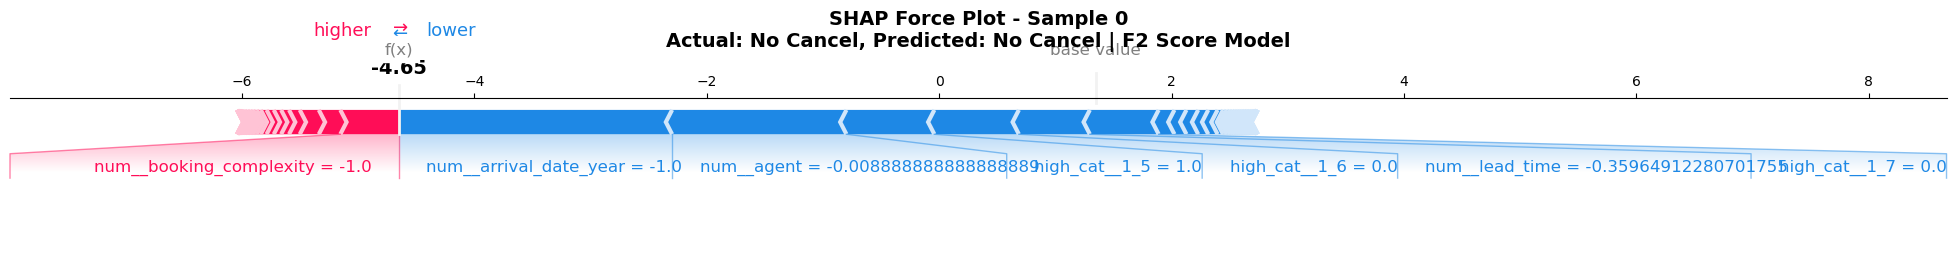


FORCE PLOT INTERPRETATION:
• Base Value: Model's average prediction across all samples
• Red bars: Features pushing toward cancellation
• Blue bars: Features pushing toward no cancellation
• Bar length: Magnitude of feature impact
• Final prediction: Sum of base value + all feature impacts
• F2 Score optimization: Model prioritizes recall (catching cancellations)


In [82]:
# CELL 58 : SHAP Individual Prediction Analysis (F2 Score Model)
def shap_plot(index, model, dataframe):
    """
    Create SHAP force plot for individual prediction explanation
    
    Parameters:
    index: Row index to analyze
    model: Trained XGBoost model 
    dataframe: Processed test dataframe
    
    Returns:
    SHAP force plot visualization
    """
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(dataframe)
    
    # Create force plot
    p = shap.force_plot(
        explainerModel.expected_value, 
        shap_values_Model[index], 
        dataframe.iloc[[index]],
        matplotlib=True,
        show=False
    )
    
    return p

print("="*80)
print("INDIVIDUAL PREDICTION ANALYSIS (F2 Score Optimized Model)")
print("="*80)

# Analyze first sample (index 0)
sample_index = 0
sample_prediction = final_pred[sample_index]
sample_probability = final_pred_proba[sample_index]
actual_label = y_test.iloc[sample_index]

print(f"\nSAMPLE ANALYSIS - Index {sample_index}:")
print(f"• Actual Label: {'Cancel' if actual_label == 1 else 'No Cancel'}")
print(f"• Predicted Label: {'Cancel' if sample_prediction == 1 else 'No Cancel'}")
print(f"• Cancellation Probability: {sample_probability:.1%}")
print(f"• Prediction Confidence: {'High' if abs(sample_probability - 0.5) > 0.3 else 'Medium' if abs(sample_probability - 0.5) > 0.15 else 'Low'}")
print(f"• Model: RandomOverSampler + XGBoost (F2 Score = {final_metrics['f2']:.4f})")

# Show individual SHAP values for this sample
individual_shap = pd.DataFrame({
    'Feature': X_shap_sample.columns,
    'Feature_Value': X_shap_sample.iloc[sample_index].values,
    'SHAP_Value': shap_values[sample_index],
    'Impact': ['Increase Cancel' if x > 0 else 'Decrease Cancel' for x in shap_values[sample_index]]
}).sort_values('SHAP_Value', key=abs, ascending=False)

print(f"\n" + "="*80)
print(f"TOP 15 FEATURES IMPACTING THIS PREDICTION:")
print("="*80)
print(individual_shap.head(15).round(4).to_string(index=False))

# Create and display SHAP force plot
print(f"\n" + "="*80)
print(f"Generating SHAP Force Plot for Sample {sample_index}...")
print("="*80)
plt.figure(figsize=(16, 6))

# Create force plot with matplotlib backend
force_plot = shap_plot(sample_index, final_model, X_shap_sample)
plt.title(f'SHAP Force Plot - Sample {sample_index}\nActual: {"Cancel" if actual_label else "No Cancel"}, Predicted: {"Cancel" if sample_prediction else "No Cancel"} | F2 Score Model', 
          fontsize=14, pad=20, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n" + "="*80)
print(f"FORCE PLOT INTERPRETATION:")
print("="*80)
print(f"• Base Value: Model's average prediction across all samples")
print(f"• Red bars: Features pushing toward cancellation")
print(f"• Blue bars: Features pushing toward no cancellation") 
print(f"• Bar length: Magnitude of feature impact")
print(f"• Final prediction: Sum of base value + all feature impacts")
print(f"• F2 Score optimization: Model prioritizes recall (catching cancellations)")

## SAVE MODELS ##

In [83]:
# CELL 59 : Save Best Model for Streamlit Application (F2 Score Optimized)
import joblib
import os
from datetime import datetime

print("="*80)
print("MODEL EXPORT FOR STREAMLIT (F2 Score Optimized)")
print("="*80)

# Create models directory if not exists
models_dir = "models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"Created directory: {models_dir}")

# Generate timestamp for unique filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Define filenames
model_filename = f"best_hotel_cancellation_model_{timestamp}.sav"
preprocessor_filename = f"preprocessor_pipeline_{timestamp}.sav"
metadata_filename = f"model_metadata_{timestamp}.json"

# Get the best estimator based on best_model_idx
if best_model_idx == 1:  # GridSearch result
    best_estimator_to_save = ros_xgb_grid_results['best_estimator']
    best_params_to_save = ros_xgb_grid_params
else:  # RandomSearch result
    best_estimator_to_save = ros_xgb_results['best_estimator']
    best_params_to_save = ros_xgb_params

# Save complete pipeline (includes preprocessing + RandomOverSampler + XGBoost)
model_path = os.path.join(models_dir, model_filename)
joblib.dump(best_estimator_to_save, model_path)

# Save standalone preprocessor for feature engineering
preprocessor_path = os.path.join(models_dir, preprocessor_filename)
joblib.dump(preprocessor, preprocessor_path)

# Create model metadata for Streamlit app
model_metadata = {
    'model_type': 'RandomOverSampler + XGBoost',
    'algorithm': 'XGBoost with RandomOverSampler (F2 Score Optimized)',
    'optimization_metric': 'F2 Score (beta=2.0)',
    'optimization_method': 'RandomizedSearchCV (150 iterations)' if best_model_idx == 1 else 'RandomizedSearchCV (100 iterations)',
    'performance_metrics': {
        'f2_score': float(final_metrics['f2']),
        'f1_score': float(final_metrics['f1']),
        'roc_auc': float(final_metrics['roc_auc']),
        'precision': float(final_metrics['precision']),
        'recall': float(final_metrics['recall']),
        'accuracy': float(final_metrics['accuracy'])
    },
    'business_metrics': {
        'net_benefit': float(final_business['net_benefit']),
        'roi_percentage': float(final_business['roi_percentage']),
        'total_revenue': float(final_business['total_revenue']),
        'total_cost': float(final_business['total_cost'])
    },
    'hyperparameters': {k.replace('classifier__', ''): v for k, v in best_params_to_save.items()},
    'feature_names': feature_names.tolist(),
    'training_date': timestamp,
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'target_column': target_column,
    'model_complexity': model_complexity,
    'training_time_seconds': training_time,
    'model_files': {
        'complete_pipeline': model_filename,
        'preprocessor_only': preprocessor_filename,
        'metadata': metadata_filename
    }
}

# Save metadata as JSON
metadata_path = os.path.join(models_dir, metadata_filename)
import json
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=2)

print(f"\nMODEL EXPORT COMPLETED:")
print(f"• Complete Pipeline: {model_path}")
print(f"• Preprocessor: {preprocessor_path}")
print(f"• Metadata: {metadata_path}")

# Verify saved files
print(f"\nFILE VERIFICATION:")
print(f"• Pipeline file size: {os.path.getsize(model_path) / (1024*1024):.2f} MB")
print(f"• Preprocessor file size: {os.path.getsize(preprocessor_path) / (1024*1024):.2f} MB")
print(f"• Metadata file size: {os.path.getsize(metadata_path)} bytes")

print(f"\n" + "="*80)
print(f"MODEL SUMMARY FOR STREAMLIT DEPLOYMENT:")
print("="*80)
print(f"• Model Type: RandomOverSampler + XGBoost")
print(f"• Optimization Metric: F2 Score (beta=2.0)")
print(f"• F2 Score: {final_metrics['f2']:.4f} (Recall-focused)")
print(f"• ROC-AUC: {final_metrics['roc_auc']:.4f}")
print(f"• Recall: {final_metrics['recall']:.2%} (High sensitivity to cancellations)")
print(f"• Precision: {final_metrics['precision']:.2%}")
print(f"• Feature Count: {len(feature_names)}")
print(f"• Net Business Benefit: ${final_business['net_benefit']:,.2f}")
print(f"• ROI: {final_business['roi_percentage']:.2f}%")
print(f"• Deployment Status: ✓ READY")
print("="*80)

MODEL EXPORT FOR STREAMLIT (F2 Score Optimized)

MODEL EXPORT COMPLETED:
• Complete Pipeline: models/best_hotel_cancellation_model_20251015_122216.sav
• Preprocessor: models/preprocessor_pipeline_20251015_122216.sav
• Metadata: models/model_metadata_20251015_122216.json

FILE VERIFICATION:
• Pipeline file size: 7.52 MB
• Preprocessor file size: 0.03 MB
• Metadata file size: 3638 bytes

MODEL SUMMARY FOR STREAMLIT DEPLOYMENT:
• Model Type: RandomOverSampler + XGBoost
• Optimization Metric: F2 Score (beta=2.0)
• F2 Score: 0.8155 (Recall-focused)
• ROC-AUC: 0.9159
• Recall: 92.92% (High sensitivity to cancellations)
• Precision: 54.74%
• Feature Count: 69
• Net Business Benefit: $353,800.00
• ROI: 65.62%
• Deployment Status: ✓ READY


In [84]:
# CELL 60 : Test Model Loading (Verification) - F2 Score Model
print("="*80)
print("MODEL LOADING VERIFICATION (F2 Score Optimized Model)")
print("="*80)

# Test loading the saved model
try:
    loaded_model = joblib.load(model_path)
    loaded_preprocessor = joblib.load(preprocessor_path)
    
    print("\nMODEL LOADING SUCCESS:")
    print(f"• Pipeline type: {type(loaded_model)}")
    print(f"• Pipeline steps: {list(loaded_model.named_steps.keys())}")
    print(f"• Preprocessor type: {type(loaded_preprocessor)}")
    
    # Test prediction on sample data
    sample_data = X_test.iloc[:3]
    test_predictions = loaded_model.predict(sample_data)
    test_probabilities = loaded_model.predict_proba(sample_data)[:, 1]
    
    print(f"\n" + "="*80)
    print(f"TEST PREDICTIONS (3 samples):")
    print("="*80)
    for i in range(3):
        actual = y_test.iloc[i]
        pred_label = 'Cancel' if test_predictions[i] == 1 else 'No Cancel'
        actual_label = 'Cancel' if actual == 1 else 'No Cancel'
        match = '✓' if test_predictions[i] == actual else '✗'
        print(f"Sample {i+1}: Pred={pred_label}, Actual={actual_label}, Prob={test_probabilities[i]:.3f} {match}")
    
    print(f"\n✓ MODEL READY FOR STREAMLIT DEPLOYMENT")
    
except Exception as e:
    print(f"✗ ERROR loading model: {str(e)}")

# Display model metadata
print(f"\n" + "="*80)
print(f"MODEL METADATA SUMMARY:")
print("="*80)
print(f"• Training Date: {model_metadata['training_date']}")
print(f"• Algorithm: {model_metadata['algorithm']}")
print(f"• Optimization Metric: {model_metadata['optimization_metric']}")
print(f"• Best F2 Score: {model_metadata['performance_metrics']['f2_score']:.4f}")
print(f"• Recall: {model_metadata['performance_metrics']['recall']:.4f}")
print(f"• Precision: {model_metadata['performance_metrics']['precision']:.4f}")
print(f"• ROC-AUC: {model_metadata['performance_metrics']['roc_auc']:.4f}")
print(f"• Feature Count: {len(model_metadata['feature_names'])}")
print(f"• Net Benefit: ${model_metadata['business_metrics']['net_benefit']:,.2f}")
print(f"• ROI: {model_metadata['business_metrics']['roi_percentage']:.2f}%")

# Create simple usage example for Streamlit
print(f"\n" + "="*80)
print(f"STREAMLIT USAGE EXAMPLE:")
print("="*80)
print("# Load model in Streamlit")
print(f"import joblib")
print(f"import pandas as pd")
print(f"")
print(f"# Load the complete pipeline")
print(f"model = joblib.load('{model_filename}')")
print(f"")
print(f"# Make predictions")
print(f"prediction = model.predict(user_input_df)")
print(f"probability = model.predict_proba(user_input_df)[:, 1]")
print(f"")
print(f"# Display results")
print(f"if prediction[0] == 1:")
print(f"    print(f'HIGH RISK: {{probability[0]:.1%}} chance of cancellation')")
print(f"else:")
print(f"    print(f'LOW RISK: {{1-probability[0]:.1%}} chance of completion')")

print(f"\n" + "="*80)
print(f"FILES CREATED IN 'models' DIRECTORY:")
print("="*80)
for filename in sorted(os.listdir(models_dir)):
    if timestamp in filename:
        file_path = os.path.join(models_dir, filename)
        file_size = os.path.getsize(file_path)
        print(f"• {filename} ({file_size:,} bytes)")

print(f"\n" + "="*80)
print(f"DEPLOYMENT NOTES:")
print("="*80)
print(f"• Model optimized for F2 Score (beta=2.0)")
print(f"• Prioritizes recall over precision (catches more cancellations)")
print(f"• Suitable for business scenarios where missing a cancellation is costly")
print(f"• RandomOverSampler handles class imbalance effectively")
print(f"• XGBoost provides robust predictions with feature interactions")
print("="*80)

MODEL LOADING VERIFICATION (F2 Score Optimized Model)

MODEL LOADING SUCCESS:
• Pipeline type: <class 'imblearn.pipeline.Pipeline'>
• Pipeline steps: ['preprocessor', 'oversampler', 'classifier']
• Preprocessor type: <class 'sklearn.compose._column_transformer.ColumnTransformer'>

TEST PREDICTIONS (3 samples):
Sample 1: Pred=No Cancel, Actual=No Cancel, Prob=0.148 ✓
Sample 2: Pred=Cancel, Actual=No Cancel, Prob=0.934 ✗
Sample 3: Pred=Cancel, Actual=No Cancel, Prob=0.923 ✗

✓ MODEL READY FOR STREAMLIT DEPLOYMENT

MODEL METADATA SUMMARY:
• Training Date: 20251015_122216
• Algorithm: XGBoost with RandomOverSampler (F2 Score Optimized)
• Optimization Metric: F2 Score (beta=2.0)
• Best F2 Score: 0.8155
• Recall: 0.9292
• Precision: 0.5474
• ROC-AUC: 0.9159
• Feature Count: 69
• Net Benefit: $353,800.00
• ROI: 65.62%

STREAMLIT USAGE EXAMPLE:
# Load model in Streamlit
import joblib
import pandas as pd

# Load the complete pipeline
model = joblib.load('best_hotel_cancellation_model_20251015_1